In [1]:
!nvidia-smi

Mon Jul 27 02:46:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [24]:
import torch 
import torch.nn as nn
import torchvision
import numpy as np 
import random
import os
import glob
import copy
from tqdm import tqdm as tqdm
from torchsummary import summary

seed = 42
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.manual_seed(seed)

best_model = None
best_loss = 0.
best_test_loss = 0.
best_test_acc = 0.
best_pred_labels = []
true_labels = []

pred_labels = []
test_acc = 0.
test_loss = 0.

# device = torch.device('cuda:0')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# train class samples 
print('Normal Samples in Training Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/train/NORMAL | wc -l
print('Pneumonia Samples in Training Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/train/PNEUMONIA | wc -l

Normal Samples in Training Data
1342
Pneumonia Samples in Training Data
3876


In [5]:
# Validation samples
print('Normal Samples in Validation Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/val/NORMAL | wc -l
print('Pneumonia Samples in Validation Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/val/PNEUMONIA | wc -l

Normal Samples in Validation Data
9
Pneumonia Samples in Validation Data
9


In [6]:
# Testing samples
print('Normal Samples in Testing Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/test/NORMAL | wc -l
print('Pneumonia Samples in Testing Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/test/PNEUMONIA | wc -l

Normal Samples in Testing Data
235
Pneumonia Samples in Testing Data
391


In [7]:
# Copying to Non DP data(train, val and test) to local to process/run faster during training & inference

!cp -R /content/drive/"My Drive"/NDP_Data/chest_xray/train ./

!cp -R /content/drive/"My Drive"/NDP_Data/chest_xray/val ./

!cp -R /content/drive/"My Drive"/NDP_Data/chest_xray/test ./

In [8]:
!ls -lrt

total 20
drwxr-xr-x 1 root root 4096 Jul 10 16:29 sample_data
drwx------ 4 root root 4096 Jul 27 02:46 drive
drwx------ 4 root root 4096 Jul 27 03:01 train
drwx------ 4 root root 4096 Jul 27 03:34 val
drwx------ 4 root root 4096 Jul 27 03:36 test


In [9]:
!ls -l ./train/NORMAL | wc -l

!ls -l ./train/PNEUMONIA | wc -l

1342
3876


In [10]:
!ls -l ./val/NORMAL | wc -l

!ls -l ./val/PNEUMONIA | wc -l

9
9


In [11]:
!ls -l ./test/NORMAL | wc -l

!ls -l ./test/PNEUMONIA | wc -l

235
391


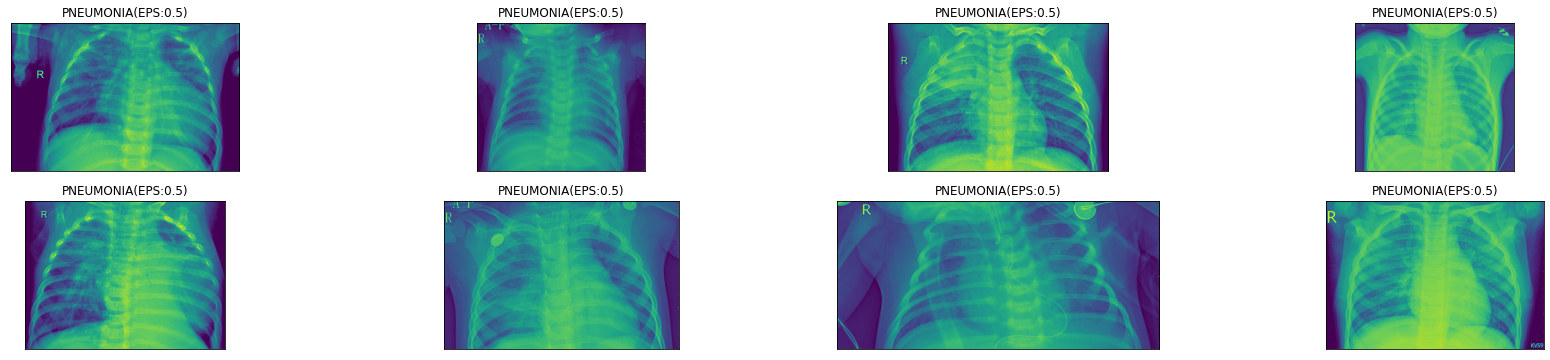

In [12]:
import matplotlib.pyplot as plt
from PIL import Image

fig = plt.figure(figsize=(30, 6))
base_dir = './train'
# display 8 PNEUMONIA images(train) for Epsilon :0.5
train_imgs = os.listdir(base_dir+"/PNEUMONIA")
for idx, img in enumerate(np.random.choice(train_imgs, 8)):
    ax = fig.add_subplot(2, 8//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/PNEUMONIA/" + img)
    plt.imshow(im)
    ax.set_title('PNEUMONIA(EPS:0.5)')

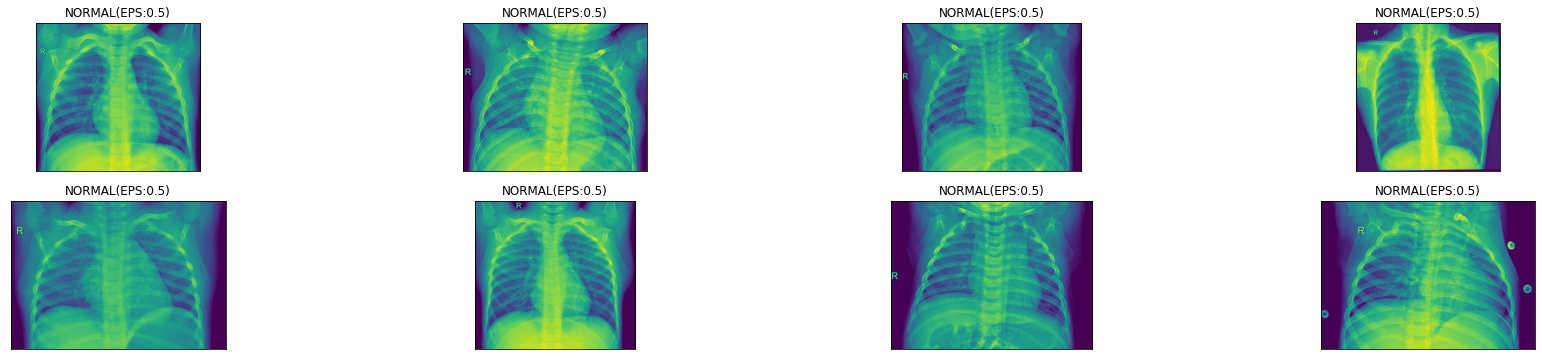

In [13]:
fig = plt.figure(figsize=(30, 6))
base_dir = './train'
# display 8 NORMAL images(train) for Epsilon :0.5
train_imgs = os.listdir(base_dir+"/NORMAL")
for idx, img in enumerate(np.random.choice(train_imgs, 8)):
    ax = fig.add_subplot(2, 8//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/NORMAL/" + img)
    plt.imshow(im)
    ax.set_title('NORMAL(EPS:0.5)')

In [14]:
class ChestXRay(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        sample, target = super().__getitem__(index)
        path, _ = self.samples[index]
        
        target = 0
        if 'PNEUMONIA' in path:
            target = 1
        
        return sample, target
       

In [15]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.RandomAffine(0, translate=(0, 0.1), scale=(1, 1.10)),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train_dataset = ChestXRay('./train/', transform=train_transforms)
val_dataset = ChestXRay('./val/', transform=train_transforms)
test_dataset = ChestXRay('./test/', transform=transforms)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [25]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(in_features=512, out_features=2)
model = model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
summary(model.cuda(), [(3,224,224,)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [27]:
def deactivate_batchnorm(m):
    if isinstance(m, nn.BatchNorm2d):
        m.reset_parameters()
        m.eval()
        #m.affine = False
        #m.track_running_stats = False
        with torch.no_grad():
            m.weight.fill_(1.0)
            m.bias.zero_()

In [28]:
def clip_grad(parameters, max_norm, norm_type=2):
    parameters = list(filter(lambda p: p.grad is not None, parameters))
    total_norm = 0
    for p in parameters:
        param_norm = p.grad.data.norm(norm_type)
        total_norm += param_norm.item() ** norm_type

In [29]:
def train_dp(model, trainloader, criterion, optimizer, lr_scheduler, phase='train'):
    """
    Differentially Private version of the training procedure
    :param trainloader:
    :param model:
    :param optimizer:
    :param epoch:
    :return:
    """
    model.train()
    model.apply(deactivate_batchnorm)
    running_loss = 0.0
    epoch_loss = 0.
    epoch_acc = 0.
    
    batch_num = 0.
    samples_num = 0.
    
    true_labels = []
    pred_labels = []
    num_microbatches = 32
    S = 1
    z = 9.7 #DP-SGD with sampling rate = 2.45% and noise_multiplier = 9.7 iterated over 2039 steps satisfies differential privacy with eps = 0.5 and delta = 0.0001.
            #The optimal RDP order is 38.0.
    sigma = z * S
    for batch_idx, data in tqdm(enumerate(trainloader, 0), leave=True):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        #print(loss.shape)
        running_loss += torch.mean(loss).item()

        true_labels.append(labels.detach().cpu())
        pred_labels.append(preds.detach().cpu())

        losses = torch.mean(loss.reshape(num_microbatches, -1), dim=1)
        saved_var = dict()
        for tensor_name, tensor in model.named_parameters():
            saved_var[tensor_name] = torch.zeros_like(tensor)

        for j in losses:
            j.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(model.parameters(), S)
            for tensor_name, tensor in model.named_parameters():
                new_grad = tensor.grad
                saved_var[tensor_name].add_(new_grad)
            model.zero_grad()

        for tensor_name, tensor in model.named_parameters():
            if device.type =='cuda':
                noise = torch.cuda.FloatTensor(tensor.grad.shape).normal_(0, sigma)
                #noise = torch.FloatTensor(tensor.grad.shape).normal_(0, sigma)
            else:
                noise = torch.FloatTensor(tensor.grad.shape).normal_(0, sigma)
            saved_var[tensor_name].add_(noise)
            tensor.grad = saved_var[tensor_name] / num_microbatches
        optimizer.step()

        #print(f'\r{phase} batch [{batch_idx}/{len(trainloader)}]: loss {loss}', end='', flush=True)
        print(f'\r{phase} batch [{batch_idx}/{len(trainloader)}]: loss {torch.mean(loss).item()}', end='', flush=True)
        epoch_loss += torch.mean(loss.detach().cpu()).item()
        epoch_acc += torch.sum(preds == labels.data)
        batch_num += 1
        samples_num += len(labels)

        '''if i > 0 and i % 20 == 0:
            #             logger.info('[%d, %5d] loss: %.3f' %
            #                   (epoch + 1, i + 1, running_loss / 2000))
            plot(epoch * len(trainloader) + i, running_loss, 'Train Loss')
            running_loss = 0.0'''
    #print("RETURNING........")
    return epoch_loss / batch_num, epoch_acc / samples_num, torch.cat(true_labels).numpy(), torch.cat(pred_labels).numpy()      

In [30]:
def test(model, testloader, criterion, optimizer, lr_scheduler, phase='test'):
    model.eval()
    model.apply(deactivate_batchnorm)
    #correct = 0
    #total = 0

    epoch_loss = 0.
    epoch_acc = 0.
    
    batch_num = 0.
    samples_num = 0.
    
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch_idx, data in  enumerate(testloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            #_, predicted = torch.max(outputs.data, 1)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            true_labels.append(labels.detach().cpu())
            pred_labels.append(preds.detach().cpu())

            # print(f'\r{phase} batch [{batch_idx}/{len(testloader)}]: loss {loss}', end='', flush=True)
            print(f'\r{phase} batch [{batch_idx}/{len(testloader)}]: loss {torch.mean(loss).item()}', end='', flush=True)
            epoch_loss += torch.mean(loss.detach().cpu()).item()
            epoch_acc += torch.sum(preds == labels.data)
            batch_num += 1
            samples_num += len(labels)

            #total += labels.size(0)
            #correct += (predicted == labels).sum().item()
        #print("TESTING.....")
        return epoch_loss / batch_num, epoch_acc / samples_num, torch.cat(true_labels).numpy(), torch.cat(pred_labels).numpy()

In [31]:
criterion = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

In [32]:
train_losses = []
val_losses = []
test_losses = []

for epoch in range(50):
    print('='*15, f'Epoch: {epoch}')
    
#train_dp(model, trainloader, criterion, optimizer, lr_scheduler, phase='train')
#test(model, testloader, criterion, optimizer, lr_scheduler, phase='test')

    train_loss, train_acc, _, _ = train_dp(model, train_dataloader, criterion, optimizer, lr_scheduler)
    val_loss, val_acc, _, _ = test(model, val_dataloader, criterion, optimizer, lr_scheduler, phase='val')
    test_loss, test_acc, true_labels, pred_labels = test(model, test_dataloader, criterion, optimizer, lr_scheduler, phase='test')
    
    print()
    print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')
    print(f'Val loss: {val_loss}, Val accuracy: {val_acc}')
    print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')
    print()
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    
    torch.save({'epoch': epoch, 'model': model.state_dict()}, f'resnet34-mooney-chest-x-ray-{seed}.pt')
    
    if best_model is None or val_loss < best_loss:
        best_model = copy.deepcopy(model)
        best_loss = val_loss
        best_test_loss = test_loss
        best_test_acc = test_acc 
        best_pred_labels = pred_labels
        torch.save({'epoch': epoch, 'model': model.state_dict()}, f'resnet34-mooney-chest-x-ray-best-{seed}.pt')

0it [00:00, ?it/s]

=============== Epoch: 0
train batch [0/41]: loss 0.6756365895271301

1it [00:08,  8.34s/it]

train batch [1/41]: loss 0.6529581546783447

2it [00:16,  8.26s/it]

train batch [2/41]: loss 0.657113790512085

3it [00:24,  8.27s/it]

train batch [3/41]: loss 0.6610389947891235

4it [00:33,  8.33s/it]

train batch [4/41]: loss 0.6356385946273804

5it [00:41,  8.28s/it]

train batch [5/41]: loss 0.5924521684646606

6it [00:49,  8.19s/it]

train batch [6/41]: loss 0.5937708616256714

7it [00:57,  8.20s/it]

train batch [7/41]: loss 0.5056710243225098

8it [01:05,  8.20s/it]

train batch [8/41]: loss 0.5187349915504456

9it [01:13,  8.21s/it]

train batch [9/41]: loss 0.5065327882766724

10it [01:22,  8.18s/it]

train batch [10/41]: loss 0.47893133759498596

11it [01:30,  8.15s/it]

train batch [11/41]: loss 0.47024619579315186

12it [01:38,  8.15s/it]

train batch [12/41]: loss 0.5523290634155273

13it [01:46,  8.16s/it]

train batch [13/41]: loss 0.4657469391822815

14it [01:54,  8.17s/it]

train batch [14/41]: loss 0.45780467987060547

15it [02:02,  8.16s/it]

train batch [15/41]: loss 0.5122896432876587

16it [02:11,  8.19s/it]

train batch [16/41]: loss 0.44590845704078674

17it [02:19,  8.16s/it]

train batch [17/41]: loss 0.5376173257827759

18it [02:27,  8.23s/it]

train batch [18/41]: loss 0.427482932806015

19it [02:35,  8.18s/it]

train batch [19/41]: loss 0.4402318596839905

20it [02:43,  8.21s/it]

train batch [20/41]: loss 0.44573143124580383

21it [02:52,  8.19s/it]

train batch [21/41]: loss 0.4226354956626892

22it [03:00,  8.15s/it]

train batch [22/41]: loss 0.48057907819747925

23it [03:08,  8.16s/it]

train batch [23/41]: loss 0.43397220969200134

24it [03:16,  8.18s/it]

train batch [24/41]: loss 0.43908363580703735

25it [03:24,  8.20s/it]

train batch [25/41]: loss 0.4443020522594452

26it [03:33,  8.21s/it]

train batch [26/41]: loss 0.3558465540409088

27it [03:41,  8.19s/it]

train batch [27/41]: loss 0.4355611801147461

28it [03:49,  8.20s/it]

train batch [28/41]: loss 0.42552855610847473

29it [03:57,  8.13s/it]

train batch [29/41]: loss 0.37113508582115173

30it [04:05,  8.14s/it]

train batch [30/41]: loss 0.33470210433006287

31it [04:13,  8.15s/it]

train batch [31/41]: loss 0.37608855962753296

32it [04:21,  8.18s/it]

train batch [32/41]: loss 0.42715078592300415

33it [04:30,  8.20s/it]

train batch [33/41]: loss 0.37896037101745605

34it [04:38,  8.21s/it]

train batch [34/41]: loss 0.39029812812805176

35it [04:46,  8.18s/it]

train batch [35/41]: loss 0.34538599848747253

36it [04:54,  8.13s/it]

train batch [36/41]: loss 0.30569809675216675

37it [05:02,  8.20s/it]

train batch [37/41]: loss 0.32010912895202637

38it [05:11,  8.19s/it]

train batch [38/41]: loss 0.3814578056335449

39it [05:19,  8.20s/it]

train batch [39/41]: loss 0.3954421877861023

40it [05:27,  8.20s/it]

train batch [40/41]: loss 0.40294772386550903

41it [05:33,  8.14s/it]

val batch [1/4]: loss 0.7514512538909912

test batch [4/5]: loss 0.4015151560306549

0it [00:00, ?it/s]


Train loss: 0.4658720224368863, Train accuracy: 0.7814416885375977
Val loss: 0.7030076719820499, Val accuracy: 0.625
Test loss: 0.5069067537784576, Test accuracy: 0.7676281929016113

=============== Epoch: 1
train batch [0/41]: loss 0.392670214176178

1it [00:08,  8.34s/it]

train batch [1/41]: loss 0.43868589401245117

2it [00:16,  8.22s/it]

train batch [2/41]: loss 0.3832365870475769

3it [00:24,  8.21s/it]

train batch [3/41]: loss 0.3871315121650696

4it [00:32,  8.25s/it]

train batch [4/41]: loss 0.3714771270751953

5it [00:41,  8.26s/it]

train batch [5/41]: loss 0.3624156713485718

6it [00:49,  8.25s/it]

train batch [6/41]: loss 0.41403093934059143

7it [00:57,  8.28s/it]

train batch [7/41]: loss 0.39427146315574646

8it [01:05,  8.23s/it]

train batch [8/41]: loss 0.3886772394180298

9it [01:14,  8.23s/it]

train batch [9/41]: loss 0.4265659749507904

10it [01:22,  8.22s/it]

train batch [10/41]: loss 0.347769558429718

11it [01:30,  8.15s/it]

train batch [11/41]: loss 0.36683738231658936

12it [01:38,  8.17s/it]

train batch [12/41]: loss 0.37165573239326477

13it [01:46,  8.15s/it]

train batch [13/41]: loss 0.3814665675163269

14it [01:54,  8.23s/it]

train batch [14/41]: loss 0.4174495041370392

15it [02:03,  8.33s/it]

train batch [15/41]: loss 0.361760675907135

16it [02:11,  8.30s/it]

train batch [16/41]: loss 0.3379095196723938

17it [02:20,  8.36s/it]

train batch [17/41]: loss 0.4153771996498108

18it [02:28,  8.28s/it]

train batch [18/41]: loss 0.27795326709747314

19it [02:36,  8.23s/it]

train batch [19/41]: loss 0.3532082438468933

20it [02:44,  8.20s/it]

train batch [20/41]: loss 0.28655362129211426

21it [02:52,  8.16s/it]

train batch [21/41]: loss 0.42931023240089417

22it [03:00,  8.14s/it]

train batch [22/41]: loss 0.29211604595184326

23it [03:08,  8.09s/it]

train batch [23/41]: loss 0.35230639576911926

24it [03:16,  8.08s/it]

train batch [24/41]: loss 0.36446112394332886

25it [03:24,  8.10s/it]

train batch [25/41]: loss 0.3880522847175598

26it [03:33,  8.16s/it]

train batch [26/41]: loss 0.36343950033187866

27it [03:41,  8.16s/it]

train batch [27/41]: loss 0.309113085269928

28it [03:49,  8.12s/it]

train batch [28/41]: loss 0.392189085483551

29it [03:57,  8.19s/it]

train batch [29/41]: loss 0.3240926265716553

30it [04:05,  8.20s/it]

train batch [30/41]: loss 0.42432931065559387

31it [04:14,  8.22s/it]

train batch [31/41]: loss 0.6647896766662598

32it [04:22,  8.21s/it]

train batch [32/41]: loss 0.3427464962005615

33it [04:30,  8.18s/it]

train batch [33/41]: loss 0.6265813112258911

34it [04:38,  8.20s/it]

train batch [34/41]: loss 0.3136523962020874

35it [04:47,  8.22s/it]

train batch [35/41]: loss 0.4996803402900696

36it [04:55,  8.31s/it]

train batch [36/41]: loss 0.43120139837265015

37it [05:03,  8.24s/it]

train batch [37/41]: loss 0.41078153252601624

38it [05:11,  8.19s/it]

train batch [38/41]: loss 0.43275606632232666

39it [05:20,  8.23s/it]

train batch [39/41]: loss 0.4752938151359558

40it [05:28,  8.18s/it]

train batch [40/41]: loss 0.5320234298706055

41it [05:34,  8.16s/it]

val batch [1/4]: loss 1.6866323947906494

test batch [4/5]: loss 0.22630414366722107

0it [00:00, ?it/s]


Train loss: 0.3962443899817583, Train accuracy: 0.824769914150238
Val loss: 1.1927380710840225, Val accuracy: 0.5625
Test loss: 0.5969782561063767, Test accuracy: 0.6858974695205688

=============== Epoch: 2
train batch [0/41]: loss 0.3971143364906311

1it [00:08,  8.28s/it]

train batch [1/41]: loss 0.38727104663848877

2it [00:16,  8.22s/it]

train batch [2/41]: loss 0.41763997077941895

3it [00:24,  8.20s/it]

train batch [3/41]: loss 0.41982921957969666

4it [00:32,  8.20s/it]

train batch [4/41]: loss 0.3798281252384186

5it [00:40,  8.20s/it]

train batch [5/41]: loss 0.46969884634017944

6it [00:49,  8.19s/it]

train batch [6/41]: loss 0.43880027532577515

7it [00:57,  8.26s/it]

train batch [7/41]: loss 0.3712111711502075

8it [01:05,  8.28s/it]

train batch [8/41]: loss 0.358257532119751

9it [01:14,  8.26s/it]

train batch [9/41]: loss 0.3715953230857849

10it [01:22,  8.26s/it]

train batch [10/41]: loss 0.3009711503982544

11it [01:30,  8.22s/it]

train batch [11/41]: loss 0.491238534450531

12it [01:38,  8.20s/it]

train batch [12/41]: loss 0.3345101773738861

13it [01:46,  8.20s/it]

train batch [13/41]: loss 0.35802191495895386

14it [01:55,  8.24s/it]

train batch [14/41]: loss 0.3670249581336975

15it [02:03,  8.24s/it]

train batch [15/41]: loss 0.2876966595649719

16it [02:11,  8.27s/it]

train batch [16/41]: loss 0.3357744812965393

17it [02:20,  8.28s/it]

train batch [17/41]: loss 0.3729809522628784

18it [02:28,  8.28s/it]

train batch [18/41]: loss 0.34313350915908813

19it [02:36,  8.22s/it]

train batch [19/41]: loss 0.5774253606796265

20it [02:44,  8.22s/it]

train batch [20/41]: loss 0.3535524010658264

21it [02:52,  8.20s/it]

train batch [21/41]: loss 0.33982053399086

22it [03:00,  8.20s/it]

train batch [22/41]: loss 0.40598350763320923

23it [03:09,  8.24s/it]

train batch [23/41]: loss 0.3890078365802765

24it [03:17,  8.23s/it]

train batch [24/41]: loss 0.2935747504234314

25it [03:25,  8.16s/it]

train batch [25/41]: loss 0.4140585660934448

26it [03:33,  8.17s/it]

train batch [26/41]: loss 0.7839053869247437

27it [03:41,  8.22s/it]

train batch [27/41]: loss 0.38397449254989624

28it [03:50,  8.22s/it]

train batch [28/41]: loss 0.503673791885376

29it [03:58,  8.22s/it]

train batch [29/41]: loss 0.36739787459373474

30it [04:06,  8.20s/it]

train batch [30/41]: loss 0.33013296127319336

31it [04:14,  8.20s/it]

train batch [31/41]: loss 0.5726984143257141

32it [04:23,  8.21s/it]

train batch [32/41]: loss 0.35382071137428284

33it [04:31,  8.23s/it]

train batch [33/41]: loss 0.3779468834400177

34it [04:39,  8.24s/it]

train batch [34/41]: loss 0.40664055943489075

35it [04:47,  8.20s/it]

train batch [35/41]: loss 0.7952221035957336

36it [04:55,  8.18s/it]

train batch [36/41]: loss 0.5376955270767212

37it [05:03,  8.14s/it]

train batch [37/41]: loss 0.3154122829437256

38it [05:12,  8.17s/it]

train batch [38/41]: loss 0.3860012888908386

39it [05:20,  8.17s/it]

train batch [39/41]: loss 0.4378073513507843

40it [05:28,  8.14s/it]

train batch [40/41]: loss 0.40361350774765015

41it [05:34,  8.16s/it]

val batch [0/4]: loss 4.871606826782227

test batch [4/5]: loss 0.11470679193735123

0it [00:00, ?it/s]


Train loss: 0.41297472831679555, Train accuracy: 0.8194018006324768
Val loss: 1.8014434538781643, Val accuracy: 0.625
Test loss: 0.8367125108838082, Test accuracy: 0.6458333134651184

=============== Epoch: 3
train batch [0/41]: loss 0.5037067532539368

1it [00:08,  8.06s/it]

train batch [1/41]: loss 0.49009326100349426

2it [00:16,  8.14s/it]

train batch [2/41]: loss 0.34325361251831055

3it [00:24,  8.14s/it]

train batch [3/41]: loss 0.36822509765625

4it [00:33,  8.25s/it]

train batch [4/41]: loss 0.34566354751586914

5it [00:41,  8.25s/it]

train batch [5/41]: loss 0.3621549606323242

6it [00:49,  8.25s/it]

train batch [6/41]: loss 0.3910912275314331

7it [00:57,  8.19s/it]

train batch [7/41]: loss 0.4239194989204407

8it [01:05,  8.25s/it]

train batch [8/41]: loss 0.35917168855667114

9it [01:14,  8.20s/it]

train batch [9/41]: loss 0.30027836561203003

10it [01:22,  8.14s/it]

train batch [10/41]: loss 0.5350465774536133

11it [01:30,  8.19s/it]

train batch [11/41]: loss 0.5251038670539856

12it [01:38,  8.23s/it]

train batch [12/41]: loss 0.3559340238571167

13it [01:46,  8.23s/it]

train batch [13/41]: loss 0.3295971751213074

14it [01:55,  8.22s/it]

train batch [14/41]: loss 0.23054662346839905

15it [02:03,  8.20s/it]

train batch [15/41]: loss 0.5071882009506226

16it [02:11,  8.24s/it]

train batch [16/41]: loss 0.3206551671028137

17it [02:19,  8.22s/it]

train batch [17/41]: loss 0.5606130957603455

18it [02:27,  8.20s/it]

train batch [18/41]: loss 0.5897977948188782

19it [02:36,  8.21s/it]

train batch [19/41]: loss 0.32890164852142334

20it [02:44,  8.19s/it]

train batch [20/41]: loss 0.46782395243644714

21it [02:52,  8.18s/it]

train batch [21/41]: loss 0.5097689628601074

22it [03:00,  8.25s/it]

train batch [22/41]: loss 0.37911707162857056

23it [03:09,  8.25s/it]

train batch [23/41]: loss 0.41924136877059937

24it [03:17,  8.29s/it]

train batch [24/41]: loss 0.345394492149353

25it [03:25,  8.24s/it]

train batch [25/41]: loss 0.3431243300437927

26it [03:33,  8.25s/it]

train batch [26/41]: loss 0.5496558547019958

27it [03:42,  8.21s/it]

train batch [27/41]: loss 0.5402946472167969

28it [03:50,  8.19s/it]

train batch [28/41]: loss 0.4692803919315338

29it [03:58,  8.21s/it]

train batch [29/41]: loss 0.464454710483551

30it [04:06,  8.30s/it]

train batch [30/41]: loss 0.4102470576763153

31it [04:15,  8.32s/it]

train batch [31/41]: loss 0.4705432057380676

32it [04:23,  8.26s/it]

train batch [32/41]: loss 0.389194130897522

33it [04:31,  8.26s/it]

train batch [33/41]: loss 0.3625452518463135

34it [04:40,  8.32s/it]

train batch [34/41]: loss 0.3524957597255707

35it [04:48,  8.32s/it]

train batch [35/41]: loss 0.31545162200927734

36it [04:56,  8.24s/it]

train batch [36/41]: loss 0.2777102589607239

37it [05:04,  8.19s/it]

train batch [37/41]: loss 0.5205963253974915

38it [05:12,  8.15s/it]

train batch [38/41]: loss 0.3664383888244629

39it [05:20,  8.21s/it]

train batch [39/41]: loss 0.41759851574897766

40it [05:29,  8.23s/it]

train batch [40/41]: loss 0.40153631567955017

41it [05:35,  8.18s/it]

val batch [1/4]: loss 1.3354194164276123

test batch [4/5]: loss 0.19410540163516998

0it [00:00, ?it/s]


Train loss: 0.4132549864489858, Train accuracy: 0.8172929286956787
Val loss: 0.9043397307395935, Val accuracy: 0.5625
Test loss: 0.5598125487565995, Test accuracy: 0.7163461446762085

=============== Epoch: 4
train batch [0/41]: loss 0.36529403924942017

1it [00:08,  8.17s/it]

train batch [1/41]: loss 1.0631470680236816

2it [00:16,  8.24s/it]

train batch [2/41]: loss 1.5033185482025146

3it [00:24,  8.25s/it]

train batch [3/41]: loss 0.5578134059906006

4it [00:32,  8.19s/it]

train batch [4/41]: loss 1.8106428384780884

5it [00:41,  8.24s/it]

train batch [5/41]: loss 0.44953039288520813

6it [00:49,  8.21s/it]

train batch [6/41]: loss 0.4707403779029846

7it [00:57,  8.24s/it]

train batch [7/41]: loss 0.5827558040618896

8it [01:05,  8.24s/it]

train batch [8/41]: loss 0.6452478170394897

9it [01:14,  8.22s/it]

train batch [9/41]: loss 1.0947558879852295

10it [01:22,  8.25s/it]

train batch [10/41]: loss 0.6494606733322144

11it [01:30,  8.24s/it]

train batch [11/41]: loss 0.6911889314651489

12it [01:38,  8.24s/it]

train batch [12/41]: loss 0.7071409225463867

13it [01:47,  8.26s/it]

train batch [13/41]: loss 0.5482615232467651

14it [01:55,  8.25s/it]

train batch [14/41]: loss 1.0587852001190186

15it [02:03,  8.25s/it]

train batch [15/41]: loss 1.836419701576233

16it [02:11,  8.22s/it]

train batch [16/41]: loss 0.5399548411369324

17it [02:20,  8.24s/it]

train batch [17/41]: loss 0.7955595850944519

18it [02:28,  8.25s/it]

train batch [18/41]: loss 1.5289812088012695

19it [02:36,  8.22s/it]

train batch [19/41]: loss 0.461915522813797

20it [02:44,  8.19s/it]

train batch [20/41]: loss 0.5396289825439453

21it [02:52,  8.20s/it]

train batch [21/41]: loss 0.4288395047187805

22it [03:00,  8.15s/it]

train batch [22/41]: loss 1.094513177871704

23it [03:09,  8.21s/it]

train batch [23/41]: loss 0.5774424076080322

24it [03:17,  8.16s/it]

train batch [24/41]: loss 1.941010594367981

25it [03:25,  8.24s/it]

train batch [25/41]: loss 0.6968212127685547

26it [03:34,  8.29s/it]

train batch [26/41]: loss 0.633452832698822

27it [03:42,  8.21s/it]

train batch [27/41]: loss 1.247652530670166

28it [03:50,  8.24s/it]

train batch [28/41]: loss 0.6560971736907959

29it [03:58,  8.28s/it]

train batch [29/41]: loss 1.237138271331787

30it [04:07,  8.28s/it]

train batch [30/41]: loss 0.6949405670166016

31it [04:15,  8.28s/it]

train batch [31/41]: loss 0.9202873706817627

32it [04:23,  8.29s/it]

train batch [32/41]: loss 0.7830460667610168

33it [04:31,  8.25s/it]

train batch [33/41]: loss 0.7778958082199097

34it [04:40,  8.24s/it]

train batch [34/41]: loss 0.31311672925949097

35it [04:48,  8.24s/it]

train batch [35/41]: loss 0.44369906187057495

36it [04:56,  8.25s/it]

train batch [36/41]: loss 0.7979586124420166

37it [05:04,  8.23s/it]

train batch [37/41]: loss 0.4331768751144409

38it [05:13,  8.28s/it]

train batch [38/41]: loss 0.47766053676605225

39it [05:21,  8.29s/it]

train batch [39/41]: loss 0.8421330451965332

40it [05:30,  8.35s/it]

train batch [40/41]: loss 0.394286572933197

41it [05:36,  8.21s/it]

val batch [0/4]: loss 0.08585715293884277

test batch [4/5]: loss 3.491112470626831

0it [00:00, ?it/s]


Train loss: 0.8119929752698759, Train accuracy: 0.7241180539131165
Val loss: 1.6907813847064972, Val accuracy: 0.4375
Test loss: 2.2814280819147825, Test accuracy: 0.3926282227039337

=============== Epoch: 5
train batch [0/41]: loss 2.2632625102996826

1it [00:08,  8.34s/it]

train batch [1/41]: loss 0.38121965527534485

2it [00:16,  8.33s/it]

train batch [2/41]: loss 0.7200512290000916

3it [00:25,  8.35s/it]

train batch [3/41]: loss 0.7144929766654968

4it [00:33,  8.31s/it]

train batch [4/41]: loss 1.047675371170044

5it [00:41,  8.26s/it]

train batch [5/41]: loss 1.6581828594207764

6it [00:49,  8.25s/it]

train batch [6/41]: loss 0.4072047472000122

7it [00:57,  8.14s/it]

train batch [7/41]: loss 0.47552767395973206

8it [01:05,  8.21s/it]

train batch [8/41]: loss 2.1019082069396973

9it [01:14,  8.26s/it]

train batch [9/41]: loss 0.7710303664207458

10it [01:22,  8.28s/it]

train batch [10/41]: loss 1.5626094341278076

11it [01:30,  8.28s/it]

train batch [11/41]: loss 2.3197553157806396

12it [01:39,  8.24s/it]

train batch [12/41]: loss 2.7811224460601807

13it [01:47,  8.22s/it]

train batch [13/41]: loss 1.706587553024292

14it [01:55,  8.28s/it]

train batch [14/41]: loss 0.8306764364242554

15it [02:03,  8.29s/it]

train batch [15/41]: loss 0.6844358444213867

16it [02:12,  8.30s/it]

train batch [16/41]: loss 0.975573718547821

17it [02:20,  8.36s/it]

train batch [17/41]: loss 1.4489905834197998

18it [02:28,  8.32s/it]

train batch [18/41]: loss 0.45108330249786377

19it [02:37,  8.36s/it]

train batch [19/41]: loss 1.0244709253311157

20it [02:45,  8.26s/it]

train batch [20/41]: loss 1.138504981994629

21it [02:53,  8.27s/it]

train batch [21/41]: loss 0.7083830833435059

22it [03:02,  8.29s/it]

train batch [22/41]: loss 0.9765180945396423

23it [03:10,  8.25s/it]

train batch [23/41]: loss 2.221608877182007

24it [03:18,  8.24s/it]

train batch [24/41]: loss 1.4430923461914062

25it [03:26,  8.20s/it]

train batch [25/41]: loss 6.089592456817627

26it [03:35,  8.27s/it]

train batch [26/41]: loss 0.3799474835395813

27it [03:43,  8.29s/it]

train batch [27/41]: loss 0.7014182209968567

28it [03:51,  8.27s/it]

train batch [28/41]: loss 0.8509740233421326

29it [03:59,  8.29s/it]

train batch [29/41]: loss 0.6183500289916992

30it [04:08,  8.25s/it]

train batch [30/41]: loss 1.1581249237060547

31it [04:16,  8.28s/it]

train batch [31/41]: loss 0.9695054292678833

32it [04:24,  8.28s/it]

train batch [32/41]: loss 1.78399658203125

33it [04:33,  8.33s/it]

train batch [33/41]: loss 1.4750707149505615

34it [04:41,  8.34s/it]

train batch [34/41]: loss 0.6471854448318481

35it [04:49,  8.28s/it]

train batch [35/41]: loss 2.814162015914917

36it [04:57,  8.23s/it]

train batch [36/41]: loss 2.2462573051452637

37it [05:06,  8.26s/it]

train batch [37/41]: loss 1.599743366241455

38it [05:14,  8.26s/it]

train batch [38/41]: loss 2.2546303272247314

39it [05:22,  8.29s/it]

train batch [39/41]: loss 3.0232810974121094

40it [05:30,  8.21s/it]

train batch [40/41]: loss 1.0356643199920654

41it [05:36,  8.22s/it]

val batch [1/4]: loss 8.058170318603516

test batch [4/5]: loss 0.08650434762239456

0it [00:00, ?it/s]


Train loss: 1.4258993064484946, Train accuracy: 0.7275689840316772
Val loss: 6.276627957820892, Val accuracy: 0.5
Test loss: 2.3424241825938226, Test accuracy: 0.6987179517745972

=============== Epoch: 6
train batch [0/41]: loss 1.5087792873382568

1it [00:08,  8.34s/it]

train batch [1/41]: loss 0.9019665718078613

2it [00:16,  8.35s/it]

train batch [2/41]: loss 1.3280514478683472

3it [00:25,  8.34s/it]

train batch [3/41]: loss 0.8292282223701477

4it [00:33,  8.36s/it]

train batch [4/41]: loss 1.1938244104385376

5it [00:41,  8.34s/it]

train batch [5/41]: loss 3.114386558532715

6it [00:50,  8.36s/it]

train batch [6/41]: loss 1.9419810771942139

7it [00:58,  8.26s/it]

train batch [7/41]: loss 4.581333160400391

8it [01:06,  8.21s/it]

train batch [8/41]: loss 2.5326929092407227

9it [01:14,  8.25s/it]

train batch [9/41]: loss 6.836324691772461

10it [01:22,  8.23s/it]

train batch [10/41]: loss 3.3352670669555664

11it [01:31,  8.30s/it]

train batch [11/41]: loss 2.1662464141845703

12it [01:39,  8.27s/it]

train batch [12/41]: loss 3.8546762466430664

13it [01:47,  8.25s/it]

train batch [13/41]: loss 2.1832962036132812

14it [01:56,  8.32s/it]

train batch [14/41]: loss 1.2145084142684937

15it [02:04,  8.27s/it]

train batch [15/41]: loss 1.180448055267334

16it [02:12,  8.30s/it]

train batch [16/41]: loss 4.144418239593506

17it [02:20,  8.30s/it]

train batch [17/41]: loss 1.9394173622131348

18it [02:29,  8.26s/it]

train batch [18/41]: loss 4.968422889709473

19it [02:37,  8.27s/it]

train batch [19/41]: loss 3.224092483520508

20it [02:45,  8.33s/it]

train batch [20/41]: loss 3.866774082183838

21it [02:54,  8.32s/it]

train batch [21/41]: loss 2.3522281646728516

22it [03:02,  8.35s/it]

train batch [22/41]: loss 1.1326303482055664

23it [03:10,  8.35s/it]

train batch [23/41]: loss 1.8581557273864746

24it [03:19,  8.31s/it]

train batch [24/41]: loss 3.055875539779663

25it [03:27,  8.26s/it]

train batch [25/41]: loss 5.4216766357421875

26it [03:35,  8.27s/it]

train batch [26/41]: loss 4.397108554840088

27it [03:43,  8.28s/it]

train batch [27/41]: loss 2.176392078399658

28it [03:52,  8.25s/it]

train batch [28/41]: loss 4.533939361572266

29it [04:00,  8.24s/it]

train batch [29/41]: loss 3.994129180908203

30it [04:08,  8.23s/it]

train batch [30/41]: loss 3.6361193656921387

31it [04:16,  8.23s/it]

train batch [31/41]: loss 10.522295951843262

32it [04:24,  8.23s/it]

train batch [32/41]: loss 4.763760566711426

33it [04:33,  8.22s/it]

train batch [33/41]: loss 2.434088945388794

34it [04:41,  8.23s/it]

train batch [34/41]: loss 7.287385940551758

35it [04:49,  8.33s/it]

train batch [35/41]: loss 1.9472215175628662

36it [04:58,  8.33s/it]

train batch [36/41]: loss 3.0629377365112305

37it [05:06,  8.32s/it]

train batch [37/41]: loss 1.7521913051605225

38it [05:14,  8.27s/it]

train batch [38/41]: loss 2.756608247756958

39it [05:22,  8.21s/it]

train batch [39/41]: loss 2.493259906768799

40it [05:31,  8.21s/it]

train batch [40/41]: loss 12.131438255310059

41it [05:37,  8.23s/it]

val batch [1/4]: loss 13.895901679992676

test batch [4/5]: loss 0.6244141459465027

0it [00:00, ?it/s]


Train loss: 3.379404306411743, Train accuracy: 0.7189416885375977
Val loss: 6.024406433105469, Val accuracy: 0.5625
Test loss: 2.5624589681625367, Test accuracy: 0.7323718070983887

=============== Epoch: 7
train batch [0/41]: loss 3.1991631984710693

1it [00:08,  8.18s/it]

train batch [1/41]: loss 3.3627636432647705

2it [00:16,  8.13s/it]

train batch [2/41]: loss 2.354996681213379

3it [00:24,  8.22s/it]

train batch [3/41]: loss 2.135463237762451

4it [00:32,  8.26s/it]

train batch [4/41]: loss 2.246992349624634

5it [00:41,  8.28s/it]

train batch [5/41]: loss 2.555119037628174

6it [00:49,  8.29s/it]

train batch [6/41]: loss 2.330845355987549

7it [00:57,  8.25s/it]

train batch [7/41]: loss 1.6616076231002808

8it [01:05,  8.23s/it]

train batch [8/41]: loss 1.4403767585754395

9it [01:13,  8.17s/it]

train batch [9/41]: loss 2.301835060119629

10it [01:22,  8.20s/it]

train batch [10/41]: loss 3.535574436187744

11it [01:30,  8.20s/it]

train batch [11/41]: loss 2.601898193359375

12it [01:38,  8.25s/it]

train batch [12/41]: loss 9.02235221862793

13it [01:47,  8.31s/it]

train batch [13/41]: loss 6.8213958740234375

14it [01:55,  8.28s/it]

train batch [14/41]: loss 4.8709635734558105

15it [02:03,  8.32s/it]

train batch [15/41]: loss 3.8790693283081055

16it [02:12,  8.29s/it]

train batch [16/41]: loss 9.581113815307617

17it [02:20,  8.31s/it]

train batch [17/41]: loss 12.079874038696289

18it [02:28,  8.33s/it]

train batch [18/41]: loss 6.247142791748047

19it [02:37,  8.31s/it]

train batch [19/41]: loss 4.553903579711914

20it [02:45,  8.28s/it]

train batch [20/41]: loss 8.1849365234375

21it [02:53,  8.29s/it]

train batch [21/41]: loss 3.171269655227661

22it [03:02,  8.35s/it]

train batch [22/41]: loss 8.377986907958984

23it [03:10,  8.36s/it]

train batch [23/41]: loss 2.228832244873047

24it [03:18,  8.33s/it]

train batch [24/41]: loss 5.372459411621094

25it [03:27,  8.35s/it]

train batch [25/41]: loss 2.6098785400390625

26it [03:35,  8.32s/it]

train batch [26/41]: loss 2.9797897338867188

27it [03:43,  8.27s/it]

train batch [27/41]: loss 3.9783639907836914

28it [03:51,  8.22s/it]

train batch [28/41]: loss 5.112783432006836

29it [03:59,  8.20s/it]

train batch [29/41]: loss 18.376941680908203

30it [04:08,  8.31s/it]

train batch [30/41]: loss 4.847226619720459

31it [04:16,  8.29s/it]

train batch [31/41]: loss 7.184440612792969

32it [04:24,  8.26s/it]

train batch [32/41]: loss 13.386430740356445

33it [04:33,  8.25s/it]

train batch [33/41]: loss 4.850755214691162

34it [04:41,  8.26s/it]

train batch [34/41]: loss 5.894157409667969

35it [04:49,  8.21s/it]

train batch [35/41]: loss 13.256072044372559

36it [04:57,  8.22s/it]

train batch [36/41]: loss 6.291033744812012

37it [05:06,  8.27s/it]

train batch [37/41]: loss 6.996885299682617

38it [05:14,  8.25s/it]

train batch [38/41]: loss 3.7424159049987793

39it [05:22,  8.25s/it]

train batch [39/41]: loss 2.193312168121338

40it [05:30,  8.25s/it]

train batch [40/41]: loss 5.238524436950684

41it [05:37,  8.22s/it]

val batch [0/4]: loss 44.44995880126953

test batch [4/5]: loss 1.6321654319763184

0it [00:00, ?it/s]


Train loss: 5.391632841854561, Train accuracy: 0.7177913784980774
Val loss: 15.218157291412354, Val accuracy: 0.625
Test loss: 7.302344942092896, Test accuracy: 0.6875

=============== Epoch: 8
train batch [0/41]: loss 4.148843765258789

1it [00:08,  8.25s/it]

train batch [1/41]: loss 8.435198783874512

2it [00:16,  8.24s/it]

train batch [2/41]: loss 5.013986587524414

3it [00:24,  8.29s/it]

train batch [3/41]: loss 8.445780754089355

4it [00:33,  8.27s/it]

train batch [4/41]: loss 5.117277145385742

5it [00:41,  8.31s/it]

train batch [5/41]: loss 7.909364223480225

6it [00:49,  8.28s/it]

train batch [6/41]: loss 6.367095470428467

7it [00:57,  8.24s/it]

train batch [7/41]: loss 5.806435585021973

8it [01:06,  8.29s/it]

train batch [8/41]: loss 3.7693793773651123

9it [01:14,  8.26s/it]

train batch [9/41]: loss 14.515271186828613

10it [01:22,  8.26s/it]

train batch [10/41]: loss 5.976878643035889

11it [01:31,  8.30s/it]

train batch [11/41]: loss 14.513760566711426

12it [01:39,  8.31s/it]

train batch [12/41]: loss 8.540420532226562

13it [01:47,  8.30s/it]

train batch [13/41]: loss 15.472793579101562

14it [01:56,  8.36s/it]

train batch [14/41]: loss 6.457155227661133

15it [02:04,  8.37s/it]

train batch [15/41]: loss 6.997671127319336

16it [02:12,  8.35s/it]

train batch [16/41]: loss 6.939992904663086

17it [02:21,  8.31s/it]

train batch [17/41]: loss 17.25908660888672

18it [02:29,  8.34s/it]

train batch [18/41]: loss 15.61563491821289

19it [02:37,  8.27s/it]

train batch [19/41]: loss 6.674228191375732

20it [02:45,  8.21s/it]

train batch [20/41]: loss 10.202817916870117

21it [02:53,  8.21s/it]

train batch [21/41]: loss 9.968059539794922

22it [03:02,  8.19s/it]

train batch [22/41]: loss 19.434877395629883

23it [03:10,  8.24s/it]

train batch [23/41]: loss 67.8880844116211

24it [03:18,  8.27s/it]

train batch [24/41]: loss 14.225794792175293

25it [03:26,  8.24s/it]

train batch [25/41]: loss 14.135883331298828

26it [03:35,  8.23s/it]

train batch [26/41]: loss 19.33356285095215

27it [03:43,  8.26s/it]

train batch [27/41]: loss 17.766149520874023

28it [03:51,  8.23s/it]

train batch [28/41]: loss 10.67096996307373

29it [03:59,  8.24s/it]

train batch [29/41]: loss 42.14167022705078

30it [04:08,  8.25s/it]

train batch [30/41]: loss 10.382158279418945

31it [04:16,  8.27s/it]

train batch [31/41]: loss 9.837430953979492

32it [04:24,  8.24s/it]

train batch [32/41]: loss 7.896926403045654

33it [04:33,  8.27s/it]

train batch [33/41]: loss 13.320745468139648

34it [04:41,  8.30s/it]

train batch [34/41]: loss 11.117859840393066

35it [04:49,  8.31s/it]

train batch [35/41]: loss 20.901065826416016

36it [04:58,  8.35s/it]

train batch [36/41]: loss 14.994755744934082

37it [05:06,  8.38s/it]

train batch [37/41]: loss 6.551955223083496

38it [05:14,  8.32s/it]

train batch [38/41]: loss 12.331696510314941

39it [05:23,  8.32s/it]

train batch [39/41]: loss 11.971118927001953

40it [05:31,  8.29s/it]

train batch [40/41]: loss 8.71527099609375

41it [05:37,  8.23s/it]

val batch [0/4]: loss 52.767921447753906

test batch [4/5]: loss 0.23152297735214233

0it [00:00, ?it/s]


Train loss: 12.872319709963914, Train accuracy: 0.6875
Val loss: 21.16131591796875, Val accuracy: 0.5
Test loss: 20.680293974280357, Test accuracy: 0.6378205418586731

=============== Epoch: 9
train batch [0/41]: loss 12.076696395874023

1it [00:08,  8.13s/it]

train batch [1/41]: loss 22.04903793334961

2it [00:16,  8.18s/it]

train batch [2/41]: loss 35.499481201171875

3it [00:24,  8.24s/it]

train batch [3/41]: loss 17.153854370117188

4it [00:33,  8.29s/it]

train batch [4/41]: loss 12.991451263427734

5it [00:41,  8.29s/it]

train batch [5/41]: loss 27.734472274780273

6it [00:49,  8.29s/it]

train batch [6/41]: loss 26.847797393798828

7it [00:58,  8.28s/it]

train batch [7/41]: loss 23.826072692871094

8it [01:06,  8.31s/it]

train batch [8/41]: loss 27.933706283569336

9it [01:14,  8.36s/it]

train batch [9/41]: loss 10.178518295288086

10it [01:23,  8.32s/it]

train batch [10/41]: loss 8.73244571685791

11it [01:31,  8.25s/it]

train batch [11/41]: loss 10.47425651550293

12it [01:39,  8.27s/it]

train batch [12/41]: loss 6.6598334312438965

13it [01:47,  8.30s/it]

train batch [13/41]: loss 38.44346618652344

14it [01:56,  8.29s/it]

train batch [14/41]: loss 15.955399513244629

15it [02:04,  8.32s/it]

train batch [15/41]: loss 51.58414077758789

16it [02:12,  8.31s/it]

train batch [16/41]: loss 23.361068725585938

17it [02:21,  8.35s/it]

train batch [17/41]: loss 17.18927574157715

18it [02:29,  8.33s/it]

train batch [18/41]: loss 22.594501495361328

19it [02:37,  8.32s/it]

train batch [19/41]: loss 22.10524559020996

20it [02:46,  8.27s/it]

train batch [20/41]: loss 37.07968521118164

21it [02:54,  8.29s/it]

train batch [21/41]: loss 8.04065990447998

22it [03:02,  8.34s/it]

train batch [22/41]: loss 12.065153121948242

23it [03:11,  8.33s/it]

train batch [23/41]: loss 26.52475929260254

24it [03:19,  8.30s/it]

train batch [24/41]: loss 17.11636734008789

25it [03:27,  8.36s/it]

train batch [25/41]: loss 20.27377700805664

26it [03:36,  8.35s/it]

train batch [26/41]: loss 9.335041046142578

27it [03:44,  8.30s/it]

train batch [27/41]: loss 8.830081939697266

28it [03:52,  8.26s/it]

train batch [28/41]: loss 9.968920707702637

29it [04:00,  8.23s/it]

train batch [29/41]: loss 12.992090225219727

30it [04:09,  8.28s/it]

train batch [30/41]: loss 13.018712997436523

31it [04:17,  8.31s/it]

train batch [31/41]: loss 14.415000915527344

32it [04:25,  8.26s/it]

train batch [32/41]: loss 20.34174346923828

33it [04:34,  8.35s/it]

train batch [33/41]: loss 12.268819808959961

34it [04:42,  8.31s/it]

train batch [34/41]: loss 21.754802703857422

35it [04:50,  8.32s/it]

train batch [35/41]: loss 21.10650634765625

36it [04:58,  8.27s/it]

train batch [36/41]: loss 17.252283096313477

37it [05:07,  8.23s/it]

train batch [37/41]: loss 31.01708984375

38it [05:15,  8.27s/it]

train batch [38/41]: loss 20.058589935302734

39it [05:23,  8.30s/it]

train batch [39/41]: loss 58.94660949707031

40it [05:31,  8.25s/it]

train batch [40/41]: loss 36.47417449951172

41it [05:38,  8.25s/it]

val batch [0/4]: loss 6.933712005615234

test batch [4/5]: loss 15.132047653198242

0it [00:00, ?it/s]


Train loss: 21.031014012127386, Train accuracy: 0.6614263653755188
Val loss: 5.278584003448486, Val accuracy: 0.8125
Test loss: 13.634660530090333, Test accuracy: 0.6939102411270142

=============== Epoch: 10
train batch [0/41]: loss 21.214290618896484

1it [00:08,  8.17s/it]

train batch [1/41]: loss 21.002330780029297

2it [00:16,  8.20s/it]

train batch [2/41]: loss 21.319625854492188

3it [00:24,  8.23s/it]

train batch [3/41]: loss 17.77475357055664

4it [00:32,  8.21s/it]

train batch [4/41]: loss 24.097177505493164

5it [00:41,  8.29s/it]

train batch [5/41]: loss 37.28582763671875

6it [00:49,  8.29s/it]

train batch [6/41]: loss 28.333065032958984

7it [00:57,  8.27s/it]

train batch [7/41]: loss 33.515708923339844

8it [01:06,  8.27s/it]

train batch [8/41]: loss 37.79462432861328

9it [01:14,  8.35s/it]

train batch [9/41]: loss 33.51543426513672

10it [01:22,  8.32s/it]

train batch [10/41]: loss 67.55921173095703

11it [01:31,  8.35s/it]

train batch [11/41]: loss 53.12584686279297

12it [01:39,  8.33s/it]

train batch [12/41]: loss 46.697998046875

13it [01:48,  8.35s/it]

train batch [13/41]: loss 26.87833595275879

14it [01:56,  8.34s/it]

train batch [14/41]: loss 57.11997604370117

15it [02:04,  8.30s/it]

train batch [15/41]: loss 26.802249908447266

16it [02:13,  8.34s/it]

train batch [16/41]: loss 23.769472122192383

17it [02:21,  8.33s/it]

train batch [17/41]: loss 41.114524841308594

18it [02:29,  8.38s/it]

train batch [18/41]: loss 42.31810760498047

19it [02:38,  8.40s/it]

train batch [19/41]: loss 56.39788818359375

20it [02:46,  8.33s/it]

train batch [20/41]: loss 53.21289825439453

21it [02:54,  8.31s/it]

train batch [21/41]: loss 44.98948287963867

22it [03:02,  8.30s/it]

train batch [22/41]: loss 52.17249298095703

23it [03:11,  8.31s/it]

train batch [23/41]: loss 58.2300910949707

24it [03:19,  8.29s/it]

train batch [24/41]: loss 50.69173049926758

25it [03:27,  8.29s/it]

train batch [25/41]: loss 24.51715660095215

26it [03:36,  8.34s/it]

train batch [26/41]: loss 75.2049789428711

27it [03:44,  8.33s/it]

train batch [27/41]: loss 17.714969635009766

28it [03:52,  8.29s/it]

train batch [28/41]: loss 31.59618377685547

29it [04:00,  8.23s/it]

train batch [29/41]: loss 27.17679214477539

30it [04:09,  8.29s/it]

train batch [30/41]: loss 25.941539764404297

31it [04:17,  8.33s/it]

train batch [31/41]: loss 48.02043914794922

32it [04:26,  8.35s/it]

train batch [32/41]: loss 36.01654815673828

33it [04:34,  8.32s/it]

train batch [33/41]: loss 67.84390258789062

34it [04:42,  8.32s/it]

train batch [34/41]: loss 33.613338470458984

35it [04:50,  8.30s/it]

train batch [35/41]: loss 24.73394012451172

36it [04:59,  8.26s/it]

train batch [36/41]: loss 30.22650909423828

37it [05:07,  8.33s/it]

train batch [37/41]: loss 36.47705078125

38it [05:15,  8.29s/it]

train batch [38/41]: loss 23.06918716430664

39it [05:24,  8.33s/it]

train batch [39/41]: loss 32.57347106933594

40it [05:32,  8.32s/it]

train batch [40/41]: loss 17.099956512451172

41it [05:38,  8.26s/it]

val batch [0/4]: loss 195.50689697265625

test batch [4/5]: loss 7.390874862670898

0it [00:00, ?it/s]


Train loss: 37.28680717654345, Train accuracy: 0.660851240158081
Val loss: 123.27558517456055, Val accuracy: 0.5
Test loss: 52.34445629119873, Test accuracy: 0.7099359035491943

=============== Epoch: 11
train batch [0/41]: loss 18.335506439208984

1it [00:08,  8.49s/it]

train batch [1/41]: loss 44.04051971435547

2it [00:16,  8.41s/it]

train batch [2/41]: loss 14.851170539855957

3it [00:24,  8.35s/it]

train batch [3/41]: loss 38.19390869140625

4it [00:33,  8.36s/it]

train batch [4/41]: loss 22.21649169921875

5it [00:41,  8.37s/it]

train batch [5/41]: loss 23.28173828125

6it [00:50,  8.43s/it]

train batch [6/41]: loss 14.299285888671875

7it [00:58,  8.43s/it]

train batch [7/41]: loss 28.699979782104492

8it [01:07,  8.41s/it]

train batch [8/41]: loss 84.94281005859375

9it [01:15,  8.45s/it]

train batch [9/41]: loss 51.507408142089844

10it [01:23,  8.42s/it]

train batch [10/41]: loss 47.346920013427734

11it [01:32,  8.41s/it]

train batch [11/41]: loss 48.679595947265625

12it [01:40,  8.37s/it]

train batch [12/41]: loss 21.877620697021484

13it [01:48,  8.34s/it]

train batch [13/41]: loss 52.16429138183594

14it [01:57,  8.31s/it]

train batch [14/41]: loss 30.191320419311523

15it [02:05,  8.32s/it]

train batch [15/41]: loss 33.0743408203125

16it [02:13,  8.26s/it]

train batch [16/41]: loss 55.58937072753906

17it [02:21,  8.19s/it]

train batch [17/41]: loss 38.02637481689453

18it [02:30,  8.25s/it]

train batch [18/41]: loss 76.89682006835938

19it [02:38,  8.31s/it]

train batch [19/41]: loss 52.7979736328125

20it [02:46,  8.28s/it]

train batch [20/41]: loss 41.2120246887207

21it [02:54,  8.27s/it]

train batch [21/41]: loss 54.66218566894531

22it [03:03,  8.26s/it]

train batch [22/41]: loss 74.7657699584961

23it [03:11,  8.22s/it]

train batch [23/41]: loss 177.36141967773438

24it [03:19,  8.23s/it]

train batch [24/41]: loss 48.63273620605469

25it [03:27,  8.29s/it]

train batch [25/41]: loss 55.173954010009766

26it [03:36,  8.34s/it]

train batch [26/41]: loss 76.78685760498047

27it [03:44,  8.33s/it]

train batch [27/41]: loss 46.12459182739258

28it [03:53,  8.32s/it]

train batch [28/41]: loss 31.45539093017578

29it [04:01,  8.37s/it]

train batch [29/41]: loss 86.28144836425781

30it [04:09,  8.37s/it]

train batch [30/41]: loss 72.71378326416016

31it [04:18,  8.34s/it]

train batch [31/41]: loss 71.20416259765625

32it [04:26,  8.29s/it]

train batch [32/41]: loss 93.32533264160156

33it [04:34,  8.28s/it]

train batch [33/41]: loss 65.95407104492188

34it [04:42,  8.22s/it]

train batch [34/41]: loss 56.37311553955078

35it [04:51,  8.28s/it]

train batch [35/41]: loss 127.16436767578125

36it [04:59,  8.27s/it]

train batch [36/41]: loss 72.73539733886719

37it [05:07,  8.34s/it]

train batch [37/41]: loss 40.54383850097656

38it [05:16,  8.29s/it]

train batch [38/41]: loss 272.60870361328125

39it [05:24,  8.29s/it]

train batch [39/41]: loss 73.55303955078125

40it [05:32,  8.26s/it]

train batch [40/41]: loss 168.3455810546875

41it [05:38,  8.27s/it]

val batch [1/4]: loss 680.5851440429688

test batch [4/5]: loss 22.218114852905273

0it [00:00, ?it/s]


Train loss: 63.51197984741955, Train accuracy: 0.730636477470398
Val loss: 311.68620681762695, Val accuracy: 0.4375
Test loss: 125.30476589202881, Test accuracy: 0.5801281929016113

=============== Epoch: 12
train batch [0/41]: loss 88.9532241821289

1it [00:08,  8.20s/it]

train batch [1/41]: loss 77.3295669555664

2it [00:16,  8.29s/it]

train batch [2/41]: loss 62.50096130371094

3it [00:24,  8.26s/it]

train batch [3/41]: loss 197.49435424804688

4it [00:33,  8.29s/it]

train batch [4/41]: loss 99.90151977539062

5it [00:41,  8.22s/it]

train batch [5/41]: loss 174.94241333007812

6it [00:49,  8.24s/it]

train batch [6/41]: loss 69.69111633300781

7it [00:57,  8.24s/it]

train batch [7/41]: loss 101.88868713378906

8it [01:06,  8.32s/it]

train batch [8/41]: loss 181.9161376953125

9it [01:14,  8.31s/it]

train batch [9/41]: loss 136.45831298828125

10it [01:22,  8.31s/it]

train batch [10/41]: loss 125.08609008789062

11it [01:31,  8.33s/it]

train batch [11/41]: loss 175.3819580078125

12it [01:39,  8.33s/it]

train batch [12/41]: loss 167.66726684570312

13it [01:47,  8.31s/it]

train batch [13/41]: loss 180.07699584960938

14it [01:56,  8.26s/it]

train batch [14/41]: loss 145.6295166015625

15it [02:04,  8.28s/it]

train batch [15/41]: loss 144.30819702148438

16it [02:12,  8.32s/it]

train batch [16/41]: loss 233.2306365966797

17it [02:21,  8.34s/it]

train batch [17/41]: loss 98.06025695800781

18it [02:29,  8.33s/it]

train batch [18/41]: loss 233.0941162109375

19it [02:37,  8.32s/it]

train batch [19/41]: loss 73.34970092773438

20it [02:45,  8.27s/it]

train batch [20/41]: loss 206.73126220703125

21it [02:54,  8.23s/it]

train batch [21/41]: loss 225.5390167236328

22it [03:02,  8.28s/it]

train batch [22/41]: loss 56.514686584472656

23it [03:10,  8.31s/it]

train batch [23/41]: loss 282.5023193359375

24it [03:19,  8.40s/it]

train batch [24/41]: loss 158.80709838867188

25it [03:27,  8.41s/it]

train batch [25/41]: loss 59.861724853515625

26it [03:35,  8.31s/it]

train batch [26/41]: loss 84.0899658203125

27it [03:44,  8.32s/it]

train batch [27/41]: loss 69.74104309082031

28it [03:52,  8.42s/it]

train batch [28/41]: loss 48.8526496887207

29it [04:01,  8.43s/it]

train batch [29/41]: loss 157.49783325195312

30it [04:09,  8.41s/it]

train batch [30/41]: loss 139.76666259765625

31it [04:18,  8.42s/it]

train batch [31/41]: loss 80.61820220947266

32it [04:26,  8.35s/it]

train batch [32/41]: loss 235.26060485839844

33it [04:34,  8.38s/it]

train batch [33/41]: loss 120.41460418701172

34it [04:43,  8.36s/it]

train batch [34/41]: loss 119.60714721679688

35it [04:51,  8.34s/it]

train batch [35/41]: loss 75.2877197265625

36it [04:59,  8.31s/it]

train batch [36/41]: loss 179.0648193359375

37it [05:08,  8.34s/it]

train batch [37/41]: loss 122.17387390136719

38it [05:16,  8.39s/it]

train batch [38/41]: loss 104.24990844726562

39it [05:25,  8.41s/it]

train batch [39/41]: loss 108.29828643798828

40it [05:33,  8.36s/it]

train batch [40/41]: loss 112.72337341308594

41it [05:39,  8.29s/it]

val batch [0/4]: loss 563.21630859375

test batch [4/5]: loss 8.064332962036133

0it [00:00, ?it/s]


Train loss: 134.50155639648438, Train accuracy: 0.6340107321739197
Val loss: 324.693115234375, Val accuracy: 0.5625
Test loss: 178.11574020385743, Test accuracy: 0.6426281929016113

=============== Epoch: 13
train batch [0/41]: loss 206.3916778564453

1it [00:08,  8.43s/it]

train batch [1/41]: loss 173.17941284179688

2it [00:16,  8.43s/it]

train batch [2/41]: loss 217.16757202148438

3it [00:25,  8.39s/it]

train batch [3/41]: loss 55.14301681518555

4it [00:33,  8.39s/it]

train batch [4/41]: loss 109.79640197753906

5it [00:41,  8.41s/it]

train batch [5/41]: loss 75.84210205078125

6it [00:50,  8.35s/it]

train batch [6/41]: loss 177.19100952148438

7it [00:58,  8.35s/it]

train batch [7/41]: loss 87.0371322631836

8it [01:06,  8.28s/it]

train batch [8/41]: loss 106.78589630126953

9it [01:15,  8.34s/it]

train batch [9/41]: loss 327.93365478515625

10it [01:23,  8.32s/it]

train batch [10/41]: loss 74.80799865722656

11it [01:31,  8.31s/it]

train batch [11/41]: loss 90.19844055175781

12it [01:40,  8.35s/it]

train batch [12/41]: loss 181.47308349609375

13it [01:48,  8.42s/it]

train batch [13/41]: loss 288.3528137207031

14it [01:56,  8.37s/it]

train batch [14/41]: loss 234.867919921875

15it [02:05,  8.39s/it]

train batch [15/41]: loss 86.80470275878906

16it [02:13,  8.35s/it]

train batch [16/41]: loss 100.216552734375

17it [02:21,  8.31s/it]

train batch [17/41]: loss 81.25765991210938

18it [02:30,  8.33s/it]

train batch [18/41]: loss 337.12615966796875

19it [02:38,  8.29s/it]

train batch [19/41]: loss 169.625

20it [02:46,  8.29s/it]

train batch [20/41]: loss 134.36700439453125

21it [02:55,  8.29s/it]

train batch [21/41]: loss 99.6824951171875

22it [03:03,  8.34s/it]

train batch [22/41]: loss 376.061767578125

23it [03:11,  8.31s/it]

train batch [23/41]: loss 108.75025939941406

24it [03:20,  8.29s/it]

train batch [24/41]: loss 111.15670776367188

25it [03:28,  8.25s/it]

train batch [25/41]: loss 206.10052490234375

26it [03:36,  8.34s/it]

train batch [26/41]: loss 113.52484130859375

27it [03:45,  8.33s/it]

train batch [27/41]: loss 145.380126953125

28it [03:53,  8.35s/it]

train batch [28/41]: loss 154.2148895263672

29it [04:01,  8.40s/it]

train batch [29/41]: loss 118.66153717041016

30it [04:10,  8.47s/it]

train batch [30/41]: loss 215.13604736328125

31it [04:19,  8.47s/it]

train batch [31/41]: loss 155.42855834960938

32it [04:27,  8.37s/it]

train batch [32/41]: loss 258.1861572265625

33it [04:35,  8.41s/it]

train batch [33/41]: loss 95.40629577636719

34it [04:43,  8.30s/it]

train batch [34/41]: loss 124.22123718261719

35it [04:51,  8.27s/it]

train batch [35/41]: loss 83.11241149902344

36it [05:00,  8.30s/it]

train batch [36/41]: loss 129.37246704101562

37it [05:08,  8.29s/it]

train batch [37/41]: loss 113.1179428100586

38it [05:16,  8.31s/it]

train batch [38/41]: loss 158.53094482421875

39it [05:25,  8.26s/it]

train batch [39/41]: loss 171.98275756835938

40it [05:33,  8.30s/it]

train batch [40/41]: loss 169.5211944580078

41it [05:39,  8.29s/it]

val batch [0/4]: loss 236.65234375

test batch [4/5]: loss 59.85136413574219

0it [00:00, ?it/s]


Train loss: 156.66132354736328, Train accuracy: 0.6859662532806396
Val loss: 140.27906799316406, Val accuracy: 0.6875
Test loss: 143.13146743774413, Test accuracy: 0.6506410241127014

=============== Epoch: 14
train batch [0/41]: loss 106.24441528320312

1it [00:08,  8.27s/it]

train batch [1/41]: loss 192.2626953125

2it [00:16,  8.32s/it]

train batch [2/41]: loss 162.32046508789062

3it [00:25,  8.35s/it]

train batch [3/41]: loss 100.7496109008789

4it [00:33,  8.36s/it]

train batch [4/41]: loss 165.85760498046875

5it [00:41,  8.36s/it]

train batch [5/41]: loss 133.48297119140625

6it [00:50,  8.42s/it]

train batch [6/41]: loss 189.86212158203125

7it [00:58,  8.37s/it]

train batch [7/41]: loss 232.98170471191406

8it [01:07,  8.40s/it]

train batch [8/41]: loss 196.5857696533203

9it [01:15,  8.37s/it]

train batch [9/41]: loss 292.20147705078125

10it [01:23,  8.35s/it]

train batch [10/41]: loss 173.72763061523438

11it [01:32,  8.34s/it]

train batch [11/41]: loss 317.4366760253906

12it [01:40,  8.31s/it]

train batch [12/41]: loss 299.3284912109375

13it [01:48,  8.29s/it]

train batch [13/41]: loss 524.3056640625

14it [01:56,  8.30s/it]

train batch [14/41]: loss 527.8961181640625

15it [02:05,  8.38s/it]

train batch [15/41]: loss 368.26763916015625

16it [02:13,  8.29s/it]

train batch [16/41]: loss 478.186767578125

17it [02:22,  8.35s/it]

train batch [17/41]: loss 244.7428436279297

18it [02:30,  8.32s/it]

train batch [18/41]: loss 381.441650390625

19it [02:38,  8.30s/it]

train batch [19/41]: loss 340.3905029296875

20it [02:46,  8.34s/it]

train batch [20/41]: loss 233.79830932617188

21it [02:55,  8.32s/it]

train batch [21/41]: loss 197.48281860351562

22it [03:03,  8.28s/it]

train batch [22/41]: loss 192.07803344726562

23it [03:11,  8.25s/it]

train batch [23/41]: loss 254.17767333984375

24it [03:19,  8.24s/it]

train batch [24/41]: loss 354.48828125

25it [03:28,  8.27s/it]

train batch [25/41]: loss 362.7449951171875

26it [03:36,  8.28s/it]

train batch [26/41]: loss 620.5006103515625

27it [03:45,  8.38s/it]

train batch [27/41]: loss 153.83200073242188

28it [03:53,  8.40s/it]

train batch [28/41]: loss 278.8140563964844

29it [04:01,  8.40s/it]

train batch [29/41]: loss 130.9560546875

30it [04:10,  8.39s/it]

train batch [30/41]: loss 163.54464721679688

31it [04:18,  8.31s/it]

train batch [31/41]: loss 160.93212890625

32it [04:26,  8.30s/it]

train batch [32/41]: loss 203.64239501953125

33it [04:34,  8.28s/it]

train batch [33/41]: loss 297.264404296875

34it [04:43,  8.36s/it]

train batch [34/41]: loss 317.39312744140625

35it [04:51,  8.30s/it]

train batch [35/41]: loss 249.2962188720703

36it [04:59,  8.32s/it]

train batch [36/41]: loss 221.271728515625

37it [05:08,  8.33s/it]

train batch [37/41]: loss 106.64080810546875

38it [05:16,  8.32s/it]

train batch [38/41]: loss 128.3250732421875

39it [05:24,  8.33s/it]

train batch [39/41]: loss 257.3325500488281

40it [05:33,  8.34s/it]

train batch [40/41]: loss 303.0306396484375

41it [05:40,  8.30s/it]

val batch [0/4]: loss 1119.1121826171875

test batch [4/5]: loss 72.64622497558594

0it [00:00, ?it/s]


Train loss: 258.92242208341276, Train accuracy: 0.6813650131225586
Val loss: 844.0987854003906, Val accuracy: 0.4375
Test loss: 392.37030334472655, Test accuracy: 0.6314102411270142

=============== Epoch: 15
train batch [0/41]: loss 317.21917724609375

1it [00:08,  8.64s/it]

train batch [1/41]: loss 172.47442626953125

2it [00:17,  8.58s/it]

train batch [2/41]: loss 128.81649780273438

3it [00:25,  8.52s/it]

train batch [3/41]: loss 459.2056579589844

4it [00:33,  8.50s/it]

train batch [4/41]: loss 346.81304931640625

5it [00:42,  8.48s/it]

train batch [5/41]: loss 211.96653747558594

6it [00:50,  8.43s/it]

train batch [6/41]: loss 240.2403564453125

7it [00:58,  8.39s/it]

train batch [7/41]: loss 381.38604736328125

8it [01:07,  8.39s/it]

train batch [8/41]: loss 279.1761779785156

9it [01:15,  8.33s/it]

train batch [9/41]: loss 430.44989013671875

10it [01:23,  8.33s/it]

train batch [10/41]: loss 289.3847961425781

11it [01:32,  8.31s/it]

train batch [11/41]: loss 315.552734375

12it [01:40,  8.34s/it]

train batch [12/41]: loss 255.55987548828125

13it [01:48,  8.34s/it]

train batch [13/41]: loss 366.45318603515625

14it [01:57,  8.36s/it]

train batch [14/41]: loss 211.70352172851562

15it [02:05,  8.30s/it]

train batch [15/41]: loss 658.4246826171875

16it [02:13,  8.33s/it]

train batch [16/41]: loss 165.75

17it [02:21,  8.27s/it]

train batch [17/41]: loss 249.30995178222656

18it [02:30,  8.34s/it]

train batch [18/41]: loss 260.192626953125

19it [02:38,  8.35s/it]

train batch [19/41]: loss 347.82733154296875

20it [02:47,  8.29s/it]

train batch [20/41]: loss 304.93804931640625

21it [02:55,  8.35s/it]

train batch [21/41]: loss 261.376708984375

22it [03:03,  8.36s/it]

train batch [22/41]: loss 194.38616943359375

23it [03:11,  8.27s/it]

train batch [23/41]: loss 442.24664306640625

24it [03:20,  8.32s/it]

train batch [24/41]: loss 293.0604248046875

25it [03:28,  8.32s/it]

train batch [25/41]: loss 574.78125

26it [03:37,  8.34s/it]

train batch [26/41]: loss 394.5406188964844

27it [03:45,  8.33s/it]

train batch [27/41]: loss 402.2278137207031

28it [03:53,  8.34s/it]

train batch [28/41]: loss 527.5975341796875

29it [04:02,  8.36s/it]

train batch [29/41]: loss 529.3939208984375

30it [04:10,  8.37s/it]

train batch [30/41]: loss 414.337158203125

31it [04:18,  8.37s/it]

train batch [31/41]: loss 446.0992431640625

32it [04:27,  8.39s/it]

train batch [32/41]: loss 266.19573974609375

33it [04:35,  8.33s/it]

train batch [33/41]: loss 286.8233947753906

34it [04:43,  8.33s/it]

train batch [34/41]: loss 271.2699890136719

35it [04:52,  8.34s/it]

train batch [35/41]: loss 682.62744140625

36it [05:00,  8.39s/it]

train batch [36/41]: loss 392.86236572265625

37it [05:09,  8.38s/it]

train batch [37/41]: loss 457.6790466308594

38it [05:17,  8.32s/it]

train batch [38/41]: loss 508.95672607421875

39it [05:25,  8.30s/it]

train batch [39/41]: loss 317.84588623046875

40it [05:33,  8.31s/it]

train batch [40/41]: loss 661.986328125

41it [05:40,  8.30s/it]

val batch [0/4]: loss 4582.0283203125

test batch [4/5]: loss 186.21231079101562

0it [00:00, ?it/s]


Train loss: 359.0033919171589, Train accuracy: 0.7363880276679993
Val loss: 1579.6609191894531, Val accuracy: 0.625
Test loss: 677.5627014160157, Test accuracy: 0.6666666865348816

=============== Epoch: 16
train batch [0/41]: loss 469.9761962890625

1it [00:08,  8.27s/it]

train batch [1/41]: loss 511.3516845703125

2it [00:16,  8.25s/it]

train batch [2/41]: loss 538.0709228515625

3it [00:24,  8.27s/it]

train batch [3/41]: loss 719.0888671875

4it [00:33,  8.28s/it]

train batch [4/41]: loss 596.5951538085938

5it [00:41,  8.27s/it]

train batch [5/41]: loss 736.4737548828125

6it [00:49,  8.31s/it]

train batch [6/41]: loss 741.0701293945312

7it [00:58,  8.35s/it]

train batch [7/41]: loss 549.597900390625

8it [01:06,  8.30s/it]

train batch [8/41]: loss 873.2083129882812

9it [01:14,  8.30s/it]

train batch [9/41]: loss 731.1209106445312

10it [01:23,  8.32s/it]

train batch [10/41]: loss 633.5311889648438

11it [01:31,  8.33s/it]

train batch [11/41]: loss 564.3471069335938

12it [01:39,  8.34s/it]

train batch [12/41]: loss 704.24462890625

13it [01:47,  8.28s/it]

train batch [13/41]: loss 525.4395751953125

14it [01:56,  8.33s/it]

train batch [14/41]: loss 767.1490478515625

15it [02:04,  8.32s/it]

train batch [15/41]: loss 1055.357666015625

16it [02:12,  8.31s/it]

train batch [16/41]: loss 808.462158203125

17it [02:21,  8.32s/it]

train batch [17/41]: loss 1067.0084228515625

18it [02:29,  8.37s/it]

train batch [18/41]: loss 1058.104736328125

19it [02:38,  8.39s/it]

train batch [19/41]: loss 616.5234375

20it [02:46,  8.39s/it]

train batch [20/41]: loss 1277.039794921875

21it [02:55,  8.42s/it]

train batch [21/41]: loss 927.7396240234375

22it [03:03,  8.37s/it]

train batch [22/41]: loss 1278.73974609375

23it [03:11,  8.35s/it]

train batch [23/41]: loss 1138.86474609375

24it [03:19,  8.32s/it]

train batch [24/41]: loss 784.9246826171875

25it [03:28,  8.29s/it]

train batch [25/41]: loss 598.2631225585938

26it [03:36,  8.31s/it]

train batch [26/41]: loss 2016.7672119140625

27it [03:44,  8.34s/it]

train batch [27/41]: loss 1606.8104248046875

28it [03:53,  8.41s/it]

train batch [28/41]: loss 494.7648010253906

29it [04:01,  8.34s/it]

train batch [29/41]: loss 363.6378173828125

30it [04:09,  8.34s/it]

train batch [30/41]: loss 1262.07666015625

31it [04:18,  8.33s/it]

train batch [31/41]: loss 666.710693359375

32it [04:26,  8.44s/it]

train batch [32/41]: loss 643.0889282226562

33it [04:35,  8.39s/it]

train batch [33/41]: loss 720.0499267578125

34it [04:43,  8.39s/it]

train batch [34/41]: loss 498.3686218261719

35it [04:52,  8.42s/it]

train batch [35/41]: loss 639.874267578125

36it [05:00,  8.40s/it]

train batch [36/41]: loss 421.8157958984375

37it [05:08,  8.37s/it]

train batch [37/41]: loss 505.6802062988281

38it [05:16,  8.29s/it]

train batch [38/41]: loss 769.8622436523438

39it [05:25,  8.32s/it]

train batch [39/41]: loss 964.7901611328125

40it [05:33,  8.33s/it]

train batch [40/41]: loss 1231.755615234375

41it [05:40,  8.29s/it]

val batch [0/4]: loss 2192.74658203125

test batch [4/5]: loss 410.8800964355469

0it [00:00, ?it/s]


Train loss: 806.7889374523628, Train accuracy: 0.6813650131225586
Val loss: 1170.572525024414, Val accuracy: 0.4375
Test loss: 674.8850646972656, Test accuracy: 0.6474359035491943

=============== Epoch: 17
train batch [0/41]: loss 528.4996948242188

1it [00:08,  8.48s/it]

train batch [1/41]: loss 1581.7177734375

2it [00:16,  8.43s/it]

train batch [2/41]: loss 943.0994873046875

3it [00:25,  8.44s/it]

train batch [3/41]: loss 762.6495971679688

4it [00:33,  8.41s/it]

train batch [4/41]: loss 1002.25537109375

5it [00:41,  8.37s/it]

train batch [5/41]: loss 919.85498046875

6it [00:49,  8.29s/it]

train batch [6/41]: loss 649.2854614257812

7it [00:58,  8.30s/it]

train batch [7/41]: loss 912.6063232421875

8it [01:06,  8.31s/it]

train batch [8/41]: loss 1378.148681640625

9it [01:14,  8.32s/it]

train batch [9/41]: loss 1031.01318359375

10it [01:23,  8.40s/it]

train batch [10/41]: loss 738.1710205078125

11it [01:31,  8.35s/it]

train batch [11/41]: loss 1094.4017333984375

12it [01:40,  8.37s/it]

train batch [12/41]: loss 856.361328125

13it [01:48,  8.33s/it]

train batch [13/41]: loss 865.3878784179688

14it [01:56,  8.28s/it]

train batch [14/41]: loss 581.5877075195312

15it [02:05,  8.33s/it]

train batch [15/41]: loss 733.6184692382812

16it [02:13,  8.33s/it]

train batch [16/41]: loss 584.953125

17it [02:21,  8.32s/it]

train batch [17/41]: loss 649.7698974609375

18it [02:29,  8.31s/it]

train batch [18/41]: loss 582.1202392578125

19it [02:38,  8.29s/it]

train batch [19/41]: loss 627.294677734375

20it [02:46,  8.27s/it]

train batch [20/41]: loss 1468.124267578125

21it [02:54,  8.25s/it]

train batch [21/41]: loss 693.730712890625

22it [03:03,  8.29s/it]

train batch [22/41]: loss 920.1056518554688

23it [03:11,  8.27s/it]

train batch [23/41]: loss 542.21533203125

24it [03:19,  8.26s/it]

train batch [24/41]: loss 1307.549072265625

25it [03:28,  8.35s/it]

train batch [25/41]: loss 1795.05615234375

26it [03:36,  8.40s/it]

train batch [26/41]: loss 930.314208984375

27it [03:44,  8.36s/it]

train batch [27/41]: loss 718.55029296875

28it [03:53,  8.36s/it]

train batch [28/41]: loss 1106.8397216796875

29it [04:01,  8.40s/it]

train batch [29/41]: loss 715.93701171875

30it [04:09,  8.33s/it]

train batch [30/41]: loss 1678.1033935546875

31it [04:18,  8.40s/it]

train batch [31/41]: loss 1705.040283203125

32it [04:27,  8.46s/it]

train batch [32/41]: loss 909.7174682617188

33it [04:35,  8.45s/it]

train batch [33/41]: loss 1096.00390625

34it [04:43,  8.41s/it]

train batch [34/41]: loss 1197.8109130859375

35it [04:52,  8.44s/it]

train batch [35/41]: loss 635.5284423828125

36it [05:00,  8.41s/it]

train batch [36/41]: loss 1334.459228515625

37it [05:08,  8.34s/it]

train batch [37/41]: loss 1022.5220947265625

38it [05:17,  8.36s/it]

train batch [38/41]: loss 3189.33984375

39it [05:25,  8.39s/it]

train batch [39/41]: loss 1397.5

40it [05:34,  8.40s/it]

train batch [40/41]: loss 921.3622436523438

41it [05:40,  8.31s/it]

val batch [0/4]: loss 5695.19140625

test batch [4/5]: loss 1291.15966796875

0it [00:00, ?it/s]


Train loss: 1031.9172378167873, Train accuracy: 0.7030290961265564
Val loss: 1770.650146484375, Val accuracy: 0.625
Test loss: 1361.98134765625, Test accuracy: 0.5641025900840759

=============== Epoch: 18
train batch [0/41]: loss 1331.56884765625

1it [00:08,  8.23s/it]

train batch [1/41]: loss 1542.46142578125

2it [00:16,  8.24s/it]

train batch [2/41]: loss 1422.696533203125

3it [00:24,  8.31s/it]

train batch [3/41]: loss 1405.310302734375

4it [00:33,  8.33s/it]

train batch [4/41]: loss 1579.9129638671875

5it [00:41,  8.34s/it]

train batch [5/41]: loss 1837.640380859375

6it [00:49,  8.31s/it]

train batch [6/41]: loss 2507.0166015625

7it [00:58,  8.36s/it]

train batch [7/41]: loss 1676.359619140625

8it [01:06,  8.31s/it]

train batch [8/41]: loss 2020.97607421875

9it [01:14,  8.31s/it]

train batch [9/41]: loss 2227.278564453125

10it [01:23,  8.36s/it]

train batch [10/41]: loss 2974.9150390625

11it [01:31,  8.40s/it]

train batch [11/41]: loss 1728.430419921875

12it [01:40,  8.44s/it]

train batch [12/41]: loss 1599.068115234375

13it [01:48,  8.40s/it]

train batch [13/41]: loss 1355.328125

14it [01:57,  8.36s/it]

train batch [14/41]: loss 1168.137451171875

15it [02:05,  8.32s/it]

train batch [15/41]: loss 1491.513427734375

16it [02:13,  8.39s/it]

train batch [16/41]: loss 1724.56005859375

17it [02:22,  8.43s/it]

train batch [17/41]: loss 1004.6790161132812

18it [02:30,  8.34s/it]

train batch [18/41]: loss 1914.97021484375

19it [02:38,  8.27s/it]

train batch [19/41]: loss 1198.66357421875

20it [02:46,  8.27s/it]

train batch [20/41]: loss 1285.397705078125

21it [02:55,  8.36s/it]

train batch [21/41]: loss 1442.6439208984375

22it [03:03,  8.32s/it]

train batch [22/41]: loss 3096.39306640625

23it [03:12,  8.36s/it]

train batch [23/41]: loss 2427.64013671875

24it [03:20,  8.42s/it]

train batch [24/41]: loss 1731.592529296875

25it [03:29,  8.45s/it]

train batch [25/41]: loss 1807.9561767578125

26it [03:37,  8.53s/it]

train batch [26/41]: loss 2198.555419921875

27it [03:46,  8.50s/it]

train batch [27/41]: loss 3322.03515625

28it [03:54,  8.50s/it]

train batch [28/41]: loss 2011.7730712890625

29it [04:03,  8.53s/it]

train batch [29/41]: loss 1564.67626953125

30it [04:11,  8.45s/it]

train batch [30/41]: loss 1777.3525390625

31it [04:19,  8.39s/it]

train batch [31/41]: loss 1500.8389892578125

32it [04:28,  8.39s/it]

train batch [32/41]: loss 1425.80615234375

33it [04:36,  8.38s/it]

train batch [33/41]: loss 1467.2745361328125

34it [04:44,  8.37s/it]

train batch [34/41]: loss 1542.0860595703125

35it [04:53,  8.32s/it]

train batch [35/41]: loss 2153.212890625

36it [05:01,  8.31s/it]

train batch [36/41]: loss 2398.99658203125

37it [05:09,  8.36s/it]

train batch [37/41]: loss 5314.27490234375

38it [05:18,  8.34s/it]

train batch [38/41]: loss 844.2989501953125

39it [05:26,  8.30s/it]

train batch [39/41]: loss 1423.3062744140625

40it [05:34,  8.30s/it]

train batch [40/41]: loss 1880.2904052734375

41it [05:41,  8.32s/it]

val batch [0/4]: loss 8777.4755859375

test batch [4/5]: loss 1250.447265625

0it [00:00, ?it/s]


Train loss: 1861.6558272198934, Train accuracy: 0.6731211543083191
Val loss: 3669.684814453125, Val accuracy: 0.5625
Test loss: 1735.3930541992188, Test accuracy: 0.6394230723381042

=============== Epoch: 19
train batch [0/41]: loss 1660.895263671875

1it [00:08,  8.59s/it]

train batch [1/41]: loss 3679.594482421875

2it [00:16,  8.52s/it]

train batch [2/41]: loss 1807.9744873046875

3it [00:25,  8.49s/it]

train batch [3/41]: loss 1981.9373779296875

4it [00:33,  8.51s/it]

train batch [4/41]: loss 2862.5859375

5it [00:42,  8.48s/it]

train batch [5/41]: loss 2870.04052734375

6it [00:50,  8.46s/it]

train batch [6/41]: loss 3345.582275390625

7it [00:59,  8.45s/it]

train batch [7/41]: loss 2289.52001953125

8it [01:07,  8.44s/it]

train batch [8/41]: loss 3391.9501953125

9it [01:15,  8.36s/it]

train batch [9/41]: loss 2965.0830078125

10it [01:24,  8.41s/it]

train batch [10/41]: loss 4121.7880859375

11it [01:32,  8.39s/it]

train batch [11/41]: loss 2862.337158203125

12it [01:41,  8.40s/it]

train batch [12/41]: loss 1263.3441162109375

13it [01:49,  8.32s/it]

train batch [13/41]: loss 2336.93310546875

14it [01:57,  8.37s/it]

train batch [14/41]: loss 2165.9443359375

15it [02:06,  8.50s/it]

train batch [15/41]: loss 3155.88671875

16it [02:14,  8.51s/it]

train batch [16/41]: loss 1832.467529296875

17it [02:23,  8.49s/it]

train batch [17/41]: loss 3255.015625

18it [02:31,  8.49s/it]

train batch [18/41]: loss 1375.6259765625

19it [02:40,  8.47s/it]

train batch [19/41]: loss 2481.74365234375

20it [02:48,  8.45s/it]

train batch [20/41]: loss 1971.648193359375

21it [02:57,  8.41s/it]

train batch [21/41]: loss 2927.7041015625

22it [03:05,  8.49s/it]

train batch [22/41]: loss 3596.070068359375

23it [03:14,  8.48s/it]

train batch [23/41]: loss 3173.64892578125

24it [03:22,  8.39s/it]

train batch [24/41]: loss 6124.4765625

25it [03:30,  8.41s/it]

train batch [25/41]: loss 4387.66796875

26it [03:39,  8.36s/it]

train batch [26/41]: loss 2703.84521484375

27it [03:47,  8.34s/it]

train batch [27/41]: loss 2785.18408203125

28it [03:55,  8.36s/it]

train batch [28/41]: loss 4200.00390625

29it [04:04,  8.36s/it]

train batch [29/41]: loss 3061.8466796875

30it [04:12,  8.33s/it]

train batch [30/41]: loss 5194.5947265625

31it [04:20,  8.34s/it]

train batch [31/41]: loss 5531.294921875

32it [04:29,  8.34s/it]

train batch [32/41]: loss 2650.1962890625

33it [04:37,  8.33s/it]

train batch [33/41]: loss 2863.28076171875

34it [04:45,  8.37s/it]

train batch [34/41]: loss 1996.29052734375

35it [04:54,  8.38s/it]

train batch [35/41]: loss 2312.500732421875

36it [05:02,  8.34s/it]

train batch [36/41]: loss 2417.05615234375

37it [05:10,  8.37s/it]

train batch [37/41]: loss 2142.222412109375

38it [05:19,  8.30s/it]

train batch [38/41]: loss 1831.510498046875

39it [05:27,  8.26s/it]

train batch [39/41]: loss 3400.829345703125

40it [05:35,  8.27s/it]

train batch [40/41]: loss 2866.58251953125

41it [05:42,  8.34s/it]

val batch [0/4]: loss 6679.44384765625

test batch [4/5]: loss 3111.95263671875

0it [00:00, ?it/s]


Train loss: 2923.0415485661206, Train accuracy: 0.6499233245849609
Val loss: 3920.673126220703, Val accuracy: 0.4375
Test loss: 3179.957373046875, Test accuracy: 0.5625

=============== Epoch: 20
train batch [0/41]: loss 3431.025634765625

1it [00:08,  8.51s/it]

train batch [1/41]: loss 3115.74853515625

2it [00:16,  8.43s/it]

train batch [2/41]: loss 2484.0791015625

3it [00:25,  8.39s/it]

train batch [3/41]: loss 3133.964599609375

4it [00:33,  8.36s/it]

train batch [4/41]: loss 2964.30419921875

5it [00:41,  8.38s/it]

train batch [5/41]: loss 6846.00927734375

6it [00:50,  8.35s/it]

train batch [6/41]: loss 2678.20654296875

7it [00:58,  8.44s/it]

train batch [7/41]: loss 2734.9169921875

8it [01:06,  8.40s/it]

train batch [8/41]: loss 2142.818359375

9it [01:15,  8.41s/it]

train batch [9/41]: loss 2396.53759765625

10it [01:23,  8.37s/it]

train batch [10/41]: loss 3789.806396484375

11it [01:32,  8.40s/it]

train batch [11/41]: loss 1742.033935546875

12it [01:40,  8.39s/it]

train batch [12/41]: loss 2542.67822265625

13it [01:48,  8.31s/it]

train batch [13/41]: loss 2236.97216796875

14it [01:57,  8.37s/it]

train batch [14/41]: loss 6738.603515625

15it [02:05,  8.42s/it]

train batch [15/41]: loss 4602.2451171875

16it [02:14,  8.47s/it]

train batch [16/41]: loss 2158.47314453125

17it [02:22,  8.42s/it]

train batch [17/41]: loss 2412.80322265625

18it [02:30,  8.40s/it]

train batch [18/41]: loss 4934.8525390625

19it [02:39,  8.35s/it]

train batch [19/41]: loss 3219.24169921875

20it [02:47,  8.32s/it]

train batch [20/41]: loss 4346.7724609375

21it [02:55,  8.38s/it]

train batch [21/41]: loss 3316.788330078125

22it [03:04,  8.32s/it]

train batch [22/41]: loss 3038.80859375

23it [03:12,  8.38s/it]

train batch [23/41]: loss 2644.380615234375

24it [03:21,  8.39s/it]

train batch [24/41]: loss 2422.193359375

25it [03:29,  8.37s/it]

train batch [25/41]: loss 3654.96044921875

26it [03:37,  8.37s/it]

train batch [26/41]: loss 3341.6796875

27it [03:46,  8.42s/it]

train batch [27/41]: loss 4779.138671875

28it [03:54,  8.38s/it]

train batch [28/41]: loss 6409.45849609375

29it [04:02,  8.34s/it]

train batch [29/41]: loss 5200.8251953125

30it [04:11,  8.34s/it]

train batch [30/41]: loss 6891.9384765625

31it [04:19,  8.42s/it]

train batch [31/41]: loss 9451.435546875

32it [04:28,  8.40s/it]

train batch [32/41]: loss 5606.7021484375

33it [04:36,  8.37s/it]

train batch [33/41]: loss 5695.2421875

34it [04:44,  8.40s/it]

train batch [34/41]: loss 5359.52734375

35it [04:53,  8.45s/it]

train batch [35/41]: loss 4095.932373046875

36it [05:02,  8.49s/it]

train batch [36/41]: loss 5776.0908203125

37it [05:10,  8.48s/it]

train batch [37/41]: loss 4572.18017578125

38it [05:18,  8.46s/it]

train batch [38/41]: loss 4844.8818359375

39it [05:27,  8.43s/it]

train batch [39/41]: loss 4542.69140625

40it [05:35,  8.42s/it]

train batch [40/41]: loss 3575.15283203125

41it [05:42,  8.35s/it]

val batch [0/4]: loss 7606.498046875

test batch [4/5]: loss 1829.213623046875

0it [00:00, ?it/s]


Train loss: 4045.660995855564, Train accuracy: 0.6424462795257568
Val loss: 4342.32177734375, Val accuracy: 0.625
Test loss: 3761.24912109375, Test accuracy: 0.6410256624221802

=============== Epoch: 21
train batch [0/41]: loss 3655.9482421875

1it [00:08,  8.33s/it]

train batch [1/41]: loss 1910.83642578125

2it [00:16,  8.27s/it]

train batch [2/41]: loss 3859.989990234375

3it [00:24,  8.26s/it]

train batch [3/41]: loss 3793.605712890625

4it [00:33,  8.30s/it]

train batch [4/41]: loss 3723.88623046875

5it [00:41,  8.32s/it]

train batch [5/41]: loss 4863.2294921875

6it [00:49,  8.37s/it]

train batch [6/41]: loss 5036.38330078125

7it [00:58,  8.29s/it]

train batch [7/41]: loss 4584.37548828125

8it [01:06,  8.27s/it]

train batch [8/41]: loss 4384.4560546875

9it [01:14,  8.29s/it]

train batch [9/41]: loss 4384.22314453125

10it [01:23,  8.34s/it]

train batch [10/41]: loss 4866.296875

11it [01:31,  8.32s/it]

train batch [11/41]: loss 7773.18701171875

12it [01:39,  8.42s/it]

train batch [12/41]: loss 4883.603515625

13it [01:48,  8.39s/it]

train batch [13/41]: loss 4048.651123046875

14it [01:56,  8.37s/it]

train batch [14/41]: loss 6391.7646484375

15it [02:04,  8.34s/it]

train batch [15/41]: loss 10848.7880859375

16it [02:13,  8.27s/it]

train batch [16/41]: loss 3626.4765625

17it [02:21,  8.27s/it]

train batch [17/41]: loss 4274.494140625

18it [02:29,  8.23s/it]

train batch [18/41]: loss 2443.529541015625

19it [02:37,  8.20s/it]

train batch [19/41]: loss 3392.79248046875

20it [02:45,  8.22s/it]

train batch [20/41]: loss 2885.068115234375

21it [02:53,  8.21s/it]

train batch [21/41]: loss 3464.241943359375

22it [03:02,  8.28s/it]

train batch [22/41]: loss 5489.28564453125

23it [03:10,  8.35s/it]

train batch [23/41]: loss 2822.72998046875

24it [03:19,  8.28s/it]

train batch [24/41]: loss 4119.4189453125

25it [03:27,  8.23s/it]

train batch [25/41]: loss 4425.10009765625

26it [03:35,  8.24s/it]

train batch [26/41]: loss 2759.016845703125

27it [03:43,  8.27s/it]

train batch [27/41]: loss 2638.3076171875

28it [03:52,  8.27s/it]

train batch [28/41]: loss 6390.7744140625

29it [04:00,  8.26s/it]

train batch [29/41]: loss 4211.88623046875

30it [04:08,  8.32s/it]

train batch [30/41]: loss 4524.537109375

31it [04:16,  8.29s/it]

train batch [31/41]: loss 4534.37451171875

32it [04:25,  8.24s/it]

train batch [32/41]: loss 5210.7802734375

33it [04:33,  8.25s/it]

train batch [33/41]: loss 4002.257568359375

34it [04:41,  8.28s/it]

train batch [34/41]: loss 3802.26318359375

35it [04:49,  8.25s/it]

train batch [35/41]: loss 3053.4794921875

36it [04:58,  8.24s/it]

train batch [36/41]: loss 4283.9140625

37it [05:06,  8.28s/it]

train batch [37/41]: loss 5146.1083984375

38it [05:14,  8.30s/it]

train batch [38/41]: loss 3597.5751953125

39it [05:23,  8.26s/it]

train batch [39/41]: loss 3558.546142578125

40it [05:31,  8.27s/it]

train batch [40/41]: loss 4978.50390625

41it [05:37,  8.24s/it]

val batch [0/4]: loss 23272.978515625

test batch [4/5]: loss 728.5499877929688

0it [00:00, ?it/s]


Train loss: 4357.187514886624, Train accuracy: 0.6882668733596802
Val loss: 12001.67333984375, Val accuracy: 0.5
Test loss: 8522.853857421875, Test accuracy: 0.6217948794364929

=============== Epoch: 22
train batch [0/41]: loss 3940.7919921875

1it [00:08,  8.05s/it]

train batch [1/41]: loss 4908.8828125

2it [00:16,  8.09s/it]

train batch [2/41]: loss 6916.396484375

3it [00:24,  8.17s/it]

train batch [3/41]: loss 6946.52880859375

4it [00:32,  8.21s/it]

train batch [4/41]: loss 8080.42919921875

5it [00:41,  8.24s/it]

train batch [5/41]: loss 7461.43798828125

6it [00:49,  8.25s/it]

train batch [6/41]: loss 4535.466796875

7it [00:57,  8.21s/it]

train batch [7/41]: loss 4666.419921875

8it [01:05,  8.20s/it]

train batch [8/41]: loss 4928.2978515625

9it [01:14,  8.24s/it]

train batch [9/41]: loss 7007.9775390625

10it [01:22,  8.24s/it]

train batch [10/41]: loss 11472.4970703125

11it [01:30,  8.22s/it]

train batch [11/41]: loss 5788.8447265625

12it [01:38,  8.26s/it]

train batch [12/41]: loss 7441.53173828125

13it [01:47,  8.26s/it]

train batch [13/41]: loss 11359.90625

14it [01:55,  8.19s/it]

train batch [14/41]: loss 7554.3525390625

15it [02:03,  8.18s/it]

train batch [15/41]: loss 5481.5673828125

16it [02:11,  8.26s/it]

train batch [16/41]: loss 12592.9365234375

17it [02:19,  8.24s/it]

train batch [17/41]: loss 4934.04052734375

18it [02:28,  8.33s/it]

train batch [18/41]: loss 9490.3173828125

19it [02:36,  8.31s/it]

train batch [19/41]: loss 3809.908203125

20it [02:44,  8.25s/it]

train batch [20/41]: loss 5035.833984375

21it [02:53,  8.24s/it]

train batch [21/41]: loss 3728.15185546875

22it [03:01,  8.28s/it]

train batch [22/41]: loss 7379.365234375

23it [03:09,  8.25s/it]

train batch [23/41]: loss 8571.654296875

24it [03:17,  8.23s/it]

train batch [24/41]: loss 7004.3798828125

25it [03:26,  8.23s/it]

train batch [25/41]: loss 7512.0751953125

26it [03:34,  8.22s/it]

train batch [26/41]: loss 4950.427734375

27it [03:42,  8.19s/it]

train batch [27/41]: loss 7411.97119140625

28it [03:50,  8.17s/it]

train batch [28/41]: loss 5578.171875

29it [03:58,  8.12s/it]

train batch [29/41]: loss 7401.423828125

30it [04:06,  8.09s/it]

train batch [30/41]: loss 8013.61328125

31it [04:14,  8.13s/it]

train batch [31/41]: loss 12681.2216796875

32it [04:22,  8.16s/it]

train batch [32/41]: loss 7206.91015625

33it [04:31,  8.18s/it]

train batch [33/41]: loss 9587.39453125

34it [04:39,  8.18s/it]

train batch [34/41]: loss 8473.140625

35it [04:47,  8.17s/it]

train batch [35/41]: loss 10730.4853515625

36it [04:55,  8.17s/it]

train batch [36/41]: loss 8501.16796875

37it [05:03,  8.13s/it]

train batch [37/41]: loss 10967.9375

38it [05:12,  8.20s/it]

train batch [38/41]: loss 8422.20703125

39it [05:20,  8.21s/it]

train batch [39/41]: loss 6879.4130859375

40it [05:28,  8.24s/it]

train batch [40/41]: loss 4238.447265625

41it [05:34,  8.17s/it]

val batch [1/4]: loss 21865.521484375

test batch [4/5]: loss 2623.3701171875

0it [00:00, ?it/s]


Train loss: 7307.168957221798, Train accuracy: 0.6556748151779175
Val loss: 19573.622924804688, Val accuracy: 0.5
Test loss: 10122.575341796875, Test accuracy: 0.5432692170143127

=============== Epoch: 23
train batch [0/41]: loss 6821.7197265625

1it [00:08,  8.28s/it]

train batch [1/41]: loss 8928.578125

2it [00:16,  8.22s/it]

train batch [2/41]: loss 14833.349609375

3it [00:24,  8.25s/it]

train batch [3/41]: loss 11845.7353515625

4it [00:32,  8.25s/it]

train batch [4/41]: loss 7117.3037109375

5it [00:41,  8.21s/it]

train batch [5/41]: loss 9391.1875

6it [00:49,  8.26s/it]

train batch [6/41]: loss 11421.9296875

7it [00:57,  8.21s/it]

train batch [7/41]: loss 10519.12890625

8it [01:05,  8.21s/it]

train batch [8/41]: loss 7648.13427734375

9it [01:13,  8.17s/it]

train batch [9/41]: loss 7997.2958984375

10it [01:21,  8.15s/it]

train batch [10/41]: loss 3588.706298828125

11it [01:30,  8.20s/it]

train batch [11/41]: loss 6364.62109375

12it [01:38,  8.20s/it]

train batch [12/41]: loss 8207.533203125

13it [01:46,  8.22s/it]

train batch [13/41]: loss 13485.017578125

14it [01:54,  8.18s/it]

train batch [14/41]: loss 13297.6875

15it [02:03,  8.19s/it]

train batch [15/41]: loss 16216.162109375

16it [02:11,  8.22s/it]

train batch [16/41]: loss 9000.2099609375

17it [02:19,  8.23s/it]

train batch [17/41]: loss 7441.3623046875

18it [02:27,  8.29s/it]

train batch [18/41]: loss 10721.044921875

19it [02:36,  8.22s/it]

train batch [19/41]: loss 9914.1953125

20it [02:44,  8.25s/it]

train batch [20/41]: loss 21879.08203125

21it [02:52,  8.29s/it]

train batch [21/41]: loss 8665.0263671875

22it [03:00,  8.21s/it]

train batch [22/41]: loss 6084.3369140625

23it [03:08,  8.17s/it]

train batch [23/41]: loss 9424.35546875

24it [03:16,  8.16s/it]

train batch [24/41]: loss 11676.349609375

25it [03:24,  8.11s/it]

train batch [25/41]: loss 13817.5390625

26it [03:33,  8.15s/it]

train batch [26/41]: loss 7662.6220703125

27it [03:41,  8.18s/it]

train batch [27/41]: loss 8734.25

28it [03:49,  8.17s/it]

train batch [28/41]: loss 15678.708984375

29it [03:57,  8.16s/it]

train batch [29/41]: loss 12669.072265625

30it [04:05,  8.13s/it]

train batch [30/41]: loss 14985.7265625

31it [04:14,  8.18s/it]

train batch [31/41]: loss 15700.974609375

32it [04:22,  8.19s/it]

train batch [32/41]: loss 18395.353515625

33it [04:30,  8.15s/it]

train batch [33/41]: loss 34457.828125

34it [04:38,  8.25s/it]

train batch [34/41]: loss 16834.25

35it [04:47,  8.23s/it]

train batch [35/41]: loss 23998.23828125

36it [04:55,  8.21s/it]

train batch [36/41]: loss 18437.34765625

37it [05:03,  8.20s/it]

train batch [37/41]: loss 22953.349609375

38it [05:11,  8.29s/it]

train batch [38/41]: loss 23751.931640625

39it [05:20,  8.29s/it]

train batch [39/41]: loss 26089.6875

40it [05:28,  8.24s/it]

train batch [40/41]: loss 14440.9521484375

41it [05:34,  8.16s/it]

val batch [1/4]: loss 43864.7421875

test batch [4/5]: loss 25002.55078125

0it [00:00, ?it/s]


Train loss: 13197.50918206936, Train accuracy: 0.6529907584190369
Val loss: 30364.2822265625, Val accuracy: 0.5625
Test loss: 24762.828515625, Test accuracy: 0.4166666865348816

=============== Epoch: 24
train batch [0/41]: loss 34721.2890625

1it [00:08,  8.04s/it]

train batch [1/41]: loss 13447.91015625

2it [00:16,  8.11s/it]

train batch [2/41]: loss 14327.681640625

3it [00:24,  8.10s/it]

train batch [3/41]: loss 16443.97265625

4it [00:32,  8.11s/it]

train batch [4/41]: loss 31452.046875

5it [00:41,  8.24s/it]

train batch [5/41]: loss 13469.36328125

6it [00:49,  8.17s/it]

train batch [6/41]: loss 16221.0234375

7it [00:57,  8.18s/it]

train batch [7/41]: loss 13161.9599609375

8it [01:05,  8.25s/it]

train batch [8/41]: loss 10015.4189453125

9it [01:14,  8.33s/it]

train batch [9/41]: loss 10634.3046875

10it [01:22,  8.29s/it]

train batch [10/41]: loss 9765.041015625

11it [01:30,  8.27s/it]

train batch [11/41]: loss 10314.283203125

12it [01:38,  8.24s/it]

train batch [12/41]: loss 32902.5625

13it [01:47,  8.26s/it]

train batch [13/41]: loss 14909.5126953125

14it [01:55,  8.22s/it]

train batch [14/41]: loss 9712.58203125

15it [02:03,  8.22s/it]

train batch [15/41]: loss 6926.5166015625

16it [02:11,  8.16s/it]

train batch [16/41]: loss 9279.9970703125

17it [02:19,  8.12s/it]

train batch [17/41]: loss 9400.384765625

18it [02:27,  8.12s/it]

train batch [18/41]: loss 9849.6181640625

19it [02:35,  8.14s/it]

train batch [19/41]: loss 6264.8876953125

20it [02:43,  8.14s/it]

train batch [20/41]: loss 12345.880859375

21it [02:52,  8.15s/it]

train batch [21/41]: loss 15532.1728515625

22it [03:00,  8.16s/it]

train batch [22/41]: loss 10967.7939453125

23it [03:08,  8.18s/it]

train batch [23/41]: loss 10422.9326171875

24it [03:16,  8.24s/it]

train batch [24/41]: loss 7655.73779296875

25it [03:25,  8.22s/it]

train batch [25/41]: loss 9462.20703125

26it [03:33,  8.18s/it]

train batch [26/41]: loss 10368.62890625

27it [03:41,  8.20s/it]

train batch [27/41]: loss 12193.2216796875

28it [03:49,  8.16s/it]

train batch [28/41]: loss 11042.3271484375

29it [03:57,  8.19s/it]

train batch [29/41]: loss 22956.3046875

30it [04:05,  8.19s/it]

train batch [30/41]: loss 11090.4140625

31it [04:14,  8.25s/it]

train batch [31/41]: loss 12421.0703125

32it [04:22,  8.23s/it]

train batch [32/41]: loss 17338.390625

33it [04:30,  8.26s/it]

train batch [33/41]: loss 13074.384765625

34it [04:38,  8.23s/it]

train batch [34/41]: loss 20116.482421875

35it [04:47,  8.23s/it]

train batch [35/41]: loss 10676.501953125

36it [04:55,  8.18s/it]

train batch [36/41]: loss 11430.26953125

37it [05:03,  8.16s/it]

train batch [37/41]: loss 12629.4482421875

38it [05:11,  8.20s/it]

train batch [38/41]: loss 11278.537109375

39it [05:19,  8.20s/it]

train batch [39/41]: loss 8357.875

40it [05:27,  8.15s/it]

train batch [40/41]: loss 19651.90625

41it [05:34,  8.15s/it]

val batch [1/4]: loss 36904.484375

test batch [4/5]: loss 16785.193359375

0it [00:00, ?it/s]


Train loss: 13761.776748285061, Train accuracy: 0.7003450989723206
Val loss: 28814.934997558594, Val accuracy: 0.5625
Test loss: 18464.95078125, Test accuracy: 0.6907051205635071

=============== Epoch: 25
train batch [0/41]: loss 15261.611328125

1it [00:08,  8.19s/it]

train batch [1/41]: loss 12928.615234375

2it [00:16,  8.20s/it]

train batch [2/41]: loss 16158.3828125

3it [00:24,  8.21s/it]

train batch [3/41]: loss 12102.7001953125

4it [00:32,  8.23s/it]

train batch [4/41]: loss 16696.529296875

5it [00:41,  8.20s/it]

train batch [5/41]: loss 14946.501953125

6it [00:49,  8.25s/it]

train batch [6/41]: loss 10460.763671875

7it [00:57,  8.15s/it]

train batch [7/41]: loss 18380.876953125

8it [01:05,  8.23s/it]

train batch [8/41]: loss 14503.5078125

9it [01:13,  8.18s/it]

train batch [9/41]: loss 24979.546875

10it [01:21,  8.17s/it]

train batch [10/41]: loss 20551.56640625

11it [01:30,  8.14s/it]

train batch [11/41]: loss 14790.1435546875

12it [01:38,  8.24s/it]

train batch [12/41]: loss 9880.2919921875

13it [01:46,  8.23s/it]

train batch [13/41]: loss 16774.939453125

14it [01:54,  8.24s/it]

train batch [14/41]: loss 12156.85546875

15it [02:03,  8.21s/it]

train batch [15/41]: loss 12995.4765625

16it [02:11,  8.15s/it]

train batch [16/41]: loss 20032.0

17it [02:19,  8.18s/it]

train batch [17/41]: loss 12404.1328125

18it [02:27,  8.17s/it]

train batch [18/41]: loss 14807.046875

19it [02:35,  8.20s/it]

train batch [19/41]: loss 19304.6484375

20it [02:43,  8.16s/it]

train batch [20/41]: loss 32377.9453125

21it [02:52,  8.20s/it]

train batch [21/41]: loss 14651.533203125

22it [03:00,  8.18s/it]

train batch [22/41]: loss 16536.8125

23it [03:08,  8.19s/it]

train batch [23/41]: loss 41203.546875

24it [03:16,  8.16s/it]

train batch [24/41]: loss 17338.439453125

25it [03:24,  8.22s/it]

train batch [25/41]: loss 23934.82421875

26it [03:33,  8.19s/it]

train batch [26/41]: loss 14689.0126953125

27it [03:41,  8.15s/it]

train batch [27/41]: loss 28420.04296875

28it [03:49,  8.16s/it]

train batch [28/41]: loss 27991.8828125

29it [03:57,  8.16s/it]

train batch [29/41]: loss 21325.7265625

30it [04:05,  8.17s/it]

train batch [30/41]: loss 21757.392578125

31it [04:14,  8.23s/it]

train batch [31/41]: loss 18533.35546875

32it [04:22,  8.19s/it]

train batch [32/41]: loss 26150.791015625

33it [04:30,  8.20s/it]

train batch [33/41]: loss 18481.205078125

34it [04:38,  8.21s/it]

train batch [34/41]: loss 24259.0625

35it [04:46,  8.21s/it]

train batch [35/41]: loss 24332.974609375

36it [04:55,  8.24s/it]

train batch [36/41]: loss 30491.763671875

37it [05:03,  8.25s/it]

train batch [37/41]: loss 24593.3046875

38it [05:11,  8.23s/it]

train batch [38/41]: loss 26457.31640625

39it [05:19,  8.19s/it]

train batch [39/41]: loss 24286.89453125

40it [05:27,  8.14s/it]

train batch [40/41]: loss 31202.8671875

41it [05:34,  8.15s/it]

val batch [1/4]: loss 85323.3125

test batch [4/5]: loss 6308.8447265625

0it [00:00, ?it/s]


Train loss: 19978.849442644816, Train accuracy: 0.7337039709091187
Val loss: 49343.427734375, Val accuracy: 0.625
Test loss: 47229.48330078125, Test accuracy: 0.5528846383094788

=============== Epoch: 26
train batch [0/41]: loss 23094.1875

1it [00:08,  8.09s/it]

train batch [1/41]: loss 44238.0859375

2it [00:16,  8.13s/it]

train batch [2/41]: loss 36178.19921875

3it [00:24,  8.16s/it]

train batch [3/41]: loss 46210.53125

4it [00:32,  8.15s/it]

train batch [4/41]: loss 22406.916015625

5it [00:40,  8.14s/it]

train batch [5/41]: loss 27361.11328125

6it [00:49,  8.21s/it]

train batch [6/41]: loss 27259.18359375

7it [00:57,  8.22s/it]

train batch [7/41]: loss 23242.0703125

8it [01:05,  8.19s/it]

train batch [8/41]: loss 32575.890625

9it [01:13,  8.24s/it]

train batch [9/41]: loss 31734.44140625

10it [01:22,  8.25s/it]

train batch [10/41]: loss 45039.015625

11it [01:30,  8.27s/it]

train batch [11/41]: loss 30325.92578125

12it [01:38,  8.22s/it]

train batch [12/41]: loss 28791.0859375

13it [01:46,  8.19s/it]

train batch [13/41]: loss 36505.53125

14it [01:54,  8.19s/it]

train batch [14/41]: loss 41020.296875

15it [02:03,  8.17s/it]

train batch [15/41]: loss 42569.1796875

16it [02:11,  8.24s/it]

train batch [16/41]: loss 15810.298828125

17it [02:19,  8.17s/it]

train batch [17/41]: loss 16478.828125

18it [02:27,  8.17s/it]

train batch [18/41]: loss 18993.67578125

19it [02:35,  8.16s/it]

train batch [19/41]: loss 12786.83984375

20it [02:43,  8.14s/it]

train batch [20/41]: loss 28808.83203125

21it [02:51,  8.13s/it]

train batch [21/41]: loss 54137.48046875

22it [03:00,  8.14s/it]

train batch [22/41]: loss 26400.166015625

23it [03:08,  8.15s/it]

train batch [23/41]: loss 20141.515625

24it [03:16,  8.14s/it]

train batch [24/41]: loss 26637.873046875

25it [03:24,  8.13s/it]

train batch [25/41]: loss 22142.21484375

26it [03:32,  8.15s/it]

train batch [26/41]: loss 19647.49609375

27it [03:40,  8.17s/it]

train batch [27/41]: loss 22365.37109375

28it [03:49,  8.20s/it]

train batch [28/41]: loss 26168.794921875

29it [03:57,  8.17s/it]

train batch [29/41]: loss 32710.99609375

30it [04:05,  8.21s/it]

train batch [30/41]: loss 48220.8984375

31it [04:13,  8.24s/it]

train batch [31/41]: loss 47746.30859375

32it [04:22,  8.26s/it]

train batch [32/41]: loss 36166.8203125

33it [04:30,  8.18s/it]

train batch [33/41]: loss 45111.81640625

34it [04:38,  8.21s/it]

train batch [34/41]: loss 32379.30859375

35it [04:46,  8.15s/it]

train batch [35/41]: loss 31335.814453125

36it [04:54,  8.12s/it]

train batch [36/41]: loss 33579.046875

37it [05:02,  8.15s/it]

train batch [37/41]: loss 27151.017578125

38it [05:11,  8.22s/it]

train batch [38/41]: loss 19551.08984375

39it [05:19,  8.18s/it]

train batch [39/41]: loss 57616.8671875

40it [05:27,  8.22s/it]

train batch [40/41]: loss 44154.88671875

41it [05:33,  8.14s/it]

val batch [1/4]: loss 197061.9375

test batch [4/5]: loss 1621.4508056640625

0it [00:00, ?it/s]


Train loss: 31824.29053925305, Train accuracy: 0.6405291557312012
Val loss: 125419.32421875, Val accuracy: 0.5
Test loss: 95331.77570800782, Test accuracy: 0.6089743375778198

=============== Epoch: 27
train batch [0/41]: loss 70527.3046875

1it [00:08,  8.28s/it]

train batch [1/41]: loss 44580.4765625

2it [00:16,  8.28s/it]

train batch [2/41]: loss 29996.333984375

3it [00:24,  8.24s/it]

train batch [3/41]: loss 53460.4453125

4it [00:32,  8.23s/it]

train batch [4/41]: loss 37484.55859375

5it [00:41,  8.19s/it]

train batch [5/41]: loss 31171.921875

6it [00:49,  8.22s/it]

train batch [6/41]: loss 69285.59375

7it [00:57,  8.14s/it]

train batch [7/41]: loss 105328.9296875

8it [01:05,  8.22s/it]

train batch [8/41]: loss 51500.8515625

9it [01:13,  8.25s/it]

train batch [9/41]: loss 57115.6796875

10it [01:22,  8.27s/it]

train batch [10/41]: loss 49026.32421875

11it [01:30,  8.26s/it]

train batch [11/41]: loss 52975.7109375

12it [01:38,  8.29s/it]

train batch [12/41]: loss 56008.8515625

13it [01:47,  8.28s/it]

train batch [13/41]: loss 78429.828125

14it [01:55,  8.20s/it]

train batch [14/41]: loss 41507.8359375

15it [02:03,  8.16s/it]

train batch [15/41]: loss 51098.6796875

16it [02:11,  8.17s/it]

train batch [16/41]: loss 59199.265625

17it [02:19,  8.20s/it]

train batch [17/41]: loss 67373.953125

18it [02:27,  8.21s/it]

train batch [18/41]: loss 42114.3671875

19it [02:36,  8.24s/it]

train batch [19/41]: loss 136171.890625

20it [02:44,  8.22s/it]

train batch [20/41]: loss 62459.9140625

21it [02:52,  8.23s/it]

train batch [21/41]: loss 102436.921875

22it [03:00,  8.21s/it]

train batch [22/41]: loss 82606.0234375

23it [03:09,  8.23s/it]

train batch [23/41]: loss 40225.8203125

24it [03:17,  8.18s/it]

train batch [24/41]: loss 32220.541015625

25it [03:25,  8.18s/it]

train batch [25/41]: loss 22357.0390625

26it [03:33,  8.12s/it]

train batch [26/41]: loss 23165.36328125

27it [03:41,  8.14s/it]

train batch [27/41]: loss 16061.357421875

28it [03:49,  8.16s/it]

train batch [28/41]: loss 39986.1796875

29it [03:57,  8.09s/it]

train batch [29/41]: loss 30397.44921875

30it [04:05,  8.09s/it]

train batch [30/41]: loss 40172.4296875

31it [04:14,  8.16s/it]

train batch [31/41]: loss 47645.11328125

32it [04:22,  8.18s/it]

train batch [32/41]: loss 45425.91796875

33it [04:30,  8.22s/it]

train batch [33/41]: loss 38084.328125

34it [04:38,  8.15s/it]

train batch [34/41]: loss 33042.4296875

35it [04:46,  8.20s/it]

train batch [35/41]: loss 27256.26171875

36it [04:55,  8.19s/it]

train batch [36/41]: loss 68559.390625

37it [05:03,  8.15s/it]

train batch [37/41]: loss 83749.28125

38it [05:11,  8.13s/it]

train batch [38/41]: loss 57666.7734375

39it [05:19,  8.13s/it]

train batch [39/41]: loss 36329.3359375

40it [05:27,  8.08s/it]

train batch [40/41]: loss 29089.76171875

41it [05:33,  8.14s/it]

val batch [1/4]: loss 310346.59375

test batch [4/5]: loss 5507.96044921875

0it [00:00, ?it/s]


Train loss: 52275.52253239329, Train accuracy: 0.6384202241897583
Val loss: 149630.8212890625, Val accuracy: 0.4375
Test loss: 80403.65341796874, Test accuracy: 0.6378205418586731

=============== Epoch: 28
train batch [0/41]: loss 40191.1875

1it [00:07,  7.98s/it]

train batch [1/41]: loss 120261.375

2it [00:16,  8.05s/it]

train batch [2/41]: loss 70148.7890625

3it [00:24,  8.11s/it]

train batch [3/41]: loss 45711.859375

4it [00:32,  8.10s/it]

train batch [4/41]: loss 41946.765625

5it [00:40,  8.14s/it]

train batch [5/41]: loss 30337.759765625

6it [00:49,  8.18s/it]

train batch [6/41]: loss 38486.296875

7it [00:57,  8.17s/it]

train batch [7/41]: loss 52375.48828125

8it [01:05,  8.22s/it]

train batch [8/41]: loss 67868.859375

9it [01:13,  8.15s/it]

train batch [9/41]: loss 36175.51953125

10it [01:21,  8.10s/it]

train batch [10/41]: loss 37703.484375

11it [01:29,  8.13s/it]

train batch [11/41]: loss 54944.15234375

12it [01:37,  8.17s/it]

train batch [12/41]: loss 34518.734375

13it [01:46,  8.17s/it]

train batch [13/41]: loss 33620.09375

14it [01:54,  8.15s/it]

train batch [14/41]: loss 62705.03125

15it [02:02,  8.14s/it]

train batch [15/41]: loss 70548.7734375

16it [02:10,  8.22s/it]

train batch [16/41]: loss 56194.36328125

17it [02:19,  8.27s/it]

train batch [17/41]: loss 50735.67578125

18it [02:27,  8.36s/it]

train batch [18/41]: loss 48297.34375

19it [02:35,  8.32s/it]

train batch [19/41]: loss 93068.890625

20it [02:44,  8.38s/it]

train batch [20/41]: loss 45363.3671875

21it [02:52,  8.26s/it]

train batch [21/41]: loss 41893.10546875

22it [03:00,  8.13s/it]

train batch [22/41]: loss 52751.25

23it [03:08,  8.18s/it]

train batch [23/41]: loss 58680.7421875

24it [03:16,  8.13s/it]

train batch [24/41]: loss 79810.328125

25it [03:24,  8.11s/it]

train batch [25/41]: loss 51861.21875

26it [03:32,  8.14s/it]

train batch [26/41]: loss 57052.6875

27it [03:40,  8.11s/it]

train batch [27/41]: loss 30474.43359375

28it [03:49,  8.12s/it]

train batch [28/41]: loss 34456.359375

29it [03:57,  8.18s/it]

train batch [29/41]: loss 53066.91796875

30it [04:05,  8.12s/it]

train batch [30/41]: loss 42171.171875

31it [04:13,  8.19s/it]

train batch [31/41]: loss 61022.37109375

32it [04:22,  8.24s/it]

train batch [32/41]: loss 68413.2265625

33it [04:30,  8.23s/it]

train batch [33/41]: loss 115128.59375

34it [04:38,  8.19s/it]

train batch [34/41]: loss 62186.0859375

35it [04:46,  8.21s/it]

train batch [35/41]: loss 65875.390625

36it [04:54,  8.18s/it]

train batch [36/41]: loss 52617.953125

37it [05:02,  8.15s/it]

train batch [37/41]: loss 36352.26171875

38it [05:11,  8.18s/it]

train batch [38/41]: loss 108627.9375

39it [05:19,  8.17s/it]

train batch [39/41]: loss 44253.83203125

40it [05:27,  8.21s/it]

train batch [40/41]: loss 54577.8984375

41it [05:33,  8.14s/it]

val batch [1/4]: loss 126861.7109375

test batch [4/5]: loss 53388.484375

0it [00:00, ?it/s]


Train loss: 56157.98866234756, Train accuracy: 0.7083972096443176
Val loss: 101792.4140625, Val accuracy: 0.3125
Test loss: 107586.617578125, Test accuracy: 0.5224359035491943

=============== Epoch: 29
train batch [0/41]: loss 106975.4375

1it [00:08,  8.07s/it]

train batch [1/41]: loss 102079.8046875

2it [00:16,  8.06s/it]

train batch [2/41]: loss 60857.88671875

3it [00:24,  8.10s/it]

train batch [3/41]: loss 113483.5703125

4it [00:32,  8.07s/it]

train batch [4/41]: loss 81809.890625

5it [00:40,  8.06s/it]

train batch [5/41]: loss 85975.0859375

6it [00:48,  8.08s/it]

train batch [6/41]: loss 107669.5859375

7it [00:56,  8.10s/it]

train batch [7/41]: loss 121129.328125

8it [01:04,  8.17s/it]

train batch [8/41]: loss 96636.671875

9it [01:13,  8.24s/it]

train batch [9/41]: loss 87981.078125

10it [01:21,  8.17s/it]

train batch [10/41]: loss 109621.890625

11it [01:29,  8.16s/it]

train batch [11/41]: loss 134123.953125

12it [01:37,  8.14s/it]

train batch [12/41]: loss 127190.2734375

13it [01:45,  8.13s/it]

train batch [13/41]: loss 156572.96875

14it [01:53,  8.15s/it]

train batch [14/41]: loss 206185.625

15it [02:02,  8.27s/it]

train batch [15/41]: loss 475375.625

16it [02:10,  8.21s/it]

train batch [16/41]: loss 185435.734375

17it [02:18,  8.29s/it]

train batch [17/41]: loss 133291.296875

18it [02:27,  8.24s/it]

train batch [18/41]: loss 160330.6875

19it [02:35,  8.27s/it]

train batch [19/41]: loss 123978.75

20it [02:43,  8.28s/it]

train batch [20/41]: loss 80930.4140625

21it [02:51,  8.25s/it]

train batch [21/41]: loss 80866.7890625

22it [03:00,  8.23s/it]

train batch [22/41]: loss 69535.40625

23it [03:08,  8.27s/it]

train batch [23/41]: loss 73224.578125

24it [03:16,  8.29s/it]

train batch [24/41]: loss 56695.12109375

25it [03:24,  8.20s/it]

train batch [25/41]: loss 75053.125

26it [03:32,  8.20s/it]

train batch [26/41]: loss 78858.4453125

27it [03:41,  8.26s/it]

train batch [27/41]: loss 60921.0703125

28it [03:49,  8.23s/it]

train batch [28/41]: loss 102140.3671875

29it [03:57,  8.21s/it]

train batch [29/41]: loss 135218.171875

30it [04:06,  8.25s/it]

train batch [30/41]: loss 88994.140625

31it [04:14,  8.25s/it]

train batch [31/41]: loss 92708.203125

32it [04:22,  8.24s/it]

train batch [32/41]: loss 75015.859375

33it [04:30,  8.22s/it]

train batch [33/41]: loss 71796.8203125

34it [04:38,  8.21s/it]

train batch [34/41]: loss 76698.828125

35it [04:47,  8.19s/it]

train batch [35/41]: loss 114913.8046875

36it [04:55,  8.19s/it]

train batch [36/41]: loss 90958.078125

37it [05:03,  8.18s/it]

train batch [37/41]: loss 102580.2109375

38it [05:11,  8.19s/it]

train batch [38/41]: loss 113569.8828125

39it [05:19,  8.14s/it]

train batch [39/41]: loss 86479.390625

40it [05:27,  8.11s/it]

train batch [40/41]: loss 112496.65625

41it [05:33,  8.14s/it]

val batch [1/4]: loss 8294.96875

test batch [4/5]: loss 106890.5390625

0it [00:00, ?it/s]


Train loss: 112594.16101371951, Train accuracy: 0.653757631778717
Val loss: 54069.833984375, Val accuracy: 0.75
Test loss: 105356.64375, Test accuracy: 0.5801281929016113

=============== Epoch: 30
train batch [0/41]: loss 80528.015625

1it [00:08,  8.21s/it]

train batch [1/41]: loss 75341.171875

2it [00:16,  8.24s/it]

train batch [2/41]: loss 142523.859375

3it [00:24,  8.19s/it]

train batch [3/41]: loss 112482.859375

4it [00:32,  8.22s/it]

train batch [4/41]: loss 98635.765625

5it [00:41,  8.26s/it]

train batch [5/41]: loss 88980.6015625

6it [00:49,  8.13s/it]

train batch [6/41]: loss 143789.515625

7it [00:57,  8.17s/it]

train batch [7/41]: loss 134691.859375

8it [01:05,  8.17s/it]

train batch [8/41]: loss 88582.171875

9it [01:13,  8.16s/it]

train batch [9/41]: loss 109675.609375

10it [01:22,  8.27s/it]

train batch [10/41]: loss 63653.71484375

11it [01:30,  8.23s/it]

train batch [11/41]: loss 92837.9609375

12it [01:38,  8.24s/it]

train batch [12/41]: loss 173962.84375

13it [01:46,  8.20s/it]

train batch [13/41]: loss 88243.484375

14it [01:54,  8.13s/it]

train batch [14/41]: loss 150634.5625

15it [02:02,  8.12s/it]

train batch [15/41]: loss 128792.984375

16it [02:10,  8.16s/it]

train batch [16/41]: loss 233234.40625

17it [02:19,  8.16s/it]

train batch [17/41]: loss 168864.9375

18it [02:27,  8.15s/it]

train batch [18/41]: loss 139436.5

19it [02:35,  8.20s/it]

train batch [19/41]: loss 95188.0234375

20it [02:43,  8.19s/it]

train batch [20/41]: loss 125895.609375

21it [02:51,  8.13s/it]

train batch [21/41]: loss 123666.125

22it [02:59,  8.15s/it]

train batch [22/41]: loss 84535.0

23it [03:08,  8.16s/it]

train batch [23/41]: loss 59126.84765625

24it [03:16,  8.16s/it]

train batch [24/41]: loss 91309.5078125

25it [03:24,  8.19s/it]

train batch [25/41]: loss 82634.234375

26it [03:32,  8.23s/it]

train batch [26/41]: loss 72726.9375

27it [03:41,  8.27s/it]

train batch [27/41]: loss 354161.75

28it [03:49,  8.21s/it]

train batch [28/41]: loss 95504.015625

29it [03:57,  8.22s/it]

train batch [29/41]: loss 128368.90625

30it [04:05,  8.28s/it]

train batch [30/41]: loss 56822.765625

31it [04:14,  8.22s/it]

train batch [31/41]: loss 71693.65625

32it [04:22,  8.21s/it]

train batch [32/41]: loss 72374.125

33it [04:30,  8.18s/it]

train batch [33/41]: loss 44558.43359375

34it [04:38,  8.16s/it]

train batch [34/41]: loss 59681.19921875

35it [04:46,  8.17s/it]

train batch [35/41]: loss 81077.4765625

36it [04:54,  8.14s/it]

train batch [36/41]: loss 60139.90234375

37it [05:02,  8.16s/it]

train batch [37/41]: loss 75557.546875

38it [05:11,  8.16s/it]

train batch [38/41]: loss 53397.4453125

39it [05:19,  8.21s/it]

train batch [39/41]: loss 55274.41015625

40it [05:27,  8.20s/it]

train batch [40/41]: loss 43541.41015625

41it [05:33,  8.14s/it]

val batch [1/4]: loss 154930.4375

test batch [4/5]: loss 134615.28125

0it [00:00, ?it/s]


Train loss: 104929.95464939025, Train accuracy: 0.7170245051383972
Val loss: 103613.58984375, Val accuracy: 0.6875
Test loss: 99521.715625, Test accuracy: 0.7419871687889099

=============== Epoch: 31
train batch [0/41]: loss 90882.25

1it [00:08,  8.10s/it]

train batch [1/41]: loss 143525.890625

2it [00:16,  8.23s/it]

train batch [2/41]: loss 48181.140625

3it [00:24,  8.21s/it]

train batch [3/41]: loss 103242.5625

4it [00:32,  8.20s/it]

train batch [4/41]: loss 34873.62109375

5it [00:41,  8.19s/it]

train batch [5/41]: loss 176037.71875

6it [00:49,  8.24s/it]

train batch [6/41]: loss 171574.3125

7it [00:57,  8.29s/it]

train batch [7/41]: loss 116188.546875

8it [01:06,  8.25s/it]

train batch [8/41]: loss 81786.84375

9it [01:14,  8.25s/it]

train batch [9/41]: loss 95722.4296875

10it [01:22,  8.28s/it]

train batch [10/41]: loss 89503.53125

11it [01:30,  8.25s/it]

train batch [11/41]: loss 92204.78125

12it [01:39,  8.25s/it]

train batch [12/41]: loss 77017.9765625

13it [01:47,  8.29s/it]

train batch [13/41]: loss 118323.375

14it [01:55,  8.29s/it]

train batch [14/41]: loss 99739.828125

15it [02:04,  8.28s/it]

train batch [15/41]: loss 125115.828125

16it [02:12,  8.23s/it]

train batch [16/41]: loss 94246.265625

17it [02:20,  8.16s/it]

train batch [17/41]: loss 62590.98046875

18it [02:28,  8.16s/it]

train batch [18/41]: loss 102132.109375

19it [02:36,  8.17s/it]

train batch [19/41]: loss 75493.59375

20it [02:44,  8.13s/it]

train batch [20/41]: loss 77613.53125

21it [02:52,  8.16s/it]

train batch [21/41]: loss 203453.4375

22it [03:00,  8.09s/it]

train batch [22/41]: loss 69838.203125

23it [03:08,  8.11s/it]

train batch [23/41]: loss 97609.109375

24it [03:16,  8.12s/it]

train batch [24/41]: loss 74981.1015625

25it [03:25,  8.12s/it]

train batch [25/41]: loss 206329.828125

26it [03:33,  8.16s/it]

train batch [26/41]: loss 53646.60546875

27it [03:41,  8.17s/it]

train batch [27/41]: loss 122967.9921875

28it [03:49,  8.14s/it]

train batch [28/41]: loss 65632.9375

29it [03:57,  8.20s/it]

train batch [29/41]: loss 199623.328125

30it [04:06,  8.18s/it]

train batch [30/41]: loss 127431.3671875

31it [04:14,  8.23s/it]

train batch [31/41]: loss 107938.078125

32it [04:22,  8.20s/it]

train batch [32/41]: loss 112280.90625

33it [04:30,  8.18s/it]

train batch [33/41]: loss 89403.0390625

34it [04:38,  8.16s/it]

train batch [34/41]: loss 178540.265625

35it [04:46,  8.12s/it]

train batch [35/41]: loss 85614.046875

36it [04:54,  8.11s/it]

train batch [36/41]: loss 188175.921875

37it [05:03,  8.15s/it]

train batch [37/41]: loss 63147.6484375

38it [05:11,  8.11s/it]

train batch [38/41]: loss 104870.5

39it [05:19,  8.10s/it]

train batch [39/41]: loss 73151.9609375

40it [05:27,  8.12s/it]

train batch [40/41]: loss 101405.8359375

41it [05:33,  8.14s/it]

val batch [1/4]: loss 687291.5625

test batch [4/5]: loss 80216.84375

0it [00:00, ?it/s]


Train loss: 107366.80926067074, Train accuracy: 0.7613113522529602
Val loss: 413237.203125, Val accuracy: 0.5625
Test loss: 151101.3796875, Test accuracy: 0.6939102411270142

=============== Epoch: 32
train batch [0/41]: loss 127670.625

1it [00:08,  8.09s/it]

train batch [1/41]: loss 248955.125

2it [00:16,  8.14s/it]

train batch [2/41]: loss 86660.6875

3it [00:24,  8.13s/it]

train batch [3/41]: loss 308383.5

4it [00:32,  8.18s/it]

train batch [4/41]: loss 141780.5625

5it [00:41,  8.25s/it]

train batch [5/41]: loss 178997.71875

6it [00:49,  8.28s/it]

train batch [6/41]: loss 110388.1015625

7it [00:57,  8.29s/it]

train batch [7/41]: loss 121555.78125

8it [01:05,  8.23s/it]

train batch [8/41]: loss 219434.5

9it [01:14,  8.20s/it]

train batch [9/41]: loss 84668.1953125

10it [01:22,  8.22s/it]

train batch [10/41]: loss 257413.484375

11it [01:30,  8.17s/it]

train batch [11/41]: loss 139319.40625

12it [01:38,  8.18s/it]

train batch [12/41]: loss 168440.78125

13it [01:46,  8.17s/it]

train batch [13/41]: loss 275293.375

14it [01:54,  8.15s/it]

train batch [14/41]: loss 137618.375

15it [02:02,  8.15s/it]

train batch [15/41]: loss 91049.703125

16it [02:11,  8.16s/it]

train batch [16/41]: loss 75211.6171875

17it [02:19,  8.13s/it]

train batch [17/41]: loss 167958.5

18it [02:27,  8.18s/it]

train batch [18/41]: loss 83362.328125

19it [02:35,  8.18s/it]

train batch [19/41]: loss 115809.953125

20it [02:43,  8.12s/it]

train batch [20/41]: loss 165754.21875

21it [02:51,  8.18s/it]

train batch [21/41]: loss 84455.65625

22it [03:00,  8.19s/it]

train batch [22/41]: loss 119925.6015625

23it [03:08,  8.18s/it]

train batch [23/41]: loss 110817.65625

24it [03:16,  8.15s/it]

train batch [24/41]: loss 116091.1875

25it [03:24,  8.19s/it]

train batch [25/41]: loss 81841.765625

26it [03:32,  8.13s/it]

train batch [26/41]: loss 120153.5234375

27it [03:40,  8.10s/it]

train batch [27/41]: loss 155807.03125

28it [03:48,  8.07s/it]

train batch [28/41]: loss 118987.3046875

29it [03:57,  8.14s/it]

train batch [29/41]: loss 188598.125

30it [04:05,  8.14s/it]

train batch [30/41]: loss 183741.09375

31it [04:13,  8.23s/it]

train batch [31/41]: loss 178088.9375

32it [04:21,  8.20s/it]

train batch [32/41]: loss 139938.0625

33it [04:29,  8.18s/it]

train batch [33/41]: loss 389367.96875

34it [04:37,  8.13s/it]

train batch [34/41]: loss 303240.75

35it [04:46,  8.14s/it]

train batch [35/41]: loss 246818.75

36it [04:54,  8.13s/it]

train batch [36/41]: loss 139996.234375

37it [05:02,  8.16s/it]

train batch [37/41]: loss 120016.03125

38it [05:10,  8.17s/it]

train batch [38/41]: loss 121769.0

39it [05:18,  8.20s/it]

train batch [39/41]: loss 175302.421875

40it [05:27,  8.21s/it]

train batch [40/41]: loss 140659.0625

41it [05:33,  8.13s/it]

val batch [1/4]: loss 492213.25

test batch [4/5]: loss 45203.83203125

0it [00:00, ?it/s]


Train loss: 159544.9462652439, Train accuracy: 0.7501916885375977
Val loss: 391818.20703125, Val accuracy: 0.625
Test loss: 182028.646875, Test accuracy: 0.6762820482254028

=============== Epoch: 33
train batch [0/41]: loss 103012.046875

1it [00:08,  8.22s/it]

train batch [1/41]: loss 162518.90625

2it [00:16,  8.23s/it]

train batch [2/41]: loss 212361.015625

3it [00:24,  8.20s/it]

train batch [3/41]: loss 122318.65625

4it [00:32,  8.22s/it]

train batch [4/41]: loss 126913.90625

5it [00:41,  8.24s/it]

train batch [5/41]: loss 325489.46875

6it [00:49,  8.22s/it]

train batch [6/41]: loss 234138.96875

7it [00:57,  8.19s/it]

train batch [7/41]: loss 116271.96875

8it [01:05,  8.19s/it]

train batch [8/41]: loss 55947.4296875

9it [01:13,  8.15s/it]

train batch [9/41]: loss 156583.65625

10it [01:21,  8.12s/it]

train batch [10/41]: loss 180607.65625

11it [01:29,  8.08s/it]

train batch [11/41]: loss 145719.546875

12it [01:37,  8.11s/it]

train batch [12/41]: loss 242768.0625

13it [01:46,  8.16s/it]

train batch [13/41]: loss 175698.015625

14it [01:54,  8.10s/it]

train batch [14/41]: loss 239457.125

15it [02:02,  8.13s/it]

train batch [15/41]: loss 196067.625

16it [02:10,  8.18s/it]

train batch [16/41]: loss 352297.28125

17it [02:18,  8.20s/it]

train batch [17/41]: loss 268002.5625

18it [02:27,  8.23s/it]

train batch [18/41]: loss 324012.21875

19it [02:35,  8.17s/it]

train batch [19/41]: loss 184527.46875

20it [02:43,  8.20s/it]

train batch [20/41]: loss 278316.25

21it [02:51,  8.20s/it]

train batch [21/41]: loss 157949.90625

22it [02:59,  8.13s/it]

train batch [22/41]: loss 183459.828125

23it [03:07,  8.15s/it]

train batch [23/41]: loss 148131.265625

24it [03:16,  8.23s/it]

train batch [24/41]: loss 304665.75

25it [03:24,  8.24s/it]

train batch [25/41]: loss 155528.625

26it [03:32,  8.24s/it]

train batch [26/41]: loss 504525.6875

27it [03:40,  8.21s/it]

train batch [27/41]: loss 257469.71875

28it [03:49,  8.21s/it]

train batch [28/41]: loss 218708.8125

29it [03:57,  8.15s/it]

train batch [29/41]: loss 325451.25

30it [04:05,  8.18s/it]

train batch [30/41]: loss 233409.5

31it [04:13,  8.14s/it]

train batch [31/41]: loss 235278.609375

32it [04:21,  8.13s/it]

train batch [32/41]: loss 257234.09375

33it [04:29,  8.11s/it]

train batch [33/41]: loss 243563.1875

34it [04:37,  8.16s/it]

train batch [34/41]: loss 77866.15625

35it [04:46,  8.22s/it]

train batch [35/41]: loss 205464.3125

36it [04:54,  8.24s/it]

train batch [36/41]: loss 203219.75

37it [05:02,  8.27s/it]

train batch [37/41]: loss 164591.453125

38it [05:10,  8.22s/it]

train batch [38/41]: loss 208373.953125

39it [05:19,  8.21s/it]

train batch [39/41]: loss 152532.21875

40it [05:27,  8.16s/it]

train batch [40/41]: loss 208948.234375

41it [05:33,  8.14s/it]

val batch [1/4]: loss 700585.8125

test batch [4/5]: loss 16239.3154296875

0it [00:00, ?it/s]


Train loss: 210961.0274390244, Train accuracy: 0.714148759841919
Val loss: 741810.53125, Val accuracy: 0.375
Test loss: 304803.313671875, Test accuracy: 0.692307710647583

=============== Epoch: 34
train batch [0/41]: loss 144868.25

1it [00:08,  8.21s/it]

train batch [1/41]: loss 111836.171875

2it [00:16,  8.20s/it]

train batch [2/41]: loss 134869.90625

3it [00:24,  8.17s/it]

train batch [3/41]: loss 129358.65625

4it [00:32,  8.16s/it]

train batch [4/41]: loss 85851.484375

5it [00:40,  8.15s/it]

train batch [5/41]: loss 176289.984375

6it [00:48,  8.18s/it]

train batch [6/41]: loss 174109.234375

7it [00:57,  8.19s/it]

train batch [7/41]: loss 99301.9453125

8it [01:05,  8.20s/it]

train batch [8/41]: loss 96173.015625

9it [01:13,  8.16s/it]

train batch [9/41]: loss 247395.875

10it [01:21,  8.16s/it]

train batch [10/41]: loss 123381.890625

11it [01:29,  8.16s/it]

train batch [11/41]: loss 102748.296875

12it [01:38,  8.27s/it]

train batch [12/41]: loss 232978.6875

13it [01:46,  8.25s/it]

train batch [13/41]: loss 187841.9375

14it [01:54,  8.23s/it]

train batch [14/41]: loss 314336.6875

15it [02:02,  8.18s/it]

train batch [15/41]: loss 133126.578125

16it [02:10,  8.15s/it]

train batch [16/41]: loss 122091.640625

17it [02:19,  8.20s/it]

train batch [17/41]: loss 162845.84375

18it [02:27,  8.17s/it]

train batch [18/41]: loss 110264.265625

19it [02:35,  8.22s/it]

train batch [19/41]: loss 140663.3125

20it [02:43,  8.17s/it]

train batch [20/41]: loss 163796.15625

21it [02:51,  8.20s/it]

train batch [21/41]: loss 156864.484375

22it [03:00,  8.21s/it]

train batch [22/41]: loss 357357.75

23it [03:08,  8.25s/it]

train batch [23/41]: loss 182667.125

24it [03:16,  8.18s/it]

train batch [24/41]: loss 118277.375

25it [03:24,  8.18s/it]

train batch [25/41]: loss 129143.4375

26it [03:32,  8.15s/it]

train batch [26/41]: loss 103387.375

27it [03:40,  8.15s/it]

train batch [27/41]: loss 155461.96875

28it [03:49,  8.15s/it]

train batch [28/41]: loss 199426.5

29it [03:57,  8.16s/it]

train batch [29/41]: loss 106193.8203125

30it [04:05,  8.16s/it]

train batch [30/41]: loss 727648.625

31it [04:13,  8.21s/it]

train batch [31/41]: loss 213398.734375

32it [04:21,  8.19s/it]

train batch [32/41]: loss 181374.0625

33it [04:30,  8.24s/it]

train batch [33/41]: loss 325494.25

34it [04:38,  8.15s/it]

train batch [34/41]: loss 178294.3125

35it [04:46,  8.15s/it]

train batch [35/41]: loss 132702.875

36it [04:54,  8.28s/it]

train batch [36/41]: loss 210369.625

37it [05:03,  8.22s/it]

train batch [37/41]: loss 247628.875

38it [05:11,  8.17s/it]

train batch [38/41]: loss 226712.375

39it [05:19,  8.20s/it]

train batch [39/41]: loss 173231.484375

40it [05:27,  8.17s/it]

train batch [40/41]: loss 288639.875

41it [05:33,  8.14s/it]

val batch [1/4]: loss 1430604.5

test batch [4/5]: loss 114742.828125

0it [00:00, ?it/s]


Train loss: 185570.84622713414, Train accuracy: 0.7647622227668762
Val loss: 914177.125, Val accuracy: 0.6875
Test loss: 288034.9828125, Test accuracy: 0.7435897588729858

=============== Epoch: 35
train batch [0/41]: loss 148013.15625

1it [00:08,  8.31s/it]

train batch [1/41]: loss 378902.4375

2it [00:16,  8.34s/it]

train batch [2/41]: loss 176531.796875

3it [00:24,  8.27s/it]

train batch [3/41]: loss 186236.09375

4it [00:33,  8.29s/it]

train batch [4/41]: loss 208931.078125

5it [00:41,  8.30s/it]

train batch [5/41]: loss 143819.21875

6it [00:49,  8.28s/it]

train batch [6/41]: loss 219117.09375

7it [00:58,  8.28s/it]

train batch [7/41]: loss 240317.859375

8it [01:05,  8.18s/it]

train batch [8/41]: loss 117869.265625

9it [01:14,  8.14s/it]

train batch [9/41]: loss 278982.8125

10it [01:22,  8.13s/it]

train batch [10/41]: loss 275306.4375

11it [01:30,  8.14s/it]

train batch [11/41]: loss 247191.90625

12it [01:38,  8.20s/it]

train batch [12/41]: loss 148878.90625

13it [01:46,  8.21s/it]

train batch [13/41]: loss 134321.5

14it [01:54,  8.18s/it]

train batch [14/41]: loss 185313.453125

15it [02:03,  8.16s/it]

train batch [15/41]: loss 422509.875

16it [02:11,  8.16s/it]

train batch [16/41]: loss 412780.3125

17it [02:19,  8.12s/it]

train batch [17/41]: loss 250170.84375

18it [02:27,  8.14s/it]

train batch [18/41]: loss 299043.6875

19it [02:35,  8.12s/it]

train batch [19/41]: loss 628719.875

20it [02:43,  8.18s/it]

train batch [20/41]: loss 340016.5

21it [02:52,  8.17s/it]

train batch [21/41]: loss 266707.78125

22it [03:00,  8.17s/it]

train batch [22/41]: loss 240352.875

23it [03:08,  8.17s/it]

train batch [23/41]: loss 205431.40625

24it [03:16,  8.19s/it]

train batch [24/41]: loss 385220.8125

25it [03:24,  8.24s/it]

train batch [25/41]: loss 204760.84375

26it [03:33,  8.23s/it]

train batch [26/41]: loss 215671.5625

27it [03:41,  8.20s/it]

train batch [27/41]: loss 351490.6875

28it [03:49,  8.18s/it]

train batch [28/41]: loss 481008.5

29it [03:57,  8.20s/it]

train batch [29/41]: loss 229683.5625

30it [04:05,  8.16s/it]

train batch [30/41]: loss 209604.484375

31it [04:13,  8.14s/it]

train batch [31/41]: loss 197276.71875

32it [04:22,  8.17s/it]

train batch [32/41]: loss 281214.0625

33it [04:30,  8.19s/it]

train batch [33/41]: loss 240390.3125

34it [04:38,  8.20s/it]

train batch [34/41]: loss 175827.875

35it [04:46,  8.21s/it]

train batch [35/41]: loss 220370.40625

36it [04:54,  8.15s/it]

train batch [36/41]: loss 291041.90625

37it [05:02,  8.16s/it]

train batch [37/41]: loss 226825.140625

38it [05:11,  8.19s/it]

train batch [38/41]: loss 179638.3125

39it [05:19,  8.17s/it]

train batch [39/41]: loss 296849.84375

40it [05:27,  8.18s/it]

train batch [40/41]: loss 661514.625

41it [05:33,  8.14s/it]

val batch [1/4]: loss 0.0

test batch [4/5]: loss 1169616.375

0it [00:00, ?it/s]


Train loss: 268386.72903963417, Train accuracy: 0.7756901383399963
Val loss: 353663.015625, Val accuracy: 0.6875
Test loss: 824272.3921875, Test accuracy: 0.4407051205635071

=============== Epoch: 36
train batch [0/41]: loss 958156.625

1it [00:08,  8.21s/it]

train batch [1/41]: loss 287631.53125

2it [00:16,  8.14s/it]

train batch [2/41]: loss 1157221.5

3it [00:24,  8.22s/it]

train batch [3/41]: loss 247674.0625

4it [00:32,  8.18s/it]

train batch [4/41]: loss 398106.21875

5it [00:41,  8.23s/it]

train batch [5/41]: loss 380814.15625

6it [00:49,  8.23s/it]

train batch [6/41]: loss 325049.59375

7it [00:57,  8.22s/it]

train batch [7/41]: loss 428883.15625

8it [01:05,  8.22s/it]

train batch [8/41]: loss 376735.5

9it [01:13,  8.19s/it]

train batch [9/41]: loss 312686.5

10it [01:22,  8.20s/it]

train batch [10/41]: loss 489874.8125

11it [01:30,  8.18s/it]

train batch [11/41]: loss 247720.265625

12it [01:38,  8.18s/it]

train batch [12/41]: loss 300090.5625

13it [01:46,  8.17s/it]

train batch [13/41]: loss 465099.4375

14it [01:54,  8.15s/it]

train batch [14/41]: loss 255783.6875

15it [02:02,  8.16s/it]

train batch [15/41]: loss 459511.1875

16it [02:11,  8.19s/it]

train batch [16/41]: loss 569197.875

17it [02:19,  8.14s/it]

train batch [17/41]: loss 321594.84375

18it [02:27,  8.12s/it]

train batch [18/41]: loss 411505.25

19it [02:35,  8.19s/it]

train batch [19/41]: loss 297866.21875

20it [02:43,  8.19s/it]

train batch [20/41]: loss 189000.15625

21it [02:51,  8.19s/it]

train batch [21/41]: loss 654355.1875

22it [02:59,  8.13s/it]

train batch [22/41]: loss 403314.9375

23it [03:08,  8.22s/it]

train batch [23/41]: loss 397384.25

24it [03:16,  8.20s/it]

train batch [24/41]: loss 339347.3125

25it [03:24,  8.18s/it]

train batch [25/41]: loss 475994.25

26it [03:32,  8.14s/it]

train batch [26/41]: loss 431187.75

27it [03:40,  8.17s/it]

train batch [27/41]: loss 953162.1875

28it [03:49,  8.18s/it]

train batch [28/41]: loss 439803.5

29it [03:57,  8.18s/it]

train batch [29/41]: loss 338421.90625

30it [04:05,  8.19s/it]

train batch [30/41]: loss 307790.0625

31it [04:13,  8.18s/it]

train batch [31/41]: loss 312399.75

32it [04:21,  8.15s/it]

train batch [32/41]: loss 507756.125

33it [04:29,  8.14s/it]

train batch [33/41]: loss 382982.25

34it [04:38,  8.18s/it]

train batch [34/41]: loss 464273.75

35it [04:46,  8.20s/it]

train batch [35/41]: loss 384765.90625

36it [04:54,  8.14s/it]

train batch [36/41]: loss 376534.34375

37it [05:02,  8.18s/it]

train batch [37/41]: loss 582965.75

38it [05:10,  8.21s/it]

train batch [38/41]: loss 569421.625

39it [05:19,  8.25s/it]

train batch [39/41]: loss 427023.75

40it [05:27,  8.27s/it]

train batch [40/41]: loss 643697.625

41it [05:33,  8.14s/it]

val batch [1/4]: loss 1335676.75

test batch [4/5]: loss 152120.359375

0it [00:00, ?it/s]


Train loss: 445677.6882621951, Train accuracy: 0.70820552110672
Val loss: 1240174.875, Val accuracy: 0.5625
Test loss: 965933.1734375, Test accuracy: 0.6330128312110901

=============== Epoch: 37
train batch [0/41]: loss 597595.5

1it [00:08,  8.14s/it]

train batch [1/41]: loss 625508.0

2it [00:16,  8.18s/it]

train batch [2/41]: loss 449298.1875

3it [00:24,  8.17s/it]

train batch [3/41]: loss 565557.5

4it [00:32,  8.17s/it]

train batch [4/41]: loss 473682.78125

5it [00:40,  8.15s/it]

train batch [5/41]: loss 604345.625

6it [00:48,  8.10s/it]

train batch [6/41]: loss 302112.375

7it [00:56,  8.10s/it]

train batch [7/41]: loss 430044.5625

8it [01:05,  8.11s/it]

train batch [8/41]: loss 500122.625

9it [01:13,  8.10s/it]

train batch [9/41]: loss 201101.28125

10it [01:21,  8.07s/it]

train batch [10/41]: loss 596430.3125

11it [01:29,  8.14s/it]

train batch [11/41]: loss 745946.75

12it [01:37,  8.12s/it]

train batch [12/41]: loss 501293.9375

13it [01:45,  8.14s/it]

train batch [13/41]: loss 439936.625

14it [01:53,  8.13s/it]

train batch [14/41]: loss 440464.09375

15it [02:01,  8.14s/it]

train batch [15/41]: loss 298714.6875

16it [02:10,  8.20s/it]

train batch [16/41]: loss 490485.6875

17it [02:18,  8.17s/it]

train batch [17/41]: loss 515534.8125

18it [02:26,  8.23s/it]

train batch [18/41]: loss 648453.0625

19it [02:34,  8.20s/it]

train batch [19/41]: loss 529195.8125

20it [02:43,  8.22s/it]

train batch [20/41]: loss 408985.75

21it [02:51,  8.20s/it]

train batch [21/41]: loss 405034.625

22it [02:59,  8.16s/it]

train batch [22/41]: loss 430262.53125

23it [03:07,  8.12s/it]

train batch [23/41]: loss 468763.0625

24it [03:15,  8.19s/it]

train batch [24/41]: loss 333698.25

25it [03:24,  8.22s/it]

train batch [25/41]: loss 288888.125

26it [03:32,  8.18s/it]

train batch [26/41]: loss 659556.5

27it [03:40,  8.22s/it]

train batch [27/41]: loss 458689.28125

28it [03:48,  8.24s/it]

train batch [28/41]: loss 501821.34375

29it [03:56,  8.21s/it]

train batch [29/41]: loss 442939.5625

30it [04:05,  8.22s/it]

train batch [30/41]: loss 537976.0

31it [04:13,  8.20s/it]

train batch [31/41]: loss 402704.96875

32it [04:21,  8.18s/it]

train batch [32/41]: loss 308582.09375

33it [04:29,  8.17s/it]

train batch [33/41]: loss 408614.25

34it [04:37,  8.17s/it]

train batch [34/41]: loss 407138.375

35it [04:45,  8.16s/it]

train batch [35/41]: loss 572698.25

36it [04:54,  8.16s/it]

train batch [36/41]: loss 505712.9375

37it [05:02,  8.13s/it]

train batch [37/41]: loss 419448.625

38it [05:10,  8.18s/it]

train batch [38/41]: loss 528093.0

39it [05:18,  8.24s/it]

train batch [39/41]: loss 298103.90625

40it [05:27,  8.29s/it]

train batch [40/41]: loss 925670.5

41it [05:33,  8.13s/it]

val batch [1/4]: loss 0.0

test batch [4/5]: loss 1464718.125

0it [00:00, ?it/s]


Train loss: 479736.7324695122, Train accuracy: 0.7384968996047974
Val loss: 1260408.1875, Val accuracy: 0.5
Test loss: 976484.05, Test accuracy: 0.5512820482254028

=============== Epoch: 38
train batch [0/41]: loss 913913.875

1it [00:08,  8.11s/it]

train batch [1/41]: loss 545149.0

2it [00:16,  8.11s/it]

train batch [2/41]: loss 476194.0625

3it [00:24,  8.16s/it]

train batch [3/41]: loss 482935.28125

4it [00:32,  8.16s/it]

train batch [4/41]: loss 522942.5625

5it [00:40,  8.18s/it]

train batch [5/41]: loss 529119.375

6it [00:49,  8.20s/it]

train batch [6/41]: loss 692112.625

7it [00:57,  8.23s/it]

train batch [7/41]: loss 417478.0

8it [01:05,  8.14s/it]

train batch [8/41]: loss 588972.375

9it [01:13,  8.18s/it]

train batch [9/41]: loss 626732.0

10it [01:21,  8.14s/it]

train batch [10/41]: loss 643359.0

11it [01:29,  8.14s/it]

train batch [11/41]: loss 465379.5

12it [01:38,  8.18s/it]

train batch [12/41]: loss 444952.375

13it [01:46,  8.12s/it]

train batch [13/41]: loss 592609.625

14it [01:54,  8.14s/it]

train batch [14/41]: loss 599843.0

15it [02:02,  8.18s/it]

train batch [15/41]: loss 1068901.0

16it [02:10,  8.20s/it]

train batch [16/41]: loss 1065697.375

17it [02:18,  8.19s/it]

train batch [17/41]: loss 680599.75

18it [02:27,  8.17s/it]

train batch [18/41]: loss 439158.4375

19it [02:35,  8.16s/it]

train batch [19/41]: loss 607970.125

20it [02:43,  8.17s/it]

train batch [20/41]: loss 724661.625

21it [02:51,  8.25s/it]

train batch [21/41]: loss 445614.53125

22it [03:00,  8.23s/it]

train batch [22/41]: loss 660086.8125

23it [03:08,  8.25s/it]

train batch [23/41]: loss 628883.4375

24it [03:16,  8.25s/it]

train batch [24/41]: loss 783462.5

25it [03:24,  8.25s/it]

train batch [25/41]: loss 673304.625

26it [03:32,  8.21s/it]

train batch [26/41]: loss 759204.25

27it [03:41,  8.18s/it]

train batch [27/41]: loss 685365.375

28it [03:49,  8.17s/it]

train batch [28/41]: loss 710903.375

29it [03:57,  8.17s/it]

train batch [29/41]: loss 848619.625

30it [04:05,  8.18s/it]

train batch [30/41]: loss 824487.0

31it [04:13,  8.23s/it]

train batch [31/41]: loss 668146.625

32it [04:22,  8.19s/it]

train batch [32/41]: loss 539940.4375

33it [04:30,  8.27s/it]

train batch [33/41]: loss 1060605.5

34it [04:38,  8.22s/it]

train batch [34/41]: loss 393086.03125

35it [04:46,  8.22s/it]

train batch [35/41]: loss 822837.0

36it [04:54,  8.20s/it]

train batch [36/41]: loss 582538.125

37it [05:02,  8.15s/it]

train batch [37/41]: loss 376928.96875

38it [05:11,  8.12s/it]

train batch [38/41]: loss 711327.375

39it [05:19,  8.17s/it]

train batch [39/41]: loss 379124.0625

40it [05:27,  8.15s/it]

train batch [40/41]: loss 1151033.75

41it [05:33,  8.14s/it]

val batch [1/4]: loss 7943382.5

test batch [4/5]: loss 0.0

0it [00:00, ?it/s]


Train loss: 654492.205792683, Train accuracy: 0.6853910684585571
Val loss: 3798549.875, Val accuracy: 0.5
Test loss: 2334495.1, Test accuracy: 0.629807710647583

=============== Epoch: 39
train batch [0/41]: loss 1825454.0

1it [00:08,  8.07s/it]

train batch [1/41]: loss 1652294.0

2it [00:16,  8.15s/it]

train batch [2/41]: loss 1077110.125

3it [00:24,  8.12s/it]

train batch [3/41]: loss 1072921.25

4it [00:32,  8.15s/it]

train batch [4/41]: loss 715874.3125

5it [00:40,  8.16s/it]

train batch [5/41]: loss 1125033.0

6it [00:49,  8.19s/it]

train batch [6/41]: loss 739824.0

7it [00:57,  8.21s/it]

train batch [7/41]: loss 324579.53125

8it [01:05,  8.23s/it]

train batch [8/41]: loss 567956.375

9it [01:13,  8.21s/it]

train batch [9/41]: loss 476213.75

10it [01:21,  8.19s/it]

train batch [10/41]: loss 476942.59375

11it [01:29,  8.13s/it]

train batch [11/41]: loss 578251.0

12it [01:38,  8.16s/it]

train batch [12/41]: loss 465822.4375

13it [01:46,  8.16s/it]

train batch [13/41]: loss 581293.1875

14it [01:54,  8.16s/it]

train batch [14/41]: loss 661707.5

15it [02:02,  8.11s/it]

train batch [15/41]: loss 632092.25

16it [02:10,  8.08s/it]

train batch [16/41]: loss 819784.9375

17it [02:18,  8.05s/it]

train batch [17/41]: loss 460202.0

18it [02:26,  8.05s/it]

train batch [18/41]: loss 657454.1875

19it [02:34,  8.09s/it]

train batch [19/41]: loss 599240.0

20it [02:42,  8.10s/it]

train batch [20/41]: loss 310323.75

21it [02:50,  8.07s/it]

train batch [21/41]: loss 781098.25

22it [02:59,  8.12s/it]

train batch [22/41]: loss 474059.84375

23it [03:07,  8.12s/it]

train batch [23/41]: loss 750467.75

24it [03:15,  8.19s/it]

train batch [24/41]: loss 607668.5

25it [03:23,  8.15s/it]

train batch [25/41]: loss 1422376.375

26it [03:31,  8.22s/it]

train batch [26/41]: loss 871999.625

27it [03:39,  8.14s/it]

train batch [27/41]: loss 1375906.125

28it [03:48,  8.22s/it]

train batch [28/41]: loss 957734.125

29it [03:56,  8.21s/it]

train batch [29/41]: loss 808368.625

30it [04:04,  8.20s/it]

train batch [30/41]: loss 1076827.75

31it [04:13,  8.25s/it]

train batch [31/41]: loss 787776.9375

32it [04:21,  8.22s/it]

train batch [32/41]: loss 1055512.0

33it [04:29,  8.20s/it]

train batch [33/41]: loss 910809.0

34it [04:37,  8.19s/it]

train batch [34/41]: loss 802222.875

35it [04:45,  8.24s/it]

train batch [35/41]: loss 1076707.625

36it [04:54,  8.29s/it]

train batch [36/41]: loss 873399.375

37it [05:02,  8.29s/it]

train batch [37/41]: loss 1082473.5

38it [05:10,  8.23s/it]

train batch [38/41]: loss 1161363.0

39it [05:18,  8.21s/it]

train batch [39/41]: loss 1049060.5

40it [05:27,  8.22s/it]

train batch [40/41]: loss 955471.875

41it [05:33,  8.14s/it]

val batch [1/4]: loss 169076.75

test batch [4/5]: loss 1637508.625

0it [00:00, ?it/s]


Train loss: 846382.3803353659, Train accuracy: 0.6974692940711975
Val loss: 371693.4375, Val accuracy: 0.6875
Test loss: 1287357.9125, Test accuracy: 0.5320512652397156

=============== Epoch: 40
train batch [0/41]: loss 1597520.75

1it [00:08,  8.17s/it]

train batch [1/41]: loss 767388.125

2it [00:16,  8.15s/it]

train batch [2/41]: loss 827982.125

3it [00:24,  8.14s/it]

train batch [3/41]: loss 986375.0625

4it [00:32,  8.13s/it]

train batch [4/41]: loss 1219701.375

5it [00:40,  8.13s/it]

train batch [5/41]: loss 1107633.125

6it [00:48,  8.16s/it]

train batch [6/41]: loss 1990447.75

7it [00:57,  8.31s/it]

train batch [7/41]: loss 1070942.5

8it [01:05,  8.25s/it]

train batch [8/41]: loss 988059.3125

9it [01:13,  8.24s/it]

train batch [9/41]: loss 1819953.75

10it [01:22,  8.25s/it]

train batch [10/41]: loss 1212483.0

11it [01:30,  8.22s/it]

train batch [11/41]: loss 1239461.25

12it [01:38,  8.15s/it]

train batch [12/41]: loss 553125.5

13it [01:46,  8.16s/it]

train batch [13/41]: loss 1000554.25

14it [01:54,  8.14s/it]

train batch [14/41]: loss 905409.8125

15it [02:02,  8.19s/it]

train batch [15/41]: loss 687249.0

16it [02:10,  8.15s/it]

train batch [16/41]: loss 852080.375

17it [02:19,  8.17s/it]

train batch [17/41]: loss 644346.625

18it [02:27,  8.16s/it]

train batch [18/41]: loss 595214.125

19it [02:35,  8.20s/it]

train batch [19/41]: loss 1029189.6875

20it [02:43,  8.22s/it]

train batch [20/41]: loss 621233.5

21it [02:51,  8.20s/it]

train batch [21/41]: loss 1086508.75

22it [03:00,  8.22s/it]

train batch [22/41]: loss 904111.75

23it [03:08,  8.17s/it]

train batch [23/41]: loss 1142800.0

24it [03:16,  8.18s/it]

train batch [24/41]: loss 990263.9375

25it [03:24,  8.23s/it]

train batch [25/41]: loss 864104.625

26it [03:32,  8.21s/it]

train batch [26/41]: loss 848349.125

27it [03:41,  8.22s/it]

train batch [27/41]: loss 1105960.5

28it [03:49,  8.19s/it]

train batch [28/41]: loss 1066358.125

29it [03:57,  8.21s/it]

train batch [29/41]: loss 1114701.625

30it [04:05,  8.20s/it]

train batch [30/41]: loss 1244819.5

31it [04:14,  8.24s/it]

train batch [31/41]: loss 889600.25

32it [04:22,  8.20s/it]

train batch [32/41]: loss 965214.125

33it [04:30,  8.16s/it]

train batch [33/41]: loss 698438.625

34it [04:38,  8.15s/it]

train batch [34/41]: loss 1268137.0

35it [04:46,  8.13s/it]

train batch [35/41]: loss 372017.34375

36it [04:54,  8.12s/it]

train batch [36/41]: loss 1199591.0

37it [05:02,  8.17s/it]

train batch [37/41]: loss 830381.75

38it [05:10,  8.15s/it]

train batch [38/41]: loss 801071.75

39it [05:19,  8.12s/it]

train batch [39/41]: loss 864978.9375

40it [05:27,  8.18s/it]

train batch [40/41]: loss 1084802.75

41it [05:33,  8.14s/it]

val batch [0/4]: loss 3964215.0

test batch [4/5]: loss 225440.9375

0it [00:00, ?it/s]


Train loss: 1001428.3506097561, Train accuracy: 0.6907591819763184
Val loss: 1636920.375, Val accuracy: 0.375
Test loss: 1256119.240625, Test accuracy: 0.6362179517745972

=============== Epoch: 41
train batch [0/41]: loss 944091.75

1it [00:08,  8.09s/it]

train batch [1/41]: loss 347138.46875

2it [00:16,  8.11s/it]

train batch [2/41]: loss 731367.125

3it [00:24,  8.17s/it]

train batch [3/41]: loss 1027834.0625

4it [00:32,  8.13s/it]

train batch [4/41]: loss 806937.75

5it [00:40,  8.13s/it]

train batch [5/41]: loss 573202.25

6it [00:48,  8.12s/it]

train batch [6/41]: loss 1045373.75

7it [00:57,  8.17s/it]

train batch [7/41]: loss 1010398.1875

8it [01:05,  8.18s/it]

train batch [8/41]: loss 1019891.125

9it [01:13,  8.21s/it]

train batch [9/41]: loss 1220090.625

10it [01:21,  8.21s/it]

train batch [10/41]: loss 1153070.25

11it [01:30,  8.22s/it]

train batch [11/41]: loss 732647.8125

12it [01:38,  8.23s/it]

train batch [12/41]: loss 675966.25

13it [01:46,  8.18s/it]

train batch [13/41]: loss 1158803.875

14it [01:54,  8.22s/it]

train batch [14/41]: loss 1163742.25

15it [02:02,  8.16s/it]

train batch [15/41]: loss 1295257.5

16it [02:11,  8.22s/it]

train batch [16/41]: loss 923618.875

17it [02:19,  8.20s/it]

train batch [17/41]: loss 1387532.5

18it [02:27,  8.24s/it]

train batch [18/41]: loss 1028279.1875

19it [02:35,  8.27s/it]

train batch [19/41]: loss 917172.125

20it [02:44,  8.31s/it]

train batch [20/41]: loss 910257.125

21it [02:52,  8.27s/it]

train batch [21/41]: loss 1122060.25

22it [03:00,  8.25s/it]

train batch [22/41]: loss 1365893.5

23it [03:08,  8.24s/it]

train batch [23/41]: loss 702807.375

24it [03:17,  8.21s/it]

train batch [24/41]: loss 943423.1875

25it [03:25,  8.22s/it]

train batch [25/41]: loss 850489.625

26it [03:33,  8.20s/it]

train batch [26/41]: loss 802465.375

27it [03:41,  8.22s/it]

train batch [27/41]: loss 801623.25

28it [03:49,  8.20s/it]

train batch [28/41]: loss 1017317.5

29it [03:58,  8.20s/it]

train batch [29/41]: loss 1244367.625

30it [04:06,  8.15s/it]

train batch [30/41]: loss 1438094.5

31it [04:14,  8.15s/it]

train batch [31/41]: loss 928812.25

32it [04:22,  8.14s/it]

train batch [32/41]: loss 1485159.25

33it [04:30,  8.20s/it]

train batch [33/41]: loss 3814519.25

34it [04:39,  8.24s/it]

train batch [34/41]: loss 1091477.5

35it [04:47,  8.21s/it]

train batch [35/41]: loss 1364829.0

36it [04:55,  8.20s/it]

train batch [36/41]: loss 1332344.25

37it [05:03,  8.27s/it]

train batch [37/41]: loss 1249294.0

38it [05:11,  8.24s/it]

train batch [38/41]: loss 625793.875

39it [05:20,  8.20s/it]

train batch [39/41]: loss 1121761.625

40it [05:28,  8.25s/it]

train batch [40/41]: loss 1319534.0

41it [05:34,  8.16s/it]

val batch [1/4]: loss 2924253.0

test batch [4/5]: loss 1127912.375

0it [00:00, ?it/s]


Train loss: 1090115.599085366, Train accuracy: 0.695168673992157
Val loss: 2404255.890625, Val accuracy: 0.5
Test loss: 1439811.7, Test accuracy: 0.5256410241127014

=============== Epoch: 42
train batch [0/41]: loss 1416572.25

1it [00:08,  8.21s/it]

train batch [1/41]: loss 1444064.125

2it [00:16,  8.19s/it]

train batch [2/41]: loss 1482551.0

3it [00:24,  8.22s/it]

train batch [3/41]: loss 2324230.5

4it [00:32,  8.21s/it]

train batch [4/41]: loss 746058.875

5it [00:40,  8.18s/it]

train batch [5/41]: loss 1375158.25

6it [00:49,  8.21s/it]

train batch [6/41]: loss 1261274.125

7it [00:57,  8.23s/it]

train batch [7/41]: loss 968857.9375

8it [01:05,  8.27s/it]

train batch [8/41]: loss 1516191.0

9it [01:13,  8.22s/it]

train batch [9/41]: loss 1280180.5

10it [01:22,  8.17s/it]

train batch [10/41]: loss 1474695.5

11it [01:30,  8.15s/it]

train batch [11/41]: loss 1097145.875

12it [01:38,  8.20s/it]

train batch [12/41]: loss 1744658.75

13it [01:46,  8.21s/it]

train batch [13/41]: loss 1038999.0

14it [01:54,  8.22s/it]

train batch [14/41]: loss 1300463.625

15it [02:03,  8.22s/it]

train batch [15/41]: loss 1439252.0

16it [02:11,  8.21s/it]

train batch [16/41]: loss 831352.0

17it [02:19,  8.18s/it]

train batch [17/41]: loss 1418835.625

18it [02:27,  8.22s/it]

train batch [18/41]: loss 1192442.5

19it [02:35,  8.19s/it]

train batch [19/41]: loss 697069.6875

20it [02:44,  8.23s/it]

train batch [20/41]: loss 1037977.9375

21it [02:52,  8.25s/it]

train batch [21/41]: loss 1140027.25

22it [03:00,  8.29s/it]

train batch [22/41]: loss 1653023.375

23it [03:09,  8.25s/it]

train batch [23/41]: loss 1381081.875

24it [03:17,  8.24s/it]

train batch [24/41]: loss 849609.5

25it [03:25,  8.24s/it]

train batch [25/41]: loss 1526816.5

26it [03:33,  8.26s/it]

train batch [26/41]: loss 816169.3125

27it [03:41,  8.16s/it]

train batch [27/41]: loss 1024681.6875

28it [03:49,  8.16s/it]

train batch [28/41]: loss 3358033.5

29it [03:57,  8.14s/it]

train batch [29/41]: loss 1079375.75

30it [04:06,  8.15s/it]

train batch [30/41]: loss 848073.5

31it [04:14,  8.17s/it]

train batch [31/41]: loss 1471943.25

32it [04:22,  8.17s/it]

train batch [32/41]: loss 1651271.25

33it [04:30,  8.16s/it]

train batch [33/41]: loss 1972198.875

34it [04:38,  8.16s/it]

train batch [34/41]: loss 1566780.25

35it [04:47,  8.23s/it]

train batch [35/41]: loss 1684730.0

36it [04:55,  8.22s/it]

train batch [36/41]: loss 861606.875

37it [05:03,  8.30s/it]

train batch [37/41]: loss 1042452.5

38it [05:12,  8.27s/it]

train batch [38/41]: loss 978166.875

39it [05:20,  8.26s/it]

train batch [39/41]: loss 1185986.625

40it [05:28,  8.24s/it]

train batch [40/41]: loss 2082858.375

41it [05:34,  8.17s/it]

val batch [0/4]: loss 2458340.25

test batch [4/5]: loss 681830.0

0it [00:00, ?it/s]


Train loss: 1347876.0518292682, Train accuracy: 0.6873082518577576
Val loss: 1224914.4375, Val accuracy: 0.8125
Test loss: 1546628.5375, Test accuracy: 0.6666666865348816

=============== Epoch: 43
train batch [0/41]: loss 1010610.125

1it [00:08,  8.42s/it]

train batch [1/41]: loss 1160766.5

2it [00:16,  8.32s/it]

train batch [2/41]: loss 1902565.875

3it [00:24,  8.32s/it]

train batch [3/41]: loss 1022867.375

4it [00:33,  8.30s/it]

train batch [4/41]: loss 718583.0

5it [00:41,  8.26s/it]

train batch [5/41]: loss 1046098.0

6it [00:49,  8.28s/it]

train batch [6/41]: loss 1979914.0

7it [00:57,  8.24s/it]

train batch [7/41]: loss 1676064.25

8it [01:05,  8.19s/it]

train batch [8/41]: loss 1313242.125

9it [01:14,  8.20s/it]

train batch [9/41]: loss 646136.6875

10it [01:22,  8.14s/it]

train batch [10/41]: loss 1431739.75

11it [01:30,  8.23s/it]

train batch [11/41]: loss 1699856.5

12it [01:38,  8.24s/it]

train batch [12/41]: loss 1644713.5

13it [01:46,  8.22s/it]

train batch [13/41]: loss 2001248.0

14it [01:55,  8.26s/it]

train batch [14/41]: loss 1123461.25

15it [02:03,  8.20s/it]

train batch [15/41]: loss 1181226.75

16it [02:11,  8.23s/it]

train batch [16/41]: loss 1227913.75

17it [02:19,  8.18s/it]

train batch [17/41]: loss 1805700.75

18it [02:27,  8.17s/it]

train batch [18/41]: loss 1836798.75

19it [02:35,  8.12s/it]

train batch [19/41]: loss 863874.5625

20it [02:43,  8.12s/it]

train batch [20/41]: loss 1808916.25

21it [02:52,  8.17s/it]

train batch [21/41]: loss 1614224.125

22it [03:00,  8.21s/it]

train batch [22/41]: loss 1560452.0

23it [03:08,  8.22s/it]

train batch [23/41]: loss 1146321.5

24it [03:17,  8.26s/it]

train batch [24/41]: loss 1754990.625

25it [03:25,  8.28s/it]

train batch [25/41]: loss 1418699.25

26it [03:33,  8.23s/it]

train batch [26/41]: loss 1315914.25

27it [03:41,  8.18s/it]

train batch [27/41]: loss 1051722.5

28it [03:49,  8.18s/it]

train batch [28/41]: loss 1973787.75

29it [03:57,  8.15s/it]

train batch [29/41]: loss 2430128.75

30it [04:06,  8.19s/it]

train batch [30/41]: loss 1637079.0

31it [04:14,  8.21s/it]

train batch [31/41]: loss 1926761.375

32it [04:22,  8.19s/it]

train batch [32/41]: loss 2361528.0

33it [04:30,  8.17s/it]

train batch [33/41]: loss 2033717.0

34it [04:38,  8.16s/it]

train batch [34/41]: loss 2259286.5

35it [04:47,  8.16s/it]

train batch [35/41]: loss 2307047.25

36it [04:55,  8.21s/it]

train batch [36/41]: loss 2379788.0

37it [05:03,  8.28s/it]

train batch [37/41]: loss 1857581.25

38it [05:12,  8.31s/it]

train batch [38/41]: loss 1239999.75

39it [05:20,  8.29s/it]

train batch [39/41]: loss 2579910.25

40it [05:28,  8.31s/it]

train batch [40/41]: loss 2106001.5

41it [05:35,  8.17s/it]

val batch [1/4]: loss 9483831.0

test batch [4/5]: loss 331346.09375

0it [00:00, ?it/s]


Train loss: 1611152.1737804879, Train accuracy: 0.7199003100395203
Val loss: 7330103.75, Val accuracy: 0.5
Test loss: 3371256.78125, Test accuracy: 0.5993589758872986

=============== Epoch: 44
train batch [0/41]: loss 1753315.75

1it [00:08,  8.38s/it]

train batch [1/41]: loss 2172222.0

2it [00:16,  8.42s/it]

train batch [2/41]: loss 2611963.0

3it [00:25,  8.45s/it]

train batch [3/41]: loss 2193287.5

4it [00:33,  8.37s/it]

train batch [4/41]: loss 2854601.5

5it [00:41,  8.32s/it]

train batch [5/41]: loss 2775313.0

6it [00:50,  8.34s/it]

train batch [6/41]: loss 1571659.625

7it [00:58,  8.33s/it]

train batch [7/41]: loss 1983294.375

8it [01:06,  8.33s/it]

train batch [8/41]: loss 1888664.5

9it [01:14,  8.28s/it]

train batch [9/41]: loss 1549378.25

10it [01:23,  8.25s/it]

train batch [10/41]: loss 903137.5625

11it [01:31,  8.20s/it]

train batch [11/41]: loss 1779844.125

12it [01:39,  8.23s/it]

train batch [12/41]: loss 2531607.5

13it [01:47,  8.22s/it]

train batch [13/41]: loss 1331199.125

14it [01:55,  8.20s/it]

train batch [14/41]: loss 1755912.125

15it [02:04,  8.18s/it]

train batch [15/41]: loss 2010711.75

16it [02:12,  8.17s/it]

train batch [16/41]: loss 1897393.75

17it [02:20,  8.14s/it]

train batch [17/41]: loss 2075261.875

18it [02:28,  8.13s/it]

train batch [18/41]: loss 2531556.25

19it [02:36,  8.11s/it]

train batch [19/41]: loss 1885743.25

20it [02:44,  8.09s/it]

train batch [20/41]: loss 2863794.25

21it [02:52,  8.13s/it]

train batch [21/41]: loss 2308675.5

22it [03:00,  8.16s/it]

train batch [22/41]: loss 1907329.75

23it [03:09,  8.19s/it]

train batch [23/41]: loss 3696419.5

24it [03:17,  8.20s/it]

train batch [24/41]: loss 1440517.25

25it [03:25,  8.23s/it]

train batch [25/41]: loss 1750605.625

26it [03:33,  8.25s/it]

train batch [26/41]: loss 2555420.5

27it [03:42,  8.25s/it]

train batch [27/41]: loss 1805158.5

28it [03:50,  8.27s/it]

train batch [28/41]: loss 1241106.5

29it [03:58,  8.24s/it]

train batch [29/41]: loss 2140531.25

30it [04:07,  8.27s/it]

train batch [30/41]: loss 2478063.25

31it [04:15,  8.33s/it]

train batch [31/41]: loss 2011078.0

32it [04:23,  8.26s/it]

train batch [32/41]: loss 1664247.25

33it [04:31,  8.29s/it]

train batch [33/41]: loss 2505984.5

34it [04:40,  8.32s/it]

train batch [34/41]: loss 4249070.0

35it [04:48,  8.29s/it]

train batch [35/41]: loss 2344440.0

36it [04:56,  8.24s/it]

train batch [36/41]: loss 2253056.0

37it [05:05,  8.28s/it]

train batch [37/41]: loss 1699505.5

38it [05:13,  8.27s/it]

train batch [38/41]: loss 3430315.25

39it [05:21,  8.26s/it]

train batch [39/41]: loss 1731612.75

40it [05:29,  8.27s/it]

train batch [40/41]: loss 1647485.75

41it [05:36,  8.20s/it]

val batch [1/4]: loss 6806062.0

test batch [4/5]: loss 690114.875

0it [00:00, ?it/s]


Train loss: 2140987.4161585364, Train accuracy: 0.7183665633201599
Val loss: 3023819.0, Val accuracy: 0.6875
Test loss: 3330184.25, Test accuracy: 0.6073718070983887

=============== Epoch: 45
train batch [0/41]: loss 1922920.5

1it [00:08,  8.17s/it]

train batch [1/41]: loss 2028459.875

2it [00:16,  8.24s/it]

train batch [2/41]: loss 2012721.25

3it [00:24,  8.26s/it]

train batch [3/41]: loss 1440991.625

4it [00:33,  8.26s/it]

train batch [4/41]: loss 2283155.0

5it [00:41,  8.21s/it]

train batch [5/41]: loss 2322379.0

6it [00:49,  8.22s/it]

train batch [6/41]: loss 2220178.5

7it [00:57,  8.23s/it]

train batch [7/41]: loss 4209871.0

8it [01:06,  8.25s/it]

train batch [8/41]: loss 1878266.0

9it [01:14,  8.21s/it]

train batch [9/41]: loss 4183282.0

10it [01:22,  8.27s/it]

train batch [10/41]: loss 3585003.0

11it [01:31,  8.33s/it]

train batch [11/41]: loss 1917917.375

12it [01:39,  8.32s/it]

train batch [12/41]: loss 3087174.25

13it [01:47,  8.29s/it]

train batch [13/41]: loss 2374832.5

14it [01:55,  8.32s/it]

train batch [14/41]: loss 2315121.5

15it [02:04,  8.43s/it]

train batch [15/41]: loss 4739754.0

16it [02:12,  8.41s/it]

train batch [16/41]: loss 3420601.5

17it [02:21,  8.34s/it]

train batch [17/41]: loss 3068116.25

18it [02:29,  8.40s/it]

train batch [18/41]: loss 2595750.25

19it [02:37,  8.35s/it]

train batch [19/41]: loss 2880774.5

20it [02:46,  8.33s/it]

train batch [20/41]: loss 2761753.5

21it [02:54,  8.24s/it]

train batch [21/41]: loss 3848058.0

22it [03:02,  8.24s/it]

train batch [22/41]: loss 3551399.0

23it [03:10,  8.24s/it]

train batch [23/41]: loss 5902087.0

24it [03:18,  8.22s/it]

train batch [24/41]: loss 6586724.5

25it [03:27,  8.23s/it]

train batch [25/41]: loss 3927336.5

26it [03:35,  8.23s/it]

train batch [26/41]: loss 3070774.5

27it [03:43,  8.29s/it]

train batch [27/41]: loss 2737555.25

28it [03:52,  8.28s/it]

train batch [28/41]: loss 5563468.5

29it [04:00,  8.33s/it]

train batch [29/41]: loss 2205361.0

30it [04:08,  8.29s/it]

train batch [30/41]: loss 1805823.5

31it [04:17,  8.33s/it]

train batch [31/41]: loss 2946579.5

32it [04:25,  8.30s/it]

train batch [32/41]: loss 1832904.625

33it [04:33,  8.21s/it]

train batch [33/41]: loss 3382012.0

34it [04:41,  8.20s/it]

train batch [34/41]: loss 4173094.5

35it [04:49,  8.15s/it]

train batch [35/41]: loss 3173478.5

36it [04:58,  8.26s/it]

train batch [36/41]: loss 3369244.0

37it [05:06,  8.29s/it]

train batch [37/41]: loss 3406154.5

38it [05:14,  8.34s/it]

train batch [38/41]: loss 5419099.0

39it [05:23,  8.34s/it]

train batch [39/41]: loss 3201448.5

40it [05:31,  8.39s/it]

train batch [40/41]: loss 3911607.5

41it [05:38,  8.25s/it]

val batch [0/4]: loss 8835308.0

test batch [4/5]: loss 2186158.0

0it [00:00, ?it/s]


Train loss: 3201542.262195122, Train accuracy: 0.6535659432411194
Val loss: 7611116.5, Val accuracy: 0.5625
Test loss: 4869659.95, Test accuracy: 0.5592948794364929

=============== Epoch: 46
train batch [0/41]: loss 3564479.25

1it [00:08,  8.20s/it]

train batch [1/41]: loss 4411479.0

2it [00:16,  8.30s/it]

train batch [2/41]: loss 3426206.0

3it [00:25,  8.36s/it]

train batch [3/41]: loss 4243726.0

4it [00:33,  8.32s/it]

train batch [4/41]: loss 4119646.0

5it [00:41,  8.35s/it]

train batch [5/41]: loss 3703697.5

6it [00:50,  8.39s/it]

train batch [6/41]: loss 10932090.0

7it [00:58,  8.35s/it]

train batch [7/41]: loss 3163823.5

8it [01:06,  8.35s/it]

train batch [8/41]: loss 4576733.0

9it [01:15,  8.30s/it]

train batch [9/41]: loss 4045674.5

10it [01:23,  8.25s/it]

train batch [10/41]: loss 4417901.0

11it [01:31,  8.27s/it]

train batch [11/41]: loss 3792005.25

12it [01:39,  8.27s/it]

train batch [12/41]: loss 5872224.0

13it [01:48,  8.30s/it]

train batch [13/41]: loss 4181321.0

14it [01:56,  8.24s/it]

train batch [14/41]: loss 4976619.5

15it [02:04,  8.26s/it]

train batch [15/41]: loss 4837379.0

16it [02:12,  8.24s/it]

train batch [16/41]: loss 8039006.0

17it [02:20,  8.21s/it]

train batch [17/41]: loss 6327057.0

18it [02:29,  8.25s/it]

train batch [18/41]: loss 5908817.0

19it [02:37,  8.28s/it]

train batch [19/41]: loss 6039757.5

20it [02:45,  8.26s/it]

train batch [20/41]: loss 6292789.0

21it [02:54,  8.30s/it]

train batch [21/41]: loss 5189067.0

22it [03:02,  8.30s/it]

train batch [22/41]: loss 4362127.0

23it [03:10,  8.30s/it]

train batch [23/41]: loss 4441265.5

24it [03:19,  8.30s/it]

train batch [24/41]: loss 5643213.5

25it [03:27,  8.28s/it]

train batch [25/41]: loss 4276933.5

26it [03:35,  8.27s/it]

train batch [26/41]: loss 6870254.0

27it [03:44,  8.30s/it]

train batch [27/41]: loss 9300329.0

28it [03:52,  8.31s/it]

train batch [28/41]: loss 4633024.0

29it [04:00,  8.28s/it]

train batch [29/41]: loss 5231178.0

30it [04:09,  8.34s/it]

train batch [30/41]: loss 6198441.5

31it [04:17,  8.30s/it]

train batch [31/41]: loss 3716999.5

32it [04:25,  8.30s/it]

train batch [32/41]: loss 6221832.5

33it [04:33,  8.29s/it]

train batch [33/41]: loss 5304654.0

34it [04:42,  8.28s/it]

train batch [34/41]: loss 3028601.25

35it [04:50,  8.31s/it]

train batch [35/41]: loss 2842143.5

36it [04:58,  8.28s/it]

train batch [36/41]: loss 5916548.0

37it [05:06,  8.25s/it]

train batch [37/41]: loss 4294370.0

38it [05:15,  8.26s/it]

train batch [38/41]: loss 6130854.0

39it [05:23,  8.33s/it]

train batch [39/41]: loss 3835978.5

40it [05:32,  8.38s/it]

train batch [40/41]: loss 3723924.0

41it [05:38,  8.26s/it]

val batch [0/4]: loss 26575458.0

test batch [4/5]: loss 1158355.75

0it [00:00, ?it/s]


Train loss: 5074004.12195122, Train accuracy: 0.6140720844268799
Val loss: 9942319.5, Val accuracy: 0.4375
Test loss: 6677545.0375, Test accuracy: 0.6394230723381042

=============== Epoch: 47
train batch [0/41]: loss 4835850.0

1it [00:08,  8.47s/it]

train batch [1/41]: loss 3151930.5

2it [00:16,  8.40s/it]

train batch [2/41]: loss 7297514.0

3it [00:24,  8.36s/it]

train batch [3/41]: loss 4736592.0

4it [00:33,  8.35s/it]

train batch [4/41]: loss 2979213.0

5it [00:41,  8.39s/it]

train batch [5/41]: loss 6195916.5

6it [00:50,  8.38s/it]

train batch [6/41]: loss 4765529.0

7it [00:58,  8.30s/it]

train batch [7/41]: loss 4232101.0

8it [01:06,  8.31s/it]

train batch [8/41]: loss 4188592.25

9it [01:15,  8.40s/it]

train batch [9/41]: loss 5188979.0

10it [01:23,  8.50s/it]

train batch [10/41]: loss 3955541.5

11it [01:32,  8.40s/it]

train batch [11/41]: loss 6251246.0

12it [01:40,  8.43s/it]

train batch [12/41]: loss 7181997.0

13it [01:49,  8.42s/it]

train batch [13/41]: loss 5412045.0

14it [01:57,  8.37s/it]

train batch [14/41]: loss 4140396.75

15it [02:05,  8.37s/it]

train batch [15/41]: loss 5471855.0

16it [02:13,  8.37s/it]

train batch [16/41]: loss 4553193.5

17it [02:22,  8.29s/it]

train batch [17/41]: loss 3615165.5

18it [02:30,  8.33s/it]

train batch [18/41]: loss 7269673.0

19it [02:38,  8.34s/it]

train batch [19/41]: loss 4555848.0

20it [02:47,  8.28s/it]

train batch [20/41]: loss 4820099.0

21it [02:55,  8.33s/it]

train batch [21/41]: loss 3842403.0

22it [03:03,  8.33s/it]

train batch [22/41]: loss 4188117.5

23it [03:12,  8.31s/it]

train batch [23/41]: loss 4190352.5

24it [03:20,  8.29s/it]

train batch [24/41]: loss 3012400.0

25it [03:28,  8.29s/it]

train batch [25/41]: loss 4509312.0

26it [03:36,  8.26s/it]

train batch [26/41]: loss 4673345.0

27it [03:45,  8.28s/it]

train batch [27/41]: loss 3753864.5

28it [03:53,  8.27s/it]

train batch [28/41]: loss 3909082.0

29it [04:01,  8.33s/it]

train batch [29/41]: loss 3531211.25

30it [04:10,  8.28s/it]

train batch [30/41]: loss 7029185.0

31it [04:18,  8.27s/it]

train batch [31/41]: loss 7165387.5

32it [04:26,  8.28s/it]

train batch [32/41]: loss 4249855.0

33it [04:34,  8.28s/it]

train batch [33/41]: loss 5102442.5

34it [04:43,  8.25s/it]

train batch [34/41]: loss 5644312.5

35it [04:51,  8.31s/it]

train batch [35/41]: loss 5442724.0

36it [04:59,  8.29s/it]

train batch [36/41]: loss 3855263.0

37it [05:07,  8.25s/it]

train batch [37/41]: loss 5076611.5

38it [05:16,  8.31s/it]

train batch [38/41]: loss 5453459.5

39it [05:24,  8.34s/it]

train batch [39/41]: loss 7340206.0

40it [05:32,  8.31s/it]

train batch [40/41]: loss 9547307.0

41it [05:39,  8.28s/it]

val batch [0/4]: loss 45443680.0

test batch [4/5]: loss 1948286.0

0it [00:00, ?it/s]


Train loss: 5032100.469512195, Train accuracy: 0.7239263653755188
Val loss: 18951286.0, Val accuracy: 0.5625
Test loss: 7032072.85, Test accuracy: 0.6842948794364929

=============== Epoch: 48
train batch [0/41]: loss 4254163.5

1it [00:08,  8.34s/it]

train batch [1/41]: loss 5394489.0

2it [00:16,  8.34s/it]

train batch [2/41]: loss 6951551.0

3it [00:25,  8.37s/it]

train batch [3/41]: loss 3642015.5

4it [00:33,  8.40s/it]

train batch [4/41]: loss 7751688.5

5it [00:42,  8.41s/it]

train batch [5/41]: loss 10207912.0

6it [00:50,  8.43s/it]

train batch [6/41]: loss 5660149.0

7it [00:58,  8.36s/it]

train batch [7/41]: loss 6410896.5

8it [01:06,  8.29s/it]

train batch [8/41]: loss 7691740.0

9it [01:15,  8.34s/it]

train batch [9/41]: loss 6953215.5

10it [01:23,  8.29s/it]

train batch [10/41]: loss 6741655.0

11it [01:31,  8.35s/it]

train batch [11/41]: loss 4318267.0

12it [01:40,  8.31s/it]

train batch [12/41]: loss 5678101.5

13it [01:48,  8.34s/it]

train batch [13/41]: loss 5641751.5

14it [01:56,  8.36s/it]

train batch [14/41]: loss 5470048.5

15it [02:05,  8.36s/it]

train batch [15/41]: loss 7471674.0

16it [02:13,  8.32s/it]

train batch [16/41]: loss 9130851.0

17it [02:22,  8.40s/it]

train batch [17/41]: loss 4886945.0

18it [02:30,  8.40s/it]

train batch [18/41]: loss 7132675.0

19it [02:38,  8.34s/it]

train batch [19/41]: loss 10743595.0

20it [02:46,  8.29s/it]

train batch [20/41]: loss 7821709.0

21it [02:55,  8.27s/it]

train batch [21/41]: loss 5756837.0

22it [03:03,  8.32s/it]

train batch [22/41]: loss 4781490.0

23it [03:11,  8.32s/it]

train batch [23/41]: loss 6377311.0

24it [03:20,  8.39s/it]

train batch [24/41]: loss 6859592.0

25it [03:28,  8.37s/it]

train batch [25/41]: loss 5249029.5

26it [03:37,  8.38s/it]

train batch [26/41]: loss 6463398.0

27it [03:45,  8.36s/it]

train batch [27/41]: loss 5683701.0

28it [03:53,  8.32s/it]

train batch [28/41]: loss 3997717.75

29it [04:02,  8.34s/it]

train batch [29/41]: loss 6067823.0

30it [04:10,  8.35s/it]

train batch [30/41]: loss 3506072.0

31it [04:18,  8.32s/it]

train batch [31/41]: loss 5157759.0

32it [04:27,  8.38s/it]

train batch [32/41]: loss 6265941.0

33it [04:35,  8.31s/it]

train batch [33/41]: loss 3413499.25

34it [04:43,  8.26s/it]

train batch [34/41]: loss 7071060.0

35it [04:51,  8.26s/it]

train batch [35/41]: loss 5144181.0

36it [05:00,  8.30s/it]

train batch [36/41]: loss 4901846.5

37it [05:08,  8.30s/it]

train batch [37/41]: loss 8812594.0

38it [05:16,  8.28s/it]

train batch [38/41]: loss 7368811.0

39it [05:25,  8.30s/it]

train batch [39/41]: loss 7387162.0

40it [05:33,  8.32s/it]

train batch [40/41]: loss 8319655.0

41it [05:39,  8.29s/it]

val batch [0/4]: loss 43429228.0

test batch [4/5]: loss 1436418.625

0it [00:00, ?it/s]


Train loss: 6305867.682926829, Train accuracy: 0.7302530407905579
Val loss: 18295092.0, Val accuracy: 0.625
Test loss: 7432296.125, Test accuracy: 0.6987179517745972

=============== Epoch: 49
train batch [0/41]: loss 5739486.5

1it [00:08,  8.50s/it]

train batch [1/41]: loss 5832265.0

2it [00:16,  8.41s/it]

train batch [2/41]: loss 7378747.5

3it [00:25,  8.38s/it]

train batch [3/41]: loss 4666392.5

4it [00:33,  8.41s/it]

train batch [4/41]: loss 3714379.0

5it [00:41,  8.39s/it]

train batch [5/41]: loss 7216992.5

6it [00:50,  8.43s/it]

train batch [6/41]: loss 5211082.0

7it [00:58,  8.42s/it]

train batch [7/41]: loss 6470678.0

8it [01:07,  8.39s/it]

train batch [8/41]: loss 5547485.0

9it [01:15,  8.37s/it]

train batch [9/41]: loss 7185530.0

10it [01:23,  8.28s/it]

train batch [10/41]: loss 5771319.0

11it [01:31,  8.30s/it]

train batch [11/41]: loss 5270631.0

12it [01:40,  8.32s/it]

train batch [12/41]: loss 5621262.0

13it [01:48,  8.36s/it]

train batch [13/41]: loss 4127688.0

14it [01:56,  8.33s/it]

train batch [14/41]: loss 5589971.0

15it [02:05,  8.37s/it]

train batch [15/41]: loss 8492136.0

16it [02:14,  8.45s/it]

train batch [16/41]: loss 4805760.0

17it [02:22,  8.40s/it]

train batch [17/41]: loss 4336797.0

18it [02:30,  8.40s/it]

train batch [18/41]: loss 4730815.5

19it [02:38,  8.35s/it]

train batch [19/41]: loss 6983383.0

20it [02:47,  8.32s/it]

train batch [20/41]: loss 7548466.0

21it [02:55,  8.32s/it]

train batch [21/41]: loss 6014581.0

22it [03:04,  8.38s/it]

train batch [22/41]: loss 6256797.0

23it [03:12,  8.42s/it]

train batch [23/41]: loss 10496888.0

24it [03:21,  8.46s/it]

train batch [24/41]: loss 7071213.0

25it [03:29,  8.45s/it]

train batch [25/41]: loss 5343438.0

26it [03:37,  8.39s/it]

train batch [26/41]: loss 7007149.0

27it [03:46,  8.42s/it]

train batch [27/41]: loss 4198174.0

28it [03:54,  8.37s/it]

train batch [28/41]: loss 5319675.0

29it [04:02,  8.31s/it]

train batch [29/41]: loss 8936033.0

30it [04:11,  8.41s/it]

train batch [30/41]: loss 7292809.0

31it [04:19,  8.44s/it]

train batch [31/41]: loss 8982860.0

32it [04:28,  8.38s/it]

train batch [32/41]: loss 4510230.0

33it [04:36,  8.35s/it]

train batch [33/41]: loss 5186021.0

34it [04:44,  8.30s/it]

train batch [34/41]: loss 2804521.5

35it [04:52,  8.31s/it]

train batch [35/41]: loss 3910683.25

36it [05:01,  8.37s/it]

train batch [36/41]: loss 3796590.0

37it [05:09,  8.40s/it]

train batch [37/41]: loss 5320124.0

38it [05:18,  8.36s/it]

train batch [38/41]: loss 3162889.5

39it [05:26,  8.32s/it]

train batch [39/41]: loss 4040630.25

40it [05:34,  8.28s/it]

train batch [40/41]: loss 5879919.5

41it [05:40,  8.32s/it]

val batch [0/4]: loss 5365268.0

test batch [4/5]: loss 5762535.5
Train loss: 5799329.103658536, Train accuracy: 0.7340874075889587
Val loss: 5473725.5, Val accuracy: 0.5
Test loss: 6457144.1, Test accuracy: 0.620192289352417



In [33]:
train_after_loss, train_after_acc, true_labels, pred_labels = test(model, train_dataloader, criterion, optimizer, lr_scheduler, phase='test')
print(f'Train loss (After Training is Completed): {train_after_loss}, Train accuracy (After Training is Completed): {train_after_acc}')

test batch [40/41]: loss 4796093.0Train loss (After Training is Completed): 5916100.62195122, Train accuracy (After Training is Completed): 0.6550996899604797


In [34]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)
test_loss, test_acc, true_labels, pred_labels = test(model, test_dataloader, criterion, optimizer, lr_scheduler, phase='test')
print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')

test batch [4/5]: loss 5762535.5Test loss: 6457144.1, Test accuracy: 0.620192289352417


In [35]:
!cp ./resnet34-mooney-chest-x-ray-best-42.pt  /content/drive/"My Drive"/Dataset/